1)  Dive into Graphs(DIG) Library used for SchNET implementation : https://diveintographs.readthedocs.io/en/latest/
    Link to publication : https://www.jmlr.org/papers/v22/21-0343.html
    Liu, M., Luo, Y., Wang, L., Xie, Y., Yuan, H., Gui, S., ... & Ji, S. (2021). DIG: A turnkey library for diving into graph deep learning research. Journal of Machine Learning Research, 22(240), 1-9.
    https://github.com/divelab/DIG

2)  Dataset used is a processed version of the QM9 dataset from:
    Gasteiger, Johannes, Janek Groß, and Stephan Günnemann. "Directional message passing for molecular graphs." arXiv preprint arXiv:2003.03123 (2020).
    https://github.com/gasteigerjo/dimenet/tree/master/data

3) The Run_NET(), ThreeDEvaluator_ , Schnet_ablation methods have been adapted from the origina; methods in DIG. The codes for them have been provided in this Juputer notebook

In [ ]:
import torch
print(torch.__version__)          
print(torch.cuda.is_available())   # Should return True if CUDA is working
print(torch.version.cuda)

import time
import os
import torch
from torch.optim import Adam
from torch_geometric.data import DataLoader
import numpy as np
from torch.autograd import grad
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

from sklearn.model_selection import KFold
from dig.threedgraph.method import SchNet
#from dig.threedgraph.evaluation import ThreeDEvaluator
import math
import numpy as np
np.math = math

2.5.0
True
12.1


Use GPU for training

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # Define device (GPU if available, otherwise CPU)
print(f"Using device: {device}")

Using device: cuda


Load Data-set : do the train, val ,test split . The train set is used during hyper-pararm tuning (through 3 foldCV and grid-search).
The final selected set of hyper-parameters are used for training on the train-set and validated on the val set.
Finally the performance of the trained model on the hled-out-test set is investigated. 

In [4]:
# import dataset
from dig.threedgraph.dataset import QM93D
dataset = QM93D(root='dataset/')
target = 'U0' # set ground state energy @ 0K
dataset.data.y = dataset.data[target]

# split data into train and test
#from sklearn.utils import shuffle
#train_size = 110000   # set training size
#ids = shuffle(range(len(dataset.data.y)), random_state=42)  # shuffle ids
#train_idx, test_idx = torch.tensor(ids[:train_size]), torch.tensor(ids[train_size:])  # split shuffled ids into train and test
#train_dataset, test_dataset = dataset[train_idx], dataset[test_idx] # split dataset into train and test

from sklearn.utils import shuffle
import torch

# Define sizes for splits
train_size = 110000
val_size = 10000

# Shuffle dataset indices
ids = shuffle(range(len(dataset.data.y)), random_state=42)

# Split into train, test, val, and holdout indices
train_idx = torch.tensor(ids[:train_size])  # First 110000 for training
test_idx = torch.tensor(ids[train_size:])   # Remaining for test

val_idx = test_idx[:val_size]               # First 1000 of test for validation
holdout_idx = test_idx[val_size:]           # Remaining for holdout

# Ensure no overlap using Python sets
train_ids_set = set(train_idx.tolist())
val_ids_set = set(val_idx.tolist())
holdout_ids_set = set(holdout_idx.tolist())

# Verify disjoint sets
assert train_ids_set.isdisjoint(val_ids_set), "Overlap between train and validation sets!"
assert train_ids_set.isdisjoint(holdout_ids_set), "Overlap between train and holdout sets!"
assert val_ids_set.isdisjoint(holdout_ids_set), "Overlap between validation and holdout sets!"

# Create datasets
train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
heldout_test_dataset = dataset[holdout_idx]

print("Datasets successfully split with no overlapping IDs.")


Datasets successfully split with no overlapping IDs.


/home/adrijarahi/miniconda3/envs/pytorch_classproj/lib/python3.11/site-packages/dig/threedgraph/dataset/PygQM93D.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.da

Here you can see the sizes of the train, test datasets .

In [6]:
print(dataset)     # Total length of the dataet
print(train_dataset) #Length of the train set 
print(val_dataset)
print(heldout_test_dataset)

QM93D(130831)
QM93D(110000)
QM93D(10000)
QM93D(10831)


Modified version of the ThreeDEvaluator that return r2 score and the MAE :

In [7]:
class ThreeDEvaluator_:
    """
        Evaluator for the 3D datasets, including QM9, MD17.
        Metric is Mean Absolute Error.
    """
    def __init__(self):
        pass 

    def eval(self, input_dict):
        """Run evaluation.

        Args:
            input_dict (dict): A python dict with the following items: :obj:`y_true` and :obj:`y_pred`. 
             :obj:`y_true` and :obj:`y_pred` need to be of the same type (either numpy.ndarray or torch.Tensor) and the same shape.

        :rtype: :class:`dict` (a python dict with item :obj:`mae`)
        """
        assert('y_pred' in input_dict)
        assert('y_true' in input_dict)

        y_pred, y_true = input_dict['y_pred'], input_dict['y_true']

        assert((isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray))
                or
                (isinstance(y_true, torch.Tensor) and isinstance(y_pred, torch.Tensor)))
        assert(y_true.shape == y_pred.shape)

        if isinstance(y_true, torch.Tensor):
            return {'mae': torch.mean(torch.abs(y_pred - y_true)).cpu().item(),'r2': (1- (torch.sum((y_true - y_pred) ** 2)/torch.sum((y_true - torch.mean(y_true)) ** 2)) ).cpu().item() }
        else:
            return {'mae': float(np.mean(np.absolute(y_pred - y_true))),'r2': float(1 - np.sum((y_true - y_pred) ** 2)/(np.sum((y_true - torch.mean(y_true)) ** 2)))}


    

Modified run method for cross-validation and returning per-epoch R2 and MAE scores and not just the best score 

In [8]:
# modify run method for cross-validation
import time
import os
import torch
from torch.optim import Adam
from torch_geometric.data import DataLoader
import numpy as np
from torch.autograd import grad
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

class run_net():
    """
    The base script for running different 3DGN methods.
    """
    def __init__(self):
        pass

    def run(self, device, train_dataset, val_dataset, model, loss_func, evaluation, epochs=500, batch_size=32, vt_batch_size=32, lr=0.0005, lr_decay_factor=0.5, lr_decay_step_size=50, weight_decay=0,
        energy_and_force=False, p=100, save_dir='', log_dir=''):
        """
        The run script for training and validation.

        Args:
            device (torch.device): Device for computation.
            train_dataset: Training data.
            test_dataset: Test data.
            model: Which 3DGN model to use. Should be one of the SchNet, DimeNetPP, and SphereNet.
            loss_func (function): The used loss funtion for training.
            evaluation (function): The evaluation function.
            epochs (int, optinal): Number of total training epochs. (default: :obj:`500`)
            batch_size (int, optinal): Number of samples in each minibatch in training. (default: :obj:`32`)
            vt_batch_size (int, optinal): Number of samples in each minibatch in validation/testing. (default: :obj:`32`)
            lr (float, optinal): Initial learning rate. (default: :obj:`0.0005`)
            lr_decay_factor (float, optinal): Learning rate decay factor. (default: :obj:`0.5`)
            lr_decay_step_size (int, optinal): epochs at which lr_initial <- lr_initial * lr_decay_factor. (default: :obj:`50`)
            weight_decay (float, optinal): weight decay factor at the regularization term. (default: :obj:`0`)
            energy_and_force (bool, optional): If set to :obj:`True`, will predict energy and take the minus derivative of the energy with respect to the atomic positions as predicted forces. (default: :obj:`False`)
            p (int, optinal): The forces’ weight for a joint loss of forces and conserved energy during training. (default: :obj:`100`)
            save_dir (str, optinal): The path to save trained models. If set to :obj:`''`, will not save the model. (default: :obj:`''`)
            log_dir (str, optinal): The path to save log files. If set to :obj:`''`, will not save the log files. (default: :obj:`''`)

        """

        model = model.to(device)
        num_params = sum(p.numel() for p in model.parameters())
        print(f'#Params: {num_params}')
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_factor)

        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, vt_batch_size, shuffle=False)
        best_train = float('inf')
        best_val = float('inf')
        best_train_r2 = float('-inf')
        best_val_r2 = float('-inf')

        if save_dir != '':
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        if log_dir != '':
            if not os.path.exists(log_dir):
                os.makedirs(log_dir)
            writer = SummaryWriter(log_dir=log_dir)


        Train_mae_epoch =[]
        Train_r2_epoch =[]
        Val_mae_epoch =[]
        Val_r2_epoch = []

        for epoch in range(1, epochs + 1):
            print("\n=====Epoch {}".format(epoch), flush=True)

            print('\nTraining...', flush=True)
            train_mae = self.train(model, optimizer, train_loader, energy_and_force, p, loss_func, device)
            Train_mae_epoch.append(train_mae)
    
            print('\n\n Validation...', flush=True)
            val_mae= self.val(model, val_loader, energy_and_force, p, evaluation, device)[0]
            val_r2 = self.val(model, val_loader, energy_and_force, p, evaluation, device)[1]
            #val_r2 =  self.val(model, val_loader, energy_and_force, p, evaluation, device)[1]
            train_r2 = self.val(model, train_loader, energy_and_force, p, evaluation, device)[1]   # r2 score of the predictions on the train set
            Train_r2_epoch.append(train_r2)
            Val_mae_epoch.append(val_mae)
            Val_r2_epoch.append(val_r2)


            print()
            print({'Train MAE': train_mae, 'Val MAE': val_mae})
            print({'Train PRED R2': train_r2, 'Val PRED R2': val_r2})

            if log_dir != '':
                writer.add_scalar('train_mae', train_mae, epoch)
                writer.add_scalar('train_r2', train_r2, epoch)
                writer.add_scalar('val_mae', val_mae, epoch)
                writer.add_scalar('val_r2', val_r2, epoch)
            
            if val_mae < best_val:
                best_val = val_mae
                best_train = train_mae
                if save_dir != '':
                    print('Saving checkpoint...')
                    checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_val_mae': best_val, 'num_params': num_params}
                    torch.save(checkpoint, os.path.join(save_dir, f'valid_checkpoint_{epoch}.pt'))

            
            
            # Saving the chkpoint for the best R2 score 
            #if val_r2 > best_val_r2:
            #    best_val_r2 = val_r2
            #    best_train_r2 = train_r2
            #    if save_dir != '':
            #        print('Saving checkpoint...')
            #        checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_val_r2': best_val_r2, 'num_params': num_params}
            #        torch.save(checkpoint, os.path.join(save_dir, f'valid_checkpoint_{epoch}.pt'))

            scheduler.step()

        print()
        print(f'Best test MAE so far: {best_val}')
        print(f'Best test R2 so far: {best_val_r2}')

        if log_dir != '':
            writer.close()

        return {'best_train_mae': best_train, 'best_val_mae': best_val, 'Train_mae_epoch':Train_mae_epoch, 'Train_r2_epoch': Train_r2_epoch, 'Val_mae_epoch': Val_mae_epoch, 'Val_r2_epoch':Val_r2_epoch}


    def train(self, model, optimizer, train_loader, energy_and_force, p, loss_func, device):
        """
        The script for training.

        Args:
            model: Which 3DGN model to use. Should be one of the SchNet, DimeNetPP, and SphereNet.
            optimizer (Optimizer): Pytorch optimizer for trainable parameters in training.
            train_loader (Dataloader): Dataloader for training.
            energy_and_force (bool, optional): If set to :obj:`True`, will predict energy and take the minus derivative of the energy with respect to the atomic positions as predicted forces. (default: :obj:`False`)
            p (int, optinal): The forces’ weight for a joint loss of forces and conserved energy during training. (default: :obj:`100`)
            loss_func (function): The used loss funtion for training.
            device (torch.device): The device where the model is deployed.

        :rtype: Traning loss. ( :obj:`mae`)

        """
        model.train()
        loss_accum = 0
        for step, batch_data in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            batch_data = batch_data.to(device)
            out = model(batch_data)
            if energy_and_force:
                force = -grad(outputs=out, inputs=batch_data.pos, grad_outputs=torch.ones_like(out),create_graph=True,retain_graph=True)[0]
                e_loss = loss_func(out, batch_data.y.unsqueeze(1))
                f_loss = loss_func(force, batch_data.force)
                loss = e_loss + p * f_loss
            else:
                loss = loss_func(out, batch_data.y.unsqueeze(1))
            loss.backward()
            optimizer.step()
            loss_accum += loss.detach().cpu().item()
        return loss_accum / (step + 1)      #computes the loss across all the batches of the epoch


    def val(self, model, data_loader, energy_and_force, p, evaluation, device):
        """
        The script for validation/test.

        Args:
            model: Which 3DGN model to use. Should be one of the SchNet, DimeNetPP, and SphereNet.
            data_loader (Dataloader): Dataloader for validation or test.
            energy_and_force (bool, optional): If set to :obj:`True`, will predict energy and take the minus derivative of the energy with respect to the atomic positions as predicted forces. (default: :obj:`False`)
            p (int, optinal): The forces’ weight for a joint loss of forces and conserved energy. (default: :obj:`100`)
            evaluation (function): The used funtion for evaluation.
            device (torch.device, optional): The device where the model is deployed.

        :rtype: Evaluation result. ( :obj:`mae`)

        """
        model.eval()
       

        preds = torch.Tensor([]).to(device)
        targets = torch.Tensor([]).to(device)

        if energy_and_force:
            preds_force = torch.Tensor([]).to(device)
            targets_force = torch.Tensor([]).to(device)

        for step, batch_data in enumerate(tqdm(data_loader)):
            batch_data = batch_data.to(device)
            out = model(batch_data)
            if energy_and_force:
                force = -grad(outputs=out, inputs=batch_data.pos, grad_outputs=torch.ones_like(out),create_graph=True,retain_graph=True)[0]
                preds_force = torch.cat([preds_force,force.detach_()], dim=0)
                targets_force = torch.cat([targets_force,batch_data.force], dim=0)
            preds = torch.cat([preds, out.detach_()], dim=0)
            targets = torch.cat([targets, batch_data.y.unsqueeze(1)], dim=0)

        input_dict = {"y_true": targets, "y_pred": preds}

        if energy_and_force:
            input_dict_force = {"y_true": targets_force, "y_pred": preds_force}
            energy_mae = evaluation.eval(input_dict)['mae']
            force_mae = evaluation.eval(input_dict_force)['mae']
            print({'Energy MAE': energy_mae, 'Force MAE': force_mae})
            return energy_mae + p * force_mae

        return [evaluation.eval(input_dict)['mae'],evaluation.eval(input_dict)['r2'], input_dict]

Modified SchNET_ablation for the ablation study 

In [ ]:
#Modified SchNET method for ablation study

from math import pi as PI
import torch
import torch.nn.functional as F
from torch.nn import Embedding, Sequential, Linear
from torch_scatter import scatter
from torch_geometric.nn import radius_graph


class update_e(torch.nn.Module):
    def __init__(self, hidden_channels, num_filters, num_gaussians, cutoff):
        super(update_e, self).__init__()
        self.cutoff = cutoff
        self.lin = Linear(hidden_channels, num_filters, bias=False)
        self.mlp = Sequential(
            Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            Linear(num_filters, num_filters),
        )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin.weight)
        torch.nn.init.xavier_uniform_(self.mlp[0].weight)
        self.mlp[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.mlp[2].weight)
        self.mlp[0].bias.data.fill_(0)

    def forward(self, v, dist, dist_emb, edge_index):
        j, _ = edge_index
        C = 0.5 * (torch.cos(dist * PI / self.cutoff) + 1.0)
        W = self.mlp(dist_emb) * C.view(-1, 1)
        v = self.lin(v)
        e = v[j] * W
        return e


class update_v(torch.nn.Module):        #chnage such that the update e /// the conv block information e is not used 
    def __init__(self, hidden_channels, num_filters):
        super(update_v, self).__init__()
        self.act = ShiftedSoftplus()
        self.lin1 = Linear(num_filters, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        self.lin1.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

        
    def forward(self, v, edge_index):
        #_, i = edge_index
        #out = scatter(e, i, dim=0)
        #out = self.lin1(out)
        #out = self.act(out)
        #out = self.lin2(out)
        #return v + out
        return v 

class update_u(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(update_u, self).__init__()
        self.lin1 = Linear(hidden_channels, hidden_channels // 2)
        self.act = ShiftedSoftplus()
        self.lin2 = Linear(hidden_channels // 2, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        self.lin1.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

    def forward(self, v, batch):
        v = self.lin1(v)
        v = self.act(v) 
        v = self.lin2(v)
        u = scatter(v, batch, dim=0)
        return u


class emb(torch.nn.Module):
    def __init__(self, start=0.0, stop=5.0, num_gaussians=50):
        super(emb, self).__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))


class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift


class SchNet_ablation1(torch.nn.Module):
    r"""
        The re-implementation for SchNet from the `"SchNet: A Continuous-filter Convolutional Neural Network for Modeling Quantum Interactions" <https://arxiv.org/abs/1706.08566>`_ paper
        under the 3DGN gramework from `"Spherical Message Passing for 3D Molecular Graphs" <https://openreview.net/forum?id=givsRXsOt9r>`_ paper.
        
        Args:
            energy_and_force (bool, optional): If set to :obj:`True`, will predict energy and take the negative of the derivative of the energy with respect to the atomic positions as predicted forces. (default: :obj:`False`)
            num_layers (int, optional): The number of layers. (default: :obj:`6`)
            hidden_channels (int, optional): Hidden embedding size. (default: :obj:`128`)
            out_channels (int, optional): Output embedding size. (default: :obj:`1`)
            num_filters (int, optional): The number of filters to use. (default: :obj:`128`)
            num_gaussians (int, optional): The number of gaussians :math:`\mu`. (default: :obj:`50`)
            cutoff (float, optional): Cutoff distance for interatomic interactions. (default: :obj:`10.0`).
    """
    def __init__(self, energy_and_force=False, cutoff=10.0, num_layers=6, hidden_channels=128, out_channels=1, num_filters=128, num_gaussians=50):
        super(SchNet_ablation1, self).__init__()

        self.energy_and_force = energy_and_force
        self.cutoff = cutoff
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_filters = num_filters
        self.num_gaussians = num_gaussians

        self.init_v = Embedding(100, hidden_channels)
        self.dist_emb = emb(0.0, cutoff, num_gaussians)

        self.update_vs = torch.nn.ModuleList([update_v(hidden_channels, num_filters) for _ in range(num_layers)])

        #self.update_es = torch.nn.ModuleList([
            #update_e(hidden_channels, num_filters, num_gaussians, cutoff) for _ in range(num_layers)])
        
        self.update_u = update_u(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.init_v.reset_parameters()
        #for update_e in self.update_es:
            #update_e.reset_parameters()
        for update_v in self.update_vs:
            update_v.reset_parameters()
        self.update_u.reset_parameters()
        
        
    def forward(self, batch_data):
        z, pos, batch = batch_data.z, batch_data.pos, batch_data.batch
        if self.energy_and_force:
            pos.requires_grad_()

        edge_index = radius_graph(pos, r=self.cutoff, batch=batch)
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1)
        dist_emb = self.dist_emb(dist)

        v = self.init_v(z)

        #for update_e, update_v in zip(self.update_es, self.update_vs):
        for update_v in self.update_vs :
            #e = update_e(v, dist, dist_emb, edge_index)
            v = update_v(v, edge_index)
        u = self.update_u(v, batch)

        return u


#Implementing k-fold cross validation . 

In [21]:
# method to run cross-validation
from sklearn.model_selection import KFold
from dig.threedgraph.method import SchNet
from dig.threedgraph.evaluation import ThreeDEvaluator


def cross_validate(folds, train_dataset, cutoff, num_gaussians):

    # collect validation mae
    val_mae = []
    val_R2 = []

    # run cross validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    for fold,(train_idx, val_idx) in enumerate(kf.split(train_dataset)):

      print("\n=====Fold {}".format(fold+1), flush=True)

      # split data for fold
      train_fold, val_fold = train_dataset[train_idx], train_dataset[val_idx]

      # create model
      model = SchNet(energy_and_force=False,
               cutoff=cutoff,
               num_layers=6,
               hidden_channels=128,
               out_channels=1,
               num_filters=128,
               num_gaussians=num_gaussians)

      loss_func = torch.nn.L1Loss()
      evaluation = ThreeDEvaluator_()

      # run model
      run3d = run_net()
      results = run3d.run(device, train_fold, val_fold, model, loss_func, evaluation,
            epochs=80, batch_size=32, vt_batch_size=32,
            lr=0.0005, lr_decay_factor=0.5, lr_decay_step_size=15)

      # collect best validation mae
      val_mae.append(min(results['Val_mae_epoch']))             #see the return stateemnt of the run method of the modifief run_net class to see how to access the R2 scores also 
      val_R2.append(min(results['Val_r2_epoch']))
    
    return (np.mean(val_mae),np.mean(val_R2),np.std(val_mae),np.std(val_R2))  # The best MAE and the best R2 (mean across all folds)
        

Running 3 fold cross-validation and Grid search across 9 combinations of hyper-parmateres namely : Cut-off-distance and Num_gaussians: To finally select the best set of hyper-pararms

In [24]:
import itertools
import pandas as pd

folds = 3   # 3 fold cv
train_dataset = train_dataset

# Define the parameter grid
param_grid = {
    'cut_off_dist': [5.0, 10.0],
    'num_gaussians': [50, 100, 200]
}

# Create an empty DataFrame 
df_hyper_param_tune= pd.DataFrame(columns=['Cut_Off', 'Num of Gaussians', 'Validation MAE (mean across all folds)','Validation R2 (mean across all folds)', 'Validation MAE (std across all folds)','Validation R2 (std across all folds)'])

# Iterate through all combinations of the parameters
for i,(cut_off, num_gaussians) in enumerate(itertools.product(param_grid['cut_off_dist'], param_grid['num_gaussians'])):
    print('*********************************** Running model', i+1,'**************************************')
    cv_res = cross_validate(folds, train_dataset, cut_off, num_gaussians)
    mean_val_mae = cv_res[0]
    mean_val_r2 = cv_res[1]
    std_val_mae = cv_res[2]
    std_val_r2 = cv_res[3]
    row = {'Cut_Off': cut_off, 'Num of Gaussians': num_gaussians, 'Validation MAE (mean across all folds)':mean_val_mae, 'Validation R2 (mean across all folds)':mean_val_r2,'Validation MAE (std across all folds)':std_val_mae,'Validation R2 (std across all folds)':std_val_r2}
    #df_hyper_param_tune = df_hyper_param_tune.append(row, ignore_index=True)
    df_hyper_param_tune = pd.concat([df_hyper_param_tune, pd.DataFrame([row])], ignore_index=True)

*********************************** Running model 1 **************************************

=====Fold 1
#Params: 455809

=====Epoch 1

Training...


/home/adrijarahi/miniconda3/envs/pytorch_classproj/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 1719/1719 [00:15<00:00, 110.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.57it/s]


{'Train MAE': 0.8255063339227019, 'Val MAE': 0.35900360345840454}
{'Train PRED R2': 0.9981720447540283, 'Val PRED R2': 0.9981555938720703}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.78it/s]


{'Train MAE': 0.35660443878437353, 'Val MAE': 0.16895514726638794}
{'Train PRED R2': 0.9993187189102173, 'Val PRED R2': 0.9993122220039368}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.03it/s]


{'Train MAE': 0.2797584913198583, 'Val MAE': 0.4019271433353424}
{'Train PRED R2': 0.9981221556663513, 'Val PRED R2': 0.9981022477149963}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.97it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.57it/s]


{'Train MAE': 0.2538436413972859, 'Val MAE': 0.27021944522857666}
{'Train PRED R2': 0.9989386200904846, 'Val PRED R2': 0.9989189505577087}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.16it/s]


{'Train MAE': 0.24314881776258515, 'Val MAE': 0.1677246242761612}
{'Train PRED R2': 0.9994260668754578, 'Val PRED R2': 0.9994175434112549}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.59it/s]


{'Train MAE': 0.21620682853644085, 'Val MAE': 0.2687202990055084}
{'Train PRED R2': 0.9990820288658142, 'Val PRED R2': 0.9990758895874023}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.51it/s]


{'Train MAE': 0.19956924388788688, 'Val MAE': 0.19661863148212433}
{'Train PRED R2': 0.9993749856948853, 'Val PRED R2': 0.9993535876274109}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.76it/s]


{'Train MAE': 0.19028615777301122, 'Val MAE': 0.19222348928451538}
{'Train PRED R2': 0.9994081854820251, 'Val PRED R2': 0.9993833303451538}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.58it/s]


{'Train MAE': 0.17874209815988434, 'Val MAE': 0.183708056807518}
{'Train PRED R2': 0.9995030760765076, 'Val PRED R2': 0.9994832277297974}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.72it/s]


{'Train MAE': 0.17406301127574414, 'Val MAE': 0.12022008001804352}
{'Train PRED R2': 0.9997299313545227, 'Val PRED R2': 0.9997112154960632}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.32it/s]


{'Train MAE': 0.16544319337332505, 'Val MAE': 0.15323664247989655}
{'Train PRED R2': 0.9996411204338074, 'Val PRED R2': 0.9996077418327332}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.71it/s]


{'Train MAE': 0.1531199589761764, 'Val MAE': 0.14041970670223236}
{'Train PRED R2': 0.9996793866157532, 'Val PRED R2': 0.9996588230133057}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.49it/s]


{'Train MAE': 0.14777896803364357, 'Val MAE': 0.17132869362831116}
{'Train PRED R2': 0.999591052532196, 'Val PRED R2': 0.999566912651062}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.54it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.50it/s]


{'Train MAE': 0.15154475765113154, 'Val MAE': 0.20638558268547058}
{'Train PRED R2': 0.9994542002677917, 'Val PRED R2': 0.9994321465492249}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.87it/s]


{'Train MAE': 0.13884185597846646, 'Val MAE': 0.14746853709220886}
{'Train PRED R2': 0.9996733069419861, 'Val PRED R2': 0.9996452331542969}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.92it/s]


{'Train MAE': 0.09058628080455004, 'Val MAE': 0.101927250623703}
{'Train PRED R2': 0.9998228549957275, 'Val PRED R2': 0.9998035430908203}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.74it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.80it/s]


{'Train MAE': 0.09165177412803538, 'Val MAE': 0.06806858628988266}
{'Train PRED R2': 0.9998892545700073, 'Val PRED R2': 0.9998667240142822}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.00it/s]


{'Train MAE': 0.08636604871876091, 'Val MAE': 0.0777328610420227}
{'Train PRED R2': 0.9998769760131836, 'Val PRED R2': 0.9998603463172913}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.19it/s]


{'Train MAE': 0.08645004184007506, 'Val MAE': 0.0755157396197319}
{'Train PRED R2': 0.9998806715011597, 'Val PRED R2': 0.9998612999916077}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.30it/s]


{'Train MAE': 0.08174623975908431, 'Val MAE': 0.10343490540981293}
{'Train PRED R2': 0.9998291730880737, 'Val PRED R2': 0.9998087882995605}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.35it/s]


{'Train MAE': 0.08329359977709269, 'Val MAE': 0.1380140483379364}
{'Train PRED R2': 0.999747097492218, 'Val PRED R2': 0.999728262424469}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.89it/s]


{'Train MAE': 0.08362103894422261, 'Val MAE': 0.1526665985584259}
{'Train PRED R2': 0.9997071027755737, 'Val PRED R2': 0.9996810555458069}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.56it/s]


{'Train MAE': 0.08435425755891292, 'Val MAE': 0.09298083931207657}
{'Train PRED R2': 0.9998618364334106, 'Val PRED R2': 0.9998409748077393}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.21it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.16it/s]


{'Train MAE': 0.08126073940036739, 'Val MAE': 0.07289115339517593}
{'Train PRED R2': 0.9998900890350342, 'Val PRED R2': 0.9998674988746643}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.40it/s]


{'Train MAE': 0.07965909204445237, 'Val MAE': 0.0732562318444252}
{'Train PRED R2': 0.9998937845230103, 'Val PRED R2': 0.9998716711997986}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.18it/s]


{'Train MAE': 0.07705869360102548, 'Val MAE': 0.0859030932188034}
{'Train PRED R2': 0.9998760223388672, 'Val PRED R2': 0.9998567700386047}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.64it/s]


{'Train MAE': 0.07843234647041562, 'Val MAE': 0.10676778107881546}
{'Train PRED R2': 0.999836802482605, 'Val PRED R2': 0.9998164176940918}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.76it/s]


{'Train MAE': 0.07712082549660895, 'Val MAE': 0.07007601112127304}
{'Train PRED R2': 0.9998972415924072, 'Val PRED R2': 0.9998798966407776}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.10it/s]


{'Train MAE': 0.07615828140919953, 'Val MAE': 0.0698855072259903}
{'Train PRED R2': 0.9998915195465088, 'Val PRED R2': 0.9998753666877747}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.50it/s]


{'Train MAE': 0.07324585429522242, 'Val MAE': 0.07737958431243896}
{'Train PRED R2': 0.9998885989189148, 'Val PRED R2': 0.9998690485954285}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.59it/s]


{'Train MAE': 0.053036685835801976, 'Val MAE': 0.05032303184270859}
{'Train PRED R2': 0.9999402165412903, 'Val PRED R2': 0.9999212622642517}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.82it/s]


{'Train MAE': 0.05073389582175582, 'Val MAE': 0.050594210624694824}
{'Train PRED R2': 0.9999404549598694, 'Val PRED R2': 0.9999229907989502}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.05it/s]


{'Train MAE': 0.05099801476470532, 'Val MAE': 0.04766325280070305}
{'Train PRED R2': 0.999943733215332, 'Val PRED R2': 0.9999247789382935}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.99it/s]


{'Train MAE': 0.051008528717178606, 'Val MAE': 0.07074199616909027}
{'Train PRED R2': 0.9999155402183533, 'Val PRED R2': 0.999895453453064}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.53it/s]


{'Train MAE': 0.05013337150571511, 'Val MAE': 0.06556098908185959}
{'Train PRED R2': 0.9999241828918457, 'Val PRED R2': 0.9999076724052429}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.57it/s]


{'Train MAE': 0.04970647472998755, 'Val MAE': 0.044603344053030014}
{'Train PRED R2': 0.9999457001686096, 'Val PRED R2': 0.9999256730079651}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.84it/s]


{'Train MAE': 0.04786469539006551, 'Val MAE': 0.04906807467341423}
{'Train PRED R2': 0.9999403357505798, 'Val PRED R2': 0.9999221563339233}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.45it/s]


{'Train MAE': 0.049096462378032404, 'Val MAE': 0.04981624335050583}
{'Train PRED R2': 0.9999455809593201, 'Val PRED R2': 0.9999275207519531}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.50it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.44it/s]


{'Train MAE': 0.047287607102840704, 'Val MAE': 0.048155661672353745}
{'Train PRED R2': 0.9999464750289917, 'Val PRED R2': 0.9999284148216248}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.88it/s]



{'Train MAE': 0.04600705513042583, 'Val MAE': 0.04986470192670822}
{'Train PRED R2': 0.9999458193778992, 'Val PRED R2': 0.9999274611473083}

=====Epoch 41

Training...


100%|██████████| 1719/1719 [00:07<00:00, 221.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.82it/s]


{'Train MAE': 0.04647821043208978, 'Val MAE': 0.0496988371014595}
{'Train PRED R2': 0.9999308586120605, 'Val PRED R2': 0.9999116659164429}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.55it/s]


{'Train MAE': 0.04694663650893139, 'Val MAE': 0.042289603501558304}
{'Train PRED R2': 0.9999523162841797, 'Val PRED R2': 0.9999339580535889}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.84it/s]


{'Train MAE': 0.045956838570444164, 'Val MAE': 0.041889823973178864}
{'Train PRED R2': 0.9999536275863647, 'Val PRED R2': 0.9999358654022217}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 229.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.05it/s]


{'Train MAE': 0.046331502681401945, 'Val MAE': 0.062185902148485184}
{'Train PRED R2': 0.9999291896820068, 'Val PRED R2': 0.9999111294746399}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.63it/s]


{'Train MAE': 0.04568628360879775, 'Val MAE': 0.050246287137269974}
{'Train PRED R2': 0.9999473094940186, 'Val PRED R2': 0.9999308586120605}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.15it/s]


{'Train MAE': 0.034616467216252035, 'Val MAE': 0.04193885996937752}
{'Train PRED R2': 0.9999569058418274, 'Val PRED R2': 0.9999393224716187}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.63it/s]


{'Train MAE': 0.034201171138627785, 'Val MAE': 0.04203042387962341}
{'Train PRED R2': 0.9999581575393677, 'Val PRED R2': 0.9999407529830933}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.07it/s]


{'Train MAE': 0.034364354335651486, 'Val MAE': 0.034372035413980484}
{'Train PRED R2': 0.9999635219573975, 'Val PRED R2': 0.9999464154243469}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.52it/s]


{'Train MAE': 0.032947352725997296, 'Val MAE': 0.03419555723667145}
{'Train PRED R2': 0.9999656677246094, 'Val PRED R2': 0.9999485015869141}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 374.67it/s]


{'Train MAE': 0.03341394429999323, 'Val MAE': 0.04073823615908623}
{'Train PRED R2': 0.9999593496322632, 'Val PRED R2': 0.9999421238899231}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.15it/s]


{'Train MAE': 0.03417914298565115, 'Val MAE': 0.036997709423303604}
{'Train PRED R2': 0.999962568283081, 'Val PRED R2': 0.9999452829360962}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.12it/s]


{'Train MAE': 0.03316871751665445, 'Val MAE': 0.03528822585940361}
{'Train PRED R2': 0.9999662637710571, 'Val PRED R2': 0.9999503493309021}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.41it/s]


{'Train MAE': 0.03304154259315787, 'Val MAE': 0.03479936346411705}
{'Train PRED R2': 0.9999644756317139, 'Val PRED R2': 0.9999470114707947}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.92it/s]


{'Train MAE': 0.032303906091905525, 'Val MAE': 0.03523017466068268}
{'Train PRED R2': 0.999964714050293, 'Val PRED R2': 0.9999476671218872}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.68it/s]


{'Train MAE': 0.03255855329356407, 'Val MAE': 0.04033222422003746}
{'Train PRED R2': 0.9999629855155945, 'Val PRED R2': 0.9999465346336365}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.05it/s]


{'Train MAE': 0.03279363875639792, 'Val MAE': 0.030145149677991867}
{'Train PRED R2': 0.9999700784683228, 'Val PRED R2': 0.99995356798172}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.28it/s]


{'Train MAE': 0.03157331484384562, 'Val MAE': 0.03332378715276718}
{'Train PRED R2': 0.9999673366546631, 'Val PRED R2': 0.9999517202377319}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.25it/s]


{'Train MAE': 0.03197715249846604, 'Val MAE': 0.03319067880511284}
{'Train PRED R2': 0.999968409538269, 'Val PRED R2': 0.999951183795929}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.62it/s]


{'Train MAE': 0.0316891045704562, 'Val MAE': 0.04450124502182007}
{'Train PRED R2': 0.9999567270278931, 'Val PRED R2': 0.9999389052391052}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.65it/s]


{'Train MAE': 0.03171331230756881, 'Val MAE': 0.03210314363241196}
{'Train PRED R2': 0.9999696612358093, 'Val PRED R2': 0.9999532699584961}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.25it/s]


{'Train MAE': 0.02635709668329249, 'Val MAE': 0.031759098172187805}
{'Train PRED R2': 0.9999711513519287, 'Val PRED R2': 0.999954879283905}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.35it/s]


{'Train MAE': 0.025783258832128605, 'Val MAE': 0.028222020715475082}
{'Train PRED R2': 0.9999730587005615, 'Val PRED R2': 0.999956488609314}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.49it/s]


{'Train MAE': 0.025794802230326087, 'Val MAE': 0.030117515474557877}
{'Train PRED R2': 0.9999709129333496, 'Val PRED R2': 0.9999539852142334}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.07it/s]


{'Train MAE': 0.025863056454142212, 'Val MAE': 0.028923213481903076}
{'Train PRED R2': 0.9999730587005615, 'Val PRED R2': 0.9999569058418274}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.83it/s]


{'Train MAE': 0.025586936891581723, 'Val MAE': 0.02929566241800785}
{'Train PRED R2': 0.9999728798866272, 'Val PRED R2': 0.9999567270278931}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.07it/s]


{'Train MAE': 0.025330588930200324, 'Val MAE': 0.028706004843115807}
{'Train PRED R2': 0.9999730587005615, 'Val PRED R2': 0.9999565482139587}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.56it/s]


{'Train MAE': 0.02514533898259506, 'Val MAE': 0.029312891885638237}
{'Train PRED R2': 0.9999724626541138, 'Val PRED R2': 0.9999566078186035}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.80it/s]


{'Train MAE': 0.025561891370488157, 'Val MAE': 0.03137482330203056}
{'Train PRED R2': 0.9999713897705078, 'Val PRED R2': 0.9999550580978394}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.26it/s]


{'Train MAE': 0.02483293185267357, 'Val MAE': 0.028828274458646774}
{'Train PRED R2': 0.9999730587005615, 'Val PRED R2': 0.9999569058418274}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.92it/s]


{'Train MAE': 0.024750908447723183, 'Val MAE': 0.03192237764596939}
{'Train PRED R2': 0.9999722242355347, 'Val PRED R2': 0.9999563097953796}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.54it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.23it/s]


{'Train MAE': 0.02472118376588981, 'Val MAE': 0.02838839590549469}
{'Train PRED R2': 0.9999739527702332, 'Val PRED R2': 0.9999579787254333}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.24it/s]


{'Train MAE': 0.02453421936123922, 'Val MAE': 0.03212333098053932}
{'Train PRED R2': 0.9999711513519287, 'Val PRED R2': 0.9999547600746155}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.64it/s]


{'Train MAE': 0.024810772766253503, 'Val MAE': 0.03860649839043617}
{'Train PRED R2': 0.9999676942825317, 'Val PRED R2': 0.9999515414237976}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.49it/s]


{'Train MAE': 0.024557760641967023, 'Val MAE': 0.03669394180178642}
{'Train PRED R2': 0.9999697208404541, 'Val PRED R2': 0.9999542832374573}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.79it/s]


{'Train MAE': 0.024297828802870344, 'Val MAE': 0.029227592051029205}
{'Train PRED R2': 0.999973714351654, 'Val PRED R2': 0.999957799911499}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.87it/s]


{'Train MAE': 0.021493496238933946, 'Val MAE': 0.0257253460586071}
{'Train PRED R2': 0.9999763369560242, 'Val PRED R2': 0.9999608993530273}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.62it/s]


{'Train MAE': 0.021746800150538058, 'Val MAE': 0.025929925963282585}
{'Train PRED R2': 0.9999763369560242, 'Val PRED R2': 0.9999606609344482}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 229.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.51it/s]


{'Train MAE': 0.0213529562307798, 'Val MAE': 0.02948814257979393}
{'Train PRED R2': 0.9999735951423645, 'Val PRED R2': 0.9999576807022095}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.43it/s]


{'Train MAE': 0.021255333392667938, 'Val MAE': 0.026266716420650482}
{'Train PRED R2': 0.9999758005142212, 'Val PRED R2': 0.9999600648880005}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.60it/s]


{'Train MAE': 0.021269586600402263, 'Val MAE': 0.027148578315973282}
{'Train PRED R2': 0.9999761581420898, 'Val PRED R2': 0.9999606609344482}

Best test MAE so far: 0.0257253460586071
Best test R2 so far: -inf

=====Fold 2


#Params: 455809

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 131.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.19it/s]


{'Train MAE': 0.7712040884228485, 'Val MAE': 0.32990849018096924}
{'Train PRED R2': 0.9983528852462769, 'Val PRED R2': 0.9983479976654053}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.76it/s]


{'Train MAE': 0.3313388519331492, 'Val MAE': 0.19536876678466797}
{'Train PRED R2': 0.9992103576660156, 'Val PRED R2': 0.9992051124572754}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.96it/s]


{'Train MAE': 0.24779560165116785, 'Val MAE': 0.18061867356300354}
{'Train PRED R2': 0.9993360638618469, 'Val PRED R2': 0.9993358850479126}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.84it/s]


{'Train MAE': 0.22801835362546455, 'Val MAE': 0.1445278525352478}
{'Train PRED R2': 0.9994574785232544, 'Val PRED R2': 0.9994577765464783}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.45it/s]


{'Train MAE': 0.20048225149642318, 'Val MAE': 0.2439018040895462}
{'Train PRED R2': 0.9990742802619934, 'Val PRED R2': 0.9990876317024231}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 375.03it/s]


{'Train MAE': 0.18692272348484373, 'Val MAE': 0.27563488483428955}
{'Train PRED R2': 0.9990234971046448, 'Val PRED R2': 0.9990261793136597}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 375.94it/s]


{'Train MAE': 0.17840945812558767, 'Val MAE': 0.2643752694129944}
{'Train PRED R2': 0.9990595579147339, 'Val PRED R2': 0.9990586638450623}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.10it/s]


{'Train MAE': 0.17240318736584814, 'Val MAE': 0.20331349968910217}
{'Train PRED R2': 0.9994168877601624, 'Val PRED R2': 0.9994160532951355}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 375.02it/s]


{'Train MAE': 0.15742848661834935, 'Val MAE': 0.10870121419429779}
{'Train PRED R2': 0.9997540712356567, 'Val PRED R2': 0.999751091003418}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.58it/s]


{'Train MAE': 0.15248624996919838, 'Val MAE': 0.10287543386220932}
{'Train PRED R2': 0.9997611045837402, 'Val PRED R2': 0.999762237071991}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.22it/s]


{'Train MAE': 0.1444935727129848, 'Val MAE': 0.18423423171043396}
{'Train PRED R2': 0.9995145797729492, 'Val PRED R2': 0.999520480632782}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.04it/s]


{'Train MAE': 0.13872006592308803, 'Val MAE': 0.13735194504261017}
{'Train PRED R2': 0.9996935129165649, 'Val PRED R2': 0.9996936917304993}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.49it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.21it/s]


{'Train MAE': 0.13470363252866122, 'Val MAE': 0.11060205847024918}
{'Train PRED R2': 0.999769389629364, 'Val PRED R2': 0.9997699856758118}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 374.25it/s]


{'Train MAE': 0.12782800911019332, 'Val MAE': 0.17405414581298828}
{'Train PRED R2': 0.9995961785316467, 'Val PRED R2': 0.9995904564857483}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.61it/s]


{'Train MAE': 0.12604362794554047, 'Val MAE': 0.08350741863250732}
{'Train PRED R2': 0.9998314380645752, 'Val PRED R2': 0.9998288750648499}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 374.25it/s]


{'Train MAE': 0.07792596141479957, 'Val MAE': 0.06869000941514969}
{'Train PRED R2': 0.9998794198036194, 'Val PRED R2': 0.999875545501709}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 229.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.54it/s]


{'Train MAE': 0.0793060499713163, 'Val MAE': 0.07038193196058273}
{'Train PRED R2': 0.9998869895935059, 'Val PRED R2': 0.9998804926872253}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.32it/s]


{'Train MAE': 0.07677801828690571, 'Val MAE': 0.07358699291944504}
{'Train PRED R2': 0.9998806118965149, 'Val PRED R2': 0.999874472618103}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.01it/s]


{'Train MAE': 0.07875341327818693, 'Val MAE': 0.0983661562204361}
{'Train PRED R2': 0.9998372793197632, 'Val PRED R2': 0.9998319745063782}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.13it/s]


{'Train MAE': 0.07237754689790676, 'Val MAE': 0.0720691904425621}
{'Train PRED R2': 0.9998797178268433, 'Val PRED R2': 0.9998759627342224}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.71it/s]


{'Train MAE': 0.07158256114534751, 'Val MAE': 0.08224161714315414}
{'Train PRED R2': 0.9998763203620911, 'Val PRED R2': 0.9998713731765747}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.05it/s]


{'Train MAE': 0.07238934317375076, 'Val MAE': 0.058502648025751114}
{'Train PRED R2': 0.9999163746833801, 'Val PRED R2': 0.9999098777770996}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 375.33it/s]


{'Train MAE': 0.0702599844851419, 'Val MAE': 0.10668019205331802}
{'Train PRED R2': 0.9998361468315125, 'Val PRED R2': 0.9998284578323364}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 229.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 374.24it/s]


{'Train MAE': 0.06999167281573009, 'Val MAE': 0.09889912605285645}
{'Train PRED R2': 0.9998518824577332, 'Val PRED R2': 0.999845564365387}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.52it/s]


{'Train MAE': 0.06915062740055054, 'Val MAE': 0.13053403794765472}
{'Train PRED R2': 0.999762237071991, 'Val PRED R2': 0.9997602701187134}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.54it/s]


{'Train MAE': 0.0721097236142698, 'Val MAE': 0.0706634521484375}
{'Train PRED R2': 0.9999024868011475, 'Val PRED R2': 0.9998942613601685}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.82it/s]


{'Train MAE': 0.06840867532277399, 'Val MAE': 0.05948403477668762}
{'Train PRED R2': 0.9999197125434875, 'Val PRED R2': 0.9999121427536011}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.71it/s]


{'Train MAE': 0.06530828362221354, 'Val MAE': 0.06830380111932755}
{'Train PRED R2': 0.9999067783355713, 'Val PRED R2': 0.9998981952667236}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.60it/s]


{'Train MAE': 0.0667683875958645, 'Val MAE': 0.06262368708848953}
{'Train PRED R2': 0.9999160766601562, 'Val PRED R2': 0.9999092817306519}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 374.60it/s]


{'Train MAE': 0.06688145984997924, 'Val MAE': 0.08524560928344727}
{'Train PRED R2': 0.9998723268508911, 'Val PRED R2': 0.9998650550842285}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.84it/s]


{'Train MAE': 0.04559896869878564, 'Val MAE': 0.0469190776348114}
{'Train PRED R2': 0.9999473094940186, 'Val PRED R2': 0.9999379515647888}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.50it/s]


{'Train MAE': 0.04468968255773681, 'Val MAE': 0.06470400840044022}
{'Train PRED R2': 0.9999240040779114, 'Val PRED R2': 0.9999157786369324}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.95it/s]


{'Train MAE': 0.04519339850461712, 'Val MAE': 0.041302334517240524}
{'Train PRED R2': 0.9999521970748901, 'Val PRED R2': 0.9999434351921082}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.36it/s]


{'Train MAE': 0.04461174776399462, 'Val MAE': 0.0380157046020031}
{'Train PRED R2': 0.9999579191207886, 'Val PRED R2': 0.9999488592147827}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.50it/s]


{'Train MAE': 0.04352801337344068, 'Val MAE': 0.04687892645597458}
{'Train PRED R2': 0.9999487400054932, 'Val PRED R2': 0.9999402761459351}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.74it/s]


{'Train MAE': 0.044286448404478984, 'Val MAE': 0.05693798512220383}
{'Train PRED R2': 0.9999361634254456, 'Val PRED R2': 0.9999256134033203}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 228.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.35it/s]


{'Train MAE': 0.042962094182674104, 'Val MAE': 0.03888561576604843}
{'Train PRED R2': 0.9999589920043945, 'Val PRED R2': 0.9999499320983887}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.31it/s]


{'Train MAE': 0.04244427506905645, 'Val MAE': 0.037925153970718384}
{'Train PRED R2': 0.9999573230743408, 'Val PRED R2': 0.9999495148658752}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.39it/s]


{'Train MAE': 0.042466058666151996, 'Val MAE': 0.049706313759088516}
{'Train PRED R2': 0.9999457597732544, 'Val PRED R2': 0.9999381899833679}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.04it/s]


{'Train MAE': 0.0410232135832067, 'Val MAE': 0.04043238237500191}
{'Train PRED R2': 0.9999557733535767, 'Val PRED R2': 0.9999483823776245}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.94it/s]


{'Train MAE': 0.04226210385283597, 'Val MAE': 0.04643506184220314}
{'Train PRED R2': 0.9999544024467468, 'Val PRED R2': 0.999944806098938}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.51it/s]


{'Train MAE': 0.04247330746777603, 'Val MAE': 0.041465699672698975}
{'Train PRED R2': 0.9999568462371826, 'Val PRED R2': 0.9999489784240723}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.68it/s]


{'Train MAE': 0.04034628525133602, 'Val MAE': 0.04060983285307884}
{'Train PRED R2': 0.9999589920043945, 'Val PRED R2': 0.9999477863311768}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.78it/s]


{'Train MAE': 0.04120030483190856, 'Val MAE': 0.05670458823442459}
{'Train PRED R2': 0.9999436140060425, 'Val PRED R2': 0.9999344944953918}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.03it/s]


{'Train MAE': 0.04127037428089739, 'Val MAE': 0.038811035454273224}
{'Train PRED R2': 0.9999625086784363, 'Val PRED R2': 0.9999539256095886}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.54it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.30it/s]


{'Train MAE': 0.03070581332715949, 'Val MAE': 0.03897930309176445}
{'Train PRED R2': 0.9999654293060303, 'Val PRED R2': 0.9999558925628662}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.04it/s]


{'Train MAE': 0.030684826342977364, 'Val MAE': 0.030671950429677963}
{'Train PRED R2': 0.9999710321426392, 'Val PRED R2': 0.9999618530273438}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.00it/s]


{'Train MAE': 0.030410153438066797, 'Val MAE': 0.03912782296538353}
{'Train PRED R2': 0.9999654293060303, 'Val PRED R2': 0.9999571442604065}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.49it/s]


{'Train MAE': 0.030178844686023297, 'Val MAE': 0.03394850715994835}
{'Train PRED R2': 0.9999694228172302, 'Val PRED R2': 0.9999599456787109}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.87it/s]


{'Train MAE': 0.02954994757302699, 'Val MAE': 0.02994227036833763}
{'Train PRED R2': 0.9999726414680481, 'Val PRED R2': 0.999963641166687}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.99it/s]


{'Train MAE': 0.029825446944100834, 'Val MAE': 0.031453490257263184}
{'Train PRED R2': 0.9999712109565735, 'Val PRED R2': 0.9999628663063049}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.24it/s]


{'Train MAE': 0.029392773897721367, 'Val MAE': 0.030864860862493515}
{'Train PRED R2': 0.9999729990959167, 'Val PRED R2': 0.9999646544456482}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.22it/s]


{'Train MAE': 0.029716646091805562, 'Val MAE': 0.05641873925924301}
{'Train PRED R2': 0.9999486804008484, 'Val PRED R2': 0.9999403357505798}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.74it/s]


{'Train MAE': 0.02895385350592092, 'Val MAE': 0.02935650385916233}
{'Train PRED R2': 0.9999746680259705, 'Val PRED R2': 0.9999662637710571}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.17it/s]


{'Train MAE': 0.029782491580622704, 'Val MAE': 0.029038533568382263}
{'Train PRED R2': 0.9999750256538391, 'Val PRED R2': 0.9999658465385437}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.22it/s]


{'Train MAE': 0.028620701891095435, 'Val MAE': 0.030068686231970787}
{'Train PRED R2': 0.9999740719795227, 'Val PRED R2': 0.9999651312828064}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.49it/s]


{'Train MAE': 0.028420820055337685, 'Val MAE': 0.03510666638612747}
{'Train PRED R2': 0.9999715089797974, 'Val PRED R2': 0.9999627470970154}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.88it/s]


{'Train MAE': 0.0282480942259839, 'Val MAE': 0.029614949598908424}
{'Train PRED R2': 0.9999756813049316, 'Val PRED R2': 0.9999651312828064}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.09it/s]


{'Train MAE': 0.02816123009560204, 'Val MAE': 0.03024902194738388}
{'Train PRED R2': 0.9999755620956421, 'Val PRED R2': 0.9999656081199646}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.90it/s]


{'Train MAE': 0.02847221003083589, 'Val MAE': 0.028937531635165215}
{'Train PRED R2': 0.9999765753746033, 'Val PRED R2': 0.9999663829803467}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.19it/s]


{'Train MAE': 0.023486773583684777, 'Val MAE': 0.026802044361829758}
{'Train PRED R2': 0.99997878074646, 'Val PRED R2': 0.9999691247940063}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.01it/s]


{'Train MAE': 0.023145914800495448, 'Val MAE': 0.02739650197327137}
{'Train PRED R2': 0.9999768733978271, 'Val PRED R2': 0.9999675750732422}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.04it/s]


{'Train MAE': 0.022865532257568703, 'Val MAE': 0.025843597948551178}
{'Train PRED R2': 0.9999794363975525, 'Val PRED R2': 0.999969482421875}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.03it/s]


{'Train MAE': 0.022573177397701892, 'Val MAE': 0.02904001623392105}
{'Train PRED R2': 0.9999764561653137, 'Val PRED R2': 0.9999668598175049}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 373.27it/s]


{'Train MAE': 0.022769627302729023, 'Val MAE': 0.03253694996237755}
{'Train PRED R2': 0.9999755024909973, 'Val PRED R2': 0.9999658465385437}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.09it/s]


{'Train MAE': 0.022247644203079515, 'Val MAE': 0.03149992972612381}
{'Train PRED R2': 0.9999760389328003, 'Val PRED R2': 0.9999666213989258}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.03it/s]


{'Train MAE': 0.022354622231173335, 'Val MAE': 0.026284318417310715}
{'Train PRED R2': 0.9999793767929077, 'Val PRED R2': 0.9999693632125854}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.72it/s]


{'Train MAE': 0.022318231625620053, 'Val MAE': 0.02530558407306671}
{'Train PRED R2': 0.9999799728393555, 'Val PRED R2': 0.9999706745147705}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.47it/s]


{'Train MAE': 0.02212779490042038, 'Val MAE': 0.02574402093887329}
{'Train PRED R2': 0.999980628490448, 'Val PRED R2': 0.9999715089797974}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 371.15it/s]


{'Train MAE': 0.021708319393821483, 'Val MAE': 0.026538481935858727}
{'Train PRED R2': 0.9999791979789734, 'Val PRED R2': 0.9999697208404541}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.33it/s]


{'Train MAE': 0.021728868277146415, 'Val MAE': 0.026136422529816628}
{'Train PRED R2': 0.9999794363975525, 'Val PRED R2': 0.9999696612358093}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.90it/s]


{'Train MAE': 0.02179882171985852, 'Val MAE': 0.030938830226659775}
{'Train PRED R2': 0.9999775886535645, 'Val PRED R2': 0.9999675154685974}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.35it/s]


{'Train MAE': 0.02176341339360669, 'Val MAE': 0.026059597730636597}
{'Train PRED R2': 0.9999804496765137, 'Val PRED R2': 0.9999708533287048}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 372.87it/s]


{'Train MAE': 0.021598542900674735, 'Val MAE': 0.026361389085650444}
{'Train PRED R2': 0.9999791979789734, 'Val PRED R2': 0.9999696016311646}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.52it/s]


{'Train MAE': 0.021687561888822017, 'Val MAE': 0.025360316038131714}
{'Train PRED R2': 0.9999813437461853, 'Val PRED R2': 0.999971330165863}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.74it/s]


{'Train MAE': 0.018852264394440783, 'Val MAE': 0.02351667359471321}
{'Train PRED R2': 0.9999819993972778, 'Val PRED R2': 0.9999721050262451}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.82it/s]


{'Train MAE': 0.018984610504140822, 'Val MAE': 0.02769823744893074}
{'Train PRED R2': 0.9999802708625793, 'Val PRED R2': 0.9999708533287048}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.71it/s]


{'Train MAE': 0.018760325166073354, 'Val MAE': 0.023684458807110786}
{'Train PRED R2': 0.9999822974205017, 'Val PRED R2': 0.9999723434448242}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.20it/s]


{'Train MAE': 0.01877840427078259, 'Val MAE': 0.0234916303306818}
{'Train PRED R2': 0.9999825358390808, 'Val PRED R2': 0.9999725818634033}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.84it/s]



{'Train MAE': 0.01860080641185634, 'Val MAE': 0.023906074464321136}
{'Train PRED R2': 0.9999825358390808, 'Val PRED R2': 0.9999727010726929}

Best test MAE so far: 0.0234916303306818
Best test R2 so far: -inf
*********************************** Running model 2 **************************************

=====Fold 1
#Params: 494209

=====Epoch 1

Training...


/tmp/ipykernel_2987698/3828433188.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_hyper_param_tune = pd.concat([df_hyper_param_tune, pd.DataFrame([row])], ignore_index=True)
100%|██████████| 1719/1719 [00:13<00:00, 126.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.20it/s]


{'Train MAE': 0.7421881356268445, 'Val MAE': 0.2602458894252777}
{'Train PRED R2': 0.9988918304443359, 'Val PRED R2': 0.9988908171653748}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.98it/s]


{'Train MAE': 0.3015245805565461, 'Val MAE': 0.1854219287633896}
{'Train PRED R2': 0.9993568062782288, 'Val PRED R2': 0.9993549585342407}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.88it/s]


{'Train MAE': 0.28866738112185014, 'Val MAE': 0.2852962613105774}
{'Train PRED R2': 0.9987740516662598, 'Val PRED R2': 0.9987534284591675}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.01it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.83it/s]


{'Train MAE': 0.2410372919454486, 'Val MAE': 0.21964679658412933}
{'Train PRED R2': 0.9992762207984924, 'Val PRED R2': 0.9992655515670776}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.43it/s]


{'Train MAE': 0.21699840591493355, 'Val MAE': 0.3883059322834015}
{'Train PRED R2': 0.9982835650444031, 'Val PRED R2': 0.9982724189758301}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.04it/s]


{'Train MAE': 0.2138093762823563, 'Val MAE': 0.13078121840953827}
{'Train PRED R2': 0.9996556043624878, 'Val PRED R2': 0.9996339082717896}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.98it/s]


{'Train MAE': 0.1969206427647112, 'Val MAE': 0.18587864935398102}
{'Train PRED R2': 0.9994562864303589, 'Val PRED R2': 0.9994258284568787}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.80it/s]


{'Train MAE': 0.17618705811647567, 'Val MAE': 0.12457166612148285}
{'Train PRED R2': 0.9996726512908936, 'Val PRED R2': 0.9996564984321594}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.67it/s]


{'Train MAE': 0.18461816495261682, 'Val MAE': 0.1559043675661087}
{'Train PRED R2': 0.9996029138565063, 'Val PRED R2': 0.9995859861373901}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.53it/s]


{'Train MAE': 0.18117548078905363, 'Val MAE': 0.1278277486562729}
{'Train PRED R2': 0.9996970295906067, 'Val PRED R2': 0.9996724128723145}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.15it/s]


{'Train MAE': 0.16601496395709697, 'Val MAE': 0.1260145753622055}
{'Train PRED R2': 0.9997180104255676, 'Val PRED R2': 0.9996958374977112}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.79it/s]


{'Train MAE': 0.1550512305347638, 'Val MAE': 0.16106140613555908}
{'Train PRED R2': 0.9995972514152527, 'Val PRED R2': 0.9995724558830261}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.54it/s]


{'Train MAE': 0.15142954740762155, 'Val MAE': 0.16019298136234283}
{'Train PRED R2': 0.9996211528778076, 'Val PRED R2': 0.9995929002761841}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.01it/s]


{'Train MAE': 0.15014323650264963, 'Val MAE': 0.13866622745990753}
{'Train PRED R2': 0.9996943473815918, 'Val PRED R2': 0.9996657967567444}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.66it/s]


{'Train MAE': 0.1473164028851635, 'Val MAE': 0.1282224804162979}
{'Train PRED R2': 0.9997109174728394, 'Val PRED R2': 0.9996866583824158}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.16it/s]


{'Train MAE': 0.09573669728582997, 'Val MAE': 0.09434279054403305}
{'Train PRED R2': 0.9998195767402649, 'Val PRED R2': 0.9997957944869995}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.73it/s]


{'Train MAE': 0.09290186391624342, 'Val MAE': 0.07796734571456909}
{'Train PRED R2': 0.9998630881309509, 'Val PRED R2': 0.9998396635055542}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.27it/s]


{'Train MAE': 0.09329313894494319, 'Val MAE': 0.15734317898750305}
{'Train PRED R2': 0.9996684789657593, 'Val PRED R2': 0.9996419548988342}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.68it/s]


{'Train MAE': 0.08667826432346812, 'Val MAE': 0.09995166957378387}
{'Train PRED R2': 0.9998219609260559, 'Val PRED R2': 0.9997983574867249}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 369.45it/s]


{'Train MAE': 0.08830978428818169, 'Val MAE': 0.07375556230545044}
{'Train PRED R2': 0.9998767971992493, 'Val PRED R2': 0.9998559355735779}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.37it/s]


{'Train MAE': 0.08668374914704123, 'Val MAE': 0.06715059280395508}
{'Train PRED R2': 0.9998900294303894, 'Val PRED R2': 0.9998685121536255}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.61it/s]


{'Train MAE': 0.08773669326561977, 'Val MAE': 0.07570395618677139}
{'Train PRED R2': 0.9998821020126343, 'Val PRED R2': 0.9998608231544495}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.74it/s]


{'Train MAE': 0.08565771695033557, 'Val MAE': 0.07587560266256332}
{'Train PRED R2': 0.9998781681060791, 'Val PRED R2': 0.9998555183410645}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.16it/s]


{'Train MAE': 0.08393750788341642, 'Val MAE': 0.06912015378475189}
{'Train PRED R2': 0.9999002814292908, 'Val PRED R2': 0.9998796582221985}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.84it/s]


{'Train MAE': 0.0814187948815763, 'Val MAE': 0.07004722207784653}
{'Train PRED R2': 0.9998946785926819, 'Val PRED R2': 0.9998734593391418}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.90it/s]


{'Train MAE': 0.08152421230559713, 'Val MAE': 0.07197009772062302}
{'Train PRED R2': 0.999896228313446, 'Val PRED R2': 0.9998739361763}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.53it/s]


{'Train MAE': 0.08133181100879179, 'Val MAE': 0.08823952078819275}
{'Train PRED R2': 0.999867856502533, 'Val PRED R2': 0.999848484992981}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.75it/s]


{'Train MAE': 0.08041884397319612, 'Val MAE': 0.06897115707397461}
{'Train PRED R2': 0.9999040961265564, 'Val PRED R2': 0.9998824000358582}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.65it/s]


{'Train MAE': 0.0788880971679166, 'Val MAE': 0.06647151708602905}
{'Train PRED R2': 0.999908447265625, 'Val PRED R2': 0.9998838305473328}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.44it/s]


{'Train MAE': 0.07763815827672048, 'Val MAE': 0.07963016629219055}
{'Train PRED R2': 0.9998833537101746, 'Val PRED R2': 0.9998584389686584}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.01it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.01it/s]


{'Train MAE': 0.05391900705790159, 'Val MAE': 0.0514901839196682}
{'Train PRED R2': 0.9999388456344604, 'Val PRED R2': 0.9999158382415771}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.80it/s]


{'Train MAE': 0.052395842919573665, 'Val MAE': 0.044766902923583984}
{'Train PRED R2': 0.9999467134475708, 'Val PRED R2': 0.9999234676361084}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.71it/s]


{'Train MAE': 0.05224533093017225, 'Val MAE': 0.07337462902069092}
{'Train PRED R2': 0.9999095797538757, 'Val PRED R2': 0.9998875260353088}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.68it/s]


{'Train MAE': 0.05293835931007359, 'Val MAE': 0.04528440907597542}
{'Train PRED R2': 0.9999430775642395, 'Val PRED R2': 0.9999207258224487}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.32it/s]


{'Train MAE': 0.0511087424459327, 'Val MAE': 0.05101542919874191}
{'Train PRED R2': 0.9999359250068665, 'Val PRED R2': 0.9999127984046936}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.59it/s]


{'Train MAE': 0.05050853712006389, 'Val MAE': 0.06733089685440063}
{'Train PRED R2': 0.9999239444732666, 'Val PRED R2': 0.9999023079872131}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.75it/s]


{'Train MAE': 0.050226627423743855, 'Val MAE': 0.053205784410238266}
{'Train PRED R2': 0.9999384880065918, 'Val PRED R2': 0.9999152421951294}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.22it/s]


{'Train MAE': 0.051269927175326566, 'Val MAE': 0.046746812760829926}
{'Train PRED R2': 0.9999473094940186, 'Val PRED R2': 0.99992436170578}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.54it/s]


{'Train MAE': 0.04879828490676611, 'Val MAE': 0.045160673558712006}
{'Train PRED R2': 0.9999504089355469, 'Val PRED R2': 0.9999281764030457}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.65it/s]


{'Train MAE': 0.04942199553147938, 'Val MAE': 0.05476946756243706}
{'Train PRED R2': 0.9999387264251709, 'Val PRED R2': 0.9999170303344727}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.32it/s]


{'Train MAE': 0.049691920743528115, 'Val MAE': 0.07595917582511902}
{'Train PRED R2': 0.9999063611030579, 'Val PRED R2': 0.9998815059661865}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.59it/s]


{'Train MAE': 0.048055959004018114, 'Val MAE': 0.05038539320230484}
{'Train PRED R2': 0.9999468326568604, 'Val PRED R2': 0.9999245405197144}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.28it/s]


{'Train MAE': 0.04885797479762596, 'Val MAE': 0.04257060959935188}
{'Train PRED R2': 0.9999557733535767, 'Val PRED R2': 0.9999338388442993}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.03it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.22it/s]


{'Train MAE': 0.04668982188071603, 'Val MAE': 0.07923697680234909}
{'Train PRED R2': 0.9999108910560608, 'Val PRED R2': 0.9998895525932312}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.63it/s]


{'Train MAE': 0.04742185553452385, 'Val MAE': 0.045680202543735504}
{'Train PRED R2': 0.9999539852142334, 'Val PRED R2': 0.999931812286377}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.40it/s]


{'Train MAE': 0.035653421998786815, 'Val MAE': 0.03820651397109032}
{'Train PRED R2': 0.9999600052833557, 'Val PRED R2': 0.9999377727508545}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.34it/s]


{'Train MAE': 0.03492694215360355, 'Val MAE': 0.045520372688770294}
{'Train PRED R2': 0.9999540448188782, 'Val PRED R2': 0.9999315142631531}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.96it/s]


{'Train MAE': 0.03508869889709684, 'Val MAE': 0.03594816476106644}
{'Train PRED R2': 0.9999639987945557, 'Val PRED R2': 0.9999415278434753}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.04it/s]


{'Train MAE': 0.03405061701162046, 'Val MAE': 0.03503633663058281}
{'Train PRED R2': 0.9999666213989258, 'Val PRED R2': 0.9999455213546753}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.36it/s]


{'Train MAE': 0.03465824214922543, 'Val MAE': 0.03607592359185219}
{'Train PRED R2': 0.9999658465385437, 'Val PRED R2': 0.9999443292617798}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.97it/s]


{'Train MAE': 0.03395405523327286, 'Val MAE': 0.038335658609867096}
{'Train PRED R2': 0.9999651908874512, 'Val PRED R2': 0.9999439716339111}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.73it/s]


{'Train MAE': 0.03454360858888873, 'Val MAE': 0.03334596008062363}
{'Train PRED R2': 0.9999678730964661, 'Val PRED R2': 0.999946653842926}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.21it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.39it/s]


{'Train MAE': 0.032936944364591214, 'Val MAE': 0.03461623936891556}
{'Train PRED R2': 0.9999670386314392, 'Val PRED R2': 0.9999459981918335}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.93it/s]


{'Train MAE': 0.03350131689024186, 'Val MAE': 0.047134071588516235}
{'Train PRED R2': 0.9999580383300781, 'Val PRED R2': 0.9999376535415649}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.48it/s]


{'Train MAE': 0.033091741286265845, 'Val MAE': 0.04181778058409691}
{'Train PRED R2': 0.9999621510505676, 'Val PRED R2': 0.9999415874481201}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.69it/s]


{'Train MAE': 0.03243267260071425, 'Val MAE': 0.04157043620944023}
{'Train PRED R2': 0.9999596476554871, 'Val PRED R2': 0.9999387264251709}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.50it/s]


{'Train MAE': 0.03269014918310931, 'Val MAE': 0.03727024048566818}
{'Train PRED R2': 0.999967098236084, 'Val PRED R2': 0.9999457001686096}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.65it/s]


{'Train MAE': 0.03185005222922359, 'Val MAE': 0.03520876541733742}
{'Train PRED R2': 0.9999682903289795, 'Val PRED R2': 0.9999467730522156}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.50it/s]


{'Train MAE': 0.032475194659185934, 'Val MAE': 0.033441029489040375}
{'Train PRED R2': 0.9999699592590332, 'Val PRED R2': 0.9999489784240723}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.16it/s]


{'Train MAE': 0.03201192474711108, 'Val MAE': 0.04068588837981224}
{'Train PRED R2': 0.9999651312828064, 'Val PRED R2': 0.9999448657035828}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.26it/s]


{'Train MAE': 0.026173331582438744, 'Val MAE': 0.030554858967661858}
{'Train PRED R2': 0.9999726414680481, 'Val PRED R2': 0.999951958656311}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.10it/s]


{'Train MAE': 0.02559816517768002, 'Val MAE': 0.0291559100151062}
{'Train PRED R2': 0.9999741315841675, 'Val PRED R2': 0.9999535083770752}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.99it/s]


{'Train MAE': 0.025435185222439535, 'Val MAE': 0.038001418113708496}
{'Train PRED R2': 0.9999672174453735, 'Val PRED R2': 0.9999465346336365}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.18it/s]


{'Train MAE': 0.02572346249852089, 'Val MAE': 0.03228288143873215}
{'Train PRED R2': 0.9999729990959167, 'Val PRED R2': 0.9999524354934692}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.12it/s]


{'Train MAE': 0.024966189507752604, 'Val MAE': 0.030939895659685135}
{'Train PRED R2': 0.9999721050262451, 'Val PRED R2': 0.9999507665634155}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.72it/s]


{'Train MAE': 0.025229829532018994, 'Val MAE': 0.02939596399664879}
{'Train PRED R2': 0.9999746084213257, 'Val PRED R2': 0.9999539256095886}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.75it/s]


{'Train MAE': 0.024806023656091, 'Val MAE': 0.02950417622923851}
{'Train PRED R2': 0.9999752640724182, 'Val PRED R2': 0.9999551177024841}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.90it/s]


{'Train MAE': 0.024716770941735078, 'Val MAE': 0.02960800565779209}
{'Train PRED R2': 0.9999743700027466, 'Val PRED R2': 0.9999536275863647}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.31it/s]


{'Train MAE': 0.024524466910980827, 'Val MAE': 0.0301319882273674}
{'Train PRED R2': 0.9999748468399048, 'Val PRED R2': 0.9999545216560364}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.78it/s]


{'Train MAE': 0.02450637063721261, 'Val MAE': 0.03097793273627758}
{'Train PRED R2': 0.9999744296073914, 'Val PRED R2': 0.9999542236328125}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.89it/s]


{'Train MAE': 0.024317624202348107, 'Val MAE': 0.030513940379023552}
{'Train PRED R2': 0.9999750256538391, 'Val PRED R2': 0.9999545812606812}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.26it/s]


{'Train MAE': 0.024648661631494848, 'Val MAE': 0.02881741151213646}
{'Train PRED R2': 0.999976634979248, 'Val PRED R2': 0.9999566674232483}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.84it/s]


{'Train MAE': 0.024517616526878734, 'Val MAE': 0.028348978608846664}
{'Train PRED R2': 0.9999760985374451, 'Val PRED R2': 0.9999557733535767}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.94it/s]


{'Train MAE': 0.02390300524878842, 'Val MAE': 0.02847408503293991}
{'Train PRED R2': 0.9999762773513794, 'Val PRED R2': 0.9999560713768005}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.43it/s]


{'Train MAE': 0.02446772910897263, 'Val MAE': 0.02947530522942543}
{'Train PRED R2': 0.9999765753746033, 'Val PRED R2': 0.9999566078186035}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.13it/s]


{'Train MAE': 0.021117538358927327, 'Val MAE': 0.026933327317237854}
{'Train PRED R2': 0.9999775886535645, 'Val PRED R2': 0.999957263469696}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.72it/s]


{'Train MAE': 0.020666413347238437, 'Val MAE': 0.027442488819360733}
{'Train PRED R2': 0.9999777674674988, 'Val PRED R2': 0.9999575614929199}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.73it/s]


{'Train MAE': 0.02078156159142896, 'Val MAE': 0.02776258811354637}
{'Train PRED R2': 0.9999774098396301, 'Val PRED R2': 0.9999569654464722}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.37it/s]


{'Train MAE': 0.020588462358560586, 'Val MAE': 0.026551706716418266}
{'Train PRED R2': 0.9999781250953674, 'Val PRED R2': 0.999957799911499}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.21it/s]


{'Train MAE': 0.02065007008044369, 'Val MAE': 0.026524964720010757}
{'Train PRED R2': 0.9999784231185913, 'Val PRED R2': 0.999958336353302}

Best test MAE so far: 0.026524964720010757
Best test R2 so far: -inf

=====Fold 2


#Params: 494209

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 131.50it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.04it/s]


{'Train MAE': 0.8908201641922707, 'Val MAE': 0.19596409797668457}
{'Train PRED R2': 0.9992288947105408, 'Val PRED R2': 0.9992148280143738}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.62it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.55it/s]


{'Train MAE': 0.3370214335581395, 'Val MAE': 0.3393384516239166}
{'Train PRED R2': 0.9985033869743347, 'Val PRED R2': 0.9985014796257019}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.10it/s]


{'Train MAE': 0.2914703455409593, 'Val MAE': 0.18346045911312103}
{'Train PRED R2': 0.9993441104888916, 'Val PRED R2': 0.9993433952331543}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.29it/s]


{'Train MAE': 0.2514788128387935, 'Val MAE': 0.22116555273532867}
{'Train PRED R2': 0.9992502331733704, 'Val PRED R2': 0.9992466568946838}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.54it/s]


{'Train MAE': 0.24387815716899086, 'Val MAE': 0.1422915905714035}
{'Train PRED R2': 0.9995636940002441, 'Val PRED R2': 0.9995640516281128}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.32it/s]


{'Train MAE': 0.2126133929441806, 'Val MAE': 0.1673383116722107}
{'Train PRED R2': 0.9994487166404724, 'Val PRED R2': 0.9994425773620605}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.85it/s]


{'Train MAE': 0.22169675005772144, 'Val MAE': 0.18180763721466064}
{'Train PRED R2': 0.9994456768035889, 'Val PRED R2': 0.9994498491287231}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.21it/s]


{'Train MAE': 0.19116220667030728, 'Val MAE': 0.1843220442533493}
{'Train PRED R2': 0.9994974732398987, 'Val PRED R2': 0.9994934797286987}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.42it/s]


{'Train MAE': 0.1931797417011838, 'Val MAE': 0.1094820499420166}
{'Train PRED R2': 0.9997310042381287, 'Val PRED R2': 0.9997293949127197}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.74it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.80it/s]


{'Train MAE': 0.1922290261494621, 'Val MAE': 0.2856477200984955}
{'Train PRED R2': 0.9988809823989868, 'Val PRED R2': 0.9988883137702942}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.73it/s]


{'Train MAE': 0.1682098874558953, 'Val MAE': 0.10602399706840515}
{'Train PRED R2': 0.9997703433036804, 'Val PRED R2': 0.9997665882110596}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.31it/s]


{'Train MAE': 0.16513728310959225, 'Val MAE': 0.11356142908334732}
{'Train PRED R2': 0.9997442364692688, 'Val PRED R2': 0.9997435212135315}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.32it/s]


{'Train MAE': 0.17471980340367074, 'Val MAE': 0.11415628343820572}
{'Train PRED R2': 0.9997501373291016, 'Val PRED R2': 0.9997445940971375}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.52it/s]


{'Train MAE': 0.15286896658661478, 'Val MAE': 0.11813711374998093}
{'Train PRED R2': 0.999739944934845, 'Val PRED R2': 0.9997298121452332}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.63it/s]


{'Train MAE': 0.15306530708209798, 'Val MAE': 0.16119806468486786}
{'Train PRED R2': 0.9996206164360046, 'Val PRED R2': 0.9996153712272644}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.94it/s]


{'Train MAE': 0.0936289270077423, 'Val MAE': 0.11666843295097351}
{'Train PRED R2': 0.9997690916061401, 'Val PRED R2': 0.9997637271881104}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.90it/s]


{'Train MAE': 0.09484856831014954, 'Val MAE': 0.07293882220983505}
{'Train PRED R2': 0.9998713731765747, 'Val PRED R2': 0.9998623728752136}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.65it/s]


{'Train MAE': 0.0946047736365411, 'Val MAE': 0.08784010261297226}
{'Train PRED R2': 0.9998390674591064, 'Val PRED R2': 0.9998326897621155}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.47it/s]


{'Train MAE': 0.09848953147243801, 'Val MAE': 0.07278798520565033}
{'Train PRED R2': 0.9998675584793091, 'Val PRED R2': 0.9998582601547241}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.11it/s]


{'Train MAE': 0.09192836760971836, 'Val MAE': 0.0870194211602211}
{'Train PRED R2': 0.9998418688774109, 'Val PRED R2': 0.9998340010643005}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.15it/s]


{'Train MAE': 0.0859006872967345, 'Val MAE': 0.08122143149375916}
{'Train PRED R2': 0.9998611211776733, 'Val PRED R2': 0.9998515844345093}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.05it/s]


{'Train MAE': 0.08788915667216954, 'Val MAE': 0.12508010864257812}
{'Train PRED R2': 0.9997788071632385, 'Val PRED R2': 0.9997643232345581}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.44it/s]


{'Train MAE': 0.08637692787537678, 'Val MAE': 0.10114383697509766}
{'Train PRED R2': 0.9998231530189514, 'Val PRED R2': 0.9998126029968262}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.16it/s]


{'Train MAE': 0.08659180714041775, 'Val MAE': 0.08394510298967361}
{'Train PRED R2': 0.999866783618927, 'Val PRED R2': 0.999853789806366}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.98it/s]


{'Train MAE': 0.08085052593198885, 'Val MAE': 0.07543209940195084}
{'Train PRED R2': 0.999873697757721, 'Val PRED R2': 0.9998630285263062}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.72it/s]


{'Train MAE': 0.08164559335053972, 'Val MAE': 0.10754640400409698}
{'Train PRED R2': 0.9998036623001099, 'Val PRED R2': 0.9997919797897339}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.08it/s]


{'Train MAE': 0.08310407235429619, 'Val MAE': 0.08321605622768402}
{'Train PRED R2': 0.9998574256896973, 'Val PRED R2': 0.9998462796211243}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.08it/s]




 Validation...


100%|██████████| 1719/1719 [00:04<00:00, 362.95it/s]


{'Train MAE': 0.0827551535945635, 'Val MAE': 0.0640120878815651}
{'Train PRED R2': 0.9999046921730042, 'Val PRED R2': 0.9998919367790222}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.90it/s]


{'Train MAE': 0.08106946725010386, 'Val MAE': 0.06486953794956207}
{'Train PRED R2': 0.9999023079872131, 'Val PRED R2': 0.9998862147331238}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.49it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.07it/s]


{'Train MAE': 0.08134559428599977, 'Val MAE': 0.06826929748058319}
{'Train PRED R2': 0.9999041557312012, 'Val PRED R2': 0.9998897910118103}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.86it/s]


{'Train MAE': 0.05471396339605408, 'Val MAE': 0.0646791160106659}
{'Train PRED R2': 0.9999094009399414, 'Val PRED R2': 0.9998960494995117}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.08it/s]


{'Train MAE': 0.053761253264527326, 'Val MAE': 0.058171652257442474}
{'Train PRED R2': 0.9999202489852905, 'Val PRED R2': 0.9999040365219116}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.47it/s]


{'Train MAE': 0.05313272916166293, 'Val MAE': 0.08796016126871109}
{'Train PRED R2': 0.9998753070831299, 'Val PRED R2': 0.9998591542243958}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.50it/s]


{'Train MAE': 0.05425582515588328, 'Val MAE': 0.05600302293896675}
{'Train PRED R2': 0.9999235272407532, 'Val PRED R2': 0.9999098181724548}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 370.88it/s]


{'Train MAE': 0.051700995590292904, 'Val MAE': 0.049620818346738815}
{'Train PRED R2': 0.9999342560768127, 'Val PRED R2': 0.999916672706604}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.44it/s]


{'Train MAE': 0.05171935230822949, 'Val MAE': 0.05504025146365166}
{'Train PRED R2': 0.9999260902404785, 'Val PRED R2': 0.9999101758003235}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.93it/s]


{'Train MAE': 0.05069164011178841, 'Val MAE': 0.057681869715452194}
{'Train PRED R2': 0.9999232888221741, 'Val PRED R2': 0.9999069571495056}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.99it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.00it/s]


{'Train MAE': 0.05213549827648638, 'Val MAE': 0.04826812818646431}
{'Train PRED R2': 0.9999383687973022, 'Val PRED R2': 0.9999223351478577}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.03it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.12it/s]


{'Train MAE': 0.05165965836375969, 'Val MAE': 0.04114658012986183}
{'Train PRED R2': 0.9999451041221619, 'Val PRED R2': 0.9999290108680725}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.20it/s]


{'Train MAE': 0.04989360942959855, 'Val MAE': 0.09364494681358337}
{'Train PRED R2': 0.9998716115951538, 'Val PRED R2': 0.9998561143875122}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.97it/s]


{'Train MAE': 0.05054697777085557, 'Val MAE': 0.05638783052563667}
{'Train PRED R2': 0.9999288320541382, 'Val PRED R2': 0.9999129772186279}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.81it/s]


{'Train MAE': 0.04834920860536574, 'Val MAE': 0.04548268765211105}
{'Train PRED R2': 0.9999446868896484, 'Val PRED R2': 0.99992835521698}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.11it/s]


{'Train MAE': 0.04879574496743289, 'Val MAE': 0.059554144740104675}
{'Train PRED R2': 0.9999236464500427, 'Val PRED R2': 0.9999083876609802}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.01it/s]


{'Train MAE': 0.04748304449173515, 'Val MAE': 0.0395771823823452}
{'Train PRED R2': 0.9999512434005737, 'Val PRED R2': 0.9999359846115112}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.31it/s]


{'Train MAE': 0.048664169712181765, 'Val MAE': 0.043961964547634125}
{'Train PRED R2': 0.9999474883079529, 'Val PRED R2': 0.9999299645423889}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.38it/s]


{'Train MAE': 0.036182314476053544, 'Val MAE': 0.0688323974609375}
{'Train PRED R2': 0.9999241232872009, 'Val PRED R2': 0.9999068379402161}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.78it/s]


{'Train MAE': 0.03533737991631482, 'Val MAE': 0.037397973239421844}
{'Train PRED R2': 0.9999527931213379, 'Val PRED R2': 0.9999363422393799}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.90it/s]


{'Train MAE': 0.0361554111966808, 'Val MAE': 0.04373462125658989}
{'Train PRED R2': 0.9999527335166931, 'Val PRED R2': 0.9999357461929321}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.02it/s]


{'Train MAE': 0.03472526228448691, 'Val MAE': 0.03435460850596428}
{'Train PRED R2': 0.9999586939811707, 'Val PRED R2': 0.9999427795410156}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.00it/s]


{'Train MAE': 0.034361263994970526, 'Val MAE': 0.041627079248428345}
{'Train PRED R2': 0.9999555349349976, 'Val PRED R2': 0.9999383687973022}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.65it/s]


{'Train MAE': 0.03344331146339784, 'Val MAE': 0.04209313541650772}
{'Train PRED R2': 0.9999561309814453, 'Val PRED R2': 0.9999402165412903}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.91it/s]


{'Train MAE': 0.034140874277919515, 'Val MAE': 0.03336638584733009}
{'Train PRED R2': 0.9999620318412781, 'Val PRED R2': 0.9999465942382812}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.40it/s]


{'Train MAE': 0.034565116266366214, 'Val MAE': 0.036411792039871216}
{'Train PRED R2': 0.9999615550041199, 'Val PRED R2': 0.999944806098938}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 368.79it/s]


{'Train MAE': 0.034576196448878535, 'Val MAE': 0.052678342908620834}
{'Train PRED R2': 0.9999461770057678, 'Val PRED R2': 0.9999305009841919}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.98it/s]


{'Train MAE': 0.033727357791408404, 'Val MAE': 0.037317126989364624}
{'Train PRED R2': 0.9999596476554871, 'Val PRED R2': 0.9999436140060425}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.78it/s]


{'Train MAE': 0.03253782046346591, 'Val MAE': 0.03226953372359276}
{'Train PRED R2': 0.9999635815620422, 'Val PRED R2': 0.9999481439590454}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.02it/s]


{'Train MAE': 0.03251628432403372, 'Val MAE': 0.03488572686910629}
{'Train PRED R2': 0.9999623894691467, 'Val PRED R2': 0.9999465346336365}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.63it/s]


{'Train MAE': 0.0335964726716488, 'Val MAE': 0.03206514194607735}
{'Train PRED R2': 0.9999663829803467, 'Val PRED R2': 0.9999498128890991}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.83it/s]


{'Train MAE': 0.03231512551879106, 'Val MAE': 0.031902626156806946}
{'Train PRED R2': 0.9999663233757019, 'Val PRED R2': 0.9999502301216125}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.53it/s]


{'Train MAE': 0.03231201165937073, 'Val MAE': 0.03271367400884628}
{'Train PRED R2': 0.9999658465385437, 'Val PRED R2': 0.9999501705169678}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.62it/s]


{'Train MAE': 0.02614499940393344, 'Val MAE': 0.029823027551174164}
{'Train PRED R2': 0.9999690651893616, 'Val PRED R2': 0.9999532103538513}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.75it/s]


{'Train MAE': 0.026086069203570806, 'Val MAE': 0.031064247712492943}
{'Train PRED R2': 0.9999687075614929, 'Val PRED R2': 0.999952495098114}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.50it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.88it/s]


{'Train MAE': 0.02654849099447174, 'Val MAE': 0.03514359891414642}
{'Train PRED R2': 0.9999640583992004, 'Val PRED R2': 0.9999485015869141}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.37it/s]


{'Train MAE': 0.02569564345437403, 'Val MAE': 0.02953023463487625}
{'Train PRED R2': 0.9999702572822571, 'Val PRED R2': 0.9999544024467468}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.98it/s]


{'Train MAE': 0.025519185966620825, 'Val MAE': 0.03212893754243851}
{'Train PRED R2': 0.9999682903289795, 'Val PRED R2': 0.9999524354934692}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 227.97it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.91it/s]


{'Train MAE': 0.025779856032994753, 'Val MAE': 0.028758792206645012}
{'Train PRED R2': 0.999970555305481, 'Val PRED R2': 0.999954879283905}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.31it/s]


{'Train MAE': 0.025201117718476346, 'Val MAE': 0.029330521821975708}
{'Train PRED R2': 0.9999708533287048, 'Val PRED R2': 0.9999552369117737}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.45it/s]


{'Train MAE': 0.02535857023035218, 'Val MAE': 0.03291071206331253}
{'Train PRED R2': 0.9999687075614929, 'Val PRED R2': 0.9999534487724304}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.64it/s]


{'Train MAE': 0.024928915887039507, 'Val MAE': 0.032859038561582565}
{'Train PRED R2': 0.9999697804450989, 'Val PRED R2': 0.999954342842102}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.01it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.18it/s]


{'Train MAE': 0.02500101166315173, 'Val MAE': 0.031226152554154396}
{'Train PRED R2': 0.9999702572822571, 'Val PRED R2': 0.9999551177024841}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 367.90it/s]


{'Train MAE': 0.02464285665725365, 'Val MAE': 0.028669273480772972}
{'Train PRED R2': 0.9999717473983765, 'Val PRED R2': 0.9999563694000244}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.21it/s]


{'Train MAE': 0.024865713847097858, 'Val MAE': 0.03396138548851013}
{'Train PRED R2': 0.9999688863754272, 'Val PRED R2': 0.9999535083770752}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.49it/s]


{'Train MAE': 0.024595025363375517, 'Val MAE': 0.029352465644478798}
{'Train PRED R2': 0.9999722838401794, 'Val PRED R2': 0.9999570846557617}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.74it/s]


{'Train MAE': 0.0243252848316723, 'Val MAE': 0.027316920459270477}
{'Train PRED R2': 0.9999740123748779, 'Val PRED R2': 0.9999585151672363}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.81it/s]


{'Train MAE': 0.02434394315509272, 'Val MAE': 0.04083124175667763}
{'Train PRED R2': 0.9999625086784363, 'Val PRED R2': 0.9999477863311768}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.93it/s]


{'Train MAE': 0.021301791664600857, 'Val MAE': 0.026680730283260345}
{'Train PRED R2': 0.9999745488166809, 'Val PRED R2': 0.9999594688415527}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.02it/s]


{'Train MAE': 0.02112960431198175, 'Val MAE': 0.027672773227095604}
{'Train PRED R2': 0.9999735355377197, 'Val PRED R2': 0.9999585747718811}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.22it/s]


{'Train MAE': 0.021038031033248385, 'Val MAE': 0.028551887720823288}
{'Train PRED R2': 0.9999734163284302, 'Val PRED R2': 0.9999584555625916}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.71it/s]


{'Train MAE': 0.02090842583568343, 'Val MAE': 0.026548702269792557}
{'Train PRED R2': 0.9999750852584839, 'Val PRED R2': 0.9999600648880005}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.60it/s]



{'Train MAE': 0.020817282884324825, 'Val MAE': 0.03229289874434471}
{'Train PRED R2': 0.9999716281890869, 'Val PRED R2': 0.9999567866325378}

Best test MAE so far: 0.026548702269792557
Best test R2 so far: -inf
*********************************** Running model 3 **************************************

=====Fold 1
#Params: 571009

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 127.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.91it/s]


{'Train MAE': 0.7543026575728722, 'Val MAE': 0.19635312259197235}
{'Train PRED R2': 0.9992542862892151, 'Val PRED R2': 0.9992726445198059}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.68it/s]


{'Train MAE': 0.29580921985300007, 'Val MAE': 0.41644152998924255}
{'Train PRED R2': 0.9980145692825317, 'Val PRED R2': 0.9980106353759766}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.47it/s]


{'Train MAE': 0.261989173308717, 'Val MAE': 0.2169637382030487}
{'Train PRED R2': 0.9993128776550293, 'Val PRED R2': 0.9993037581443787}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.77it/s]


{'Train MAE': 0.23408877307797255, 'Val MAE': 0.22326746582984924}
{'Train PRED R2': 0.9993157982826233, 'Val PRED R2': 0.9993067979812622}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.87it/s]


{'Train MAE': 0.21854476253174293, 'Val MAE': 0.13304097950458527}
{'Train PRED R2': 0.9996272325515747, 'Val PRED R2': 0.9996080994606018}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.75it/s]


{'Train MAE': 0.19881396946551982, 'Val MAE': 0.12617532908916473}
{'Train PRED R2': 0.999689519405365, 'Val PRED R2': 0.999661922454834}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.49it/s]


{'Train MAE': 0.18143267869741297, 'Val MAE': 0.14207550883293152}
{'Train PRED R2': 0.9996486902236938, 'Val PRED R2': 0.9996197819709778}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.20it/s]


{'Train MAE': 0.17671169802641853, 'Val MAE': 0.16896092891693115}
{'Train PRED R2': 0.9995819926261902, 'Val PRED R2': 0.9995611906051636}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.85it/s]


{'Train MAE': 0.17226207453959066, 'Val MAE': 0.130954310297966}
{'Train PRED R2': 0.9997051358222961, 'Val PRED R2': 0.9996746778488159}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.84it/s]


{'Train MAE': 0.14773594936081808, 'Val MAE': 0.33191725611686707}
{'Train PRED R2': 0.9987906217575073, 'Val PRED R2': 0.9987577199935913}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.05it/s]


{'Train MAE': 0.1469987326492883, 'Val MAE': 0.10334260016679764}
{'Train PRED R2': 0.9997994899749756, 'Val PRED R2': 0.9997679591178894}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.36it/s]


{'Train MAE': 0.14153626737135522, 'Val MAE': 0.2755906283855438}
{'Train PRED R2': 0.9991489052772522, 'Val PRED R2': 0.9991011619567871}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.64it/s]


{'Train MAE': 0.1276367309136471, 'Val MAE': 0.11889266222715378}
{'Train PRED R2': 0.9997502565383911, 'Val PRED R2': 0.9997156858444214}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.71it/s]


{'Train MAE': 0.12385100121065376, 'Val MAE': 0.086238332092762}
{'Train PRED R2': 0.9998449087142944, 'Val PRED R2': 0.9998157620429993}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.42it/s]


{'Train MAE': 0.12433998932527761, 'Val MAE': 0.17699652910232544}
{'Train PRED R2': 0.9995662569999695, 'Val PRED R2': 0.999531090259552}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.50it/s]


{'Train MAE': 0.07827066086176317, 'Val MAE': 0.08942776918411255}
{'Train PRED R2': 0.9998376369476318, 'Val PRED R2': 0.9998055696487427}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.60it/s]


{'Train MAE': 0.07789795524145435, 'Val MAE': 0.09171496331691742}
{'Train PRED R2': 0.9998571276664734, 'Val PRED R2': 0.9998272657394409}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.42it/s]


{'Train MAE': 0.07470618194015724, 'Val MAE': 0.08800992369651794}
{'Train PRED R2': 0.9998634457588196, 'Val PRED R2': 0.9998390078544617}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.41it/s]


{'Train MAE': 0.07445836269609314, 'Val MAE': 0.06467729061841965}
{'Train PRED R2': 0.9999096989631653, 'Val PRED R2': 0.9998824596405029}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.50it/s]


{'Train MAE': 0.07108927579242313, 'Val MAE': 0.08246278017759323}
{'Train PRED R2': 0.9998865723609924, 'Val PRED R2': 0.9998598098754883}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.23it/s]


{'Train MAE': 0.07116048170633965, 'Val MAE': 0.061244841665029526}
{'Train PRED R2': 0.9999232292175293, 'Val PRED R2': 0.9998959302902222}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.42it/s]


{'Train MAE': 0.069148785031036, 'Val MAE': 0.057773739099502563}
{'Train PRED R2': 0.9999262690544128, 'Val PRED R2': 0.999896764755249}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.89it/s]


{'Train MAE': 0.06904286485102511, 'Val MAE': 0.06262844055891037}
{'Train PRED R2': 0.9999181032180786, 'Val PRED R2': 0.9998899698257446}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.09it/s]




 Validation...


100%|██████████| 1719/1719 [00:04<00:00, 363.93it/s]


{'Train MAE': 0.06931813090710254, 'Val MAE': 0.058469876646995544}
{'Train PRED R2': 0.9999313354492188, 'Val PRED R2': 0.9999032616615295}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.35it/s]


{'Train MAE': 0.06785574722699192, 'Val MAE': 0.0646512508392334}
{'Train PRED R2': 0.9999218583106995, 'Val PRED R2': 0.9998965263366699}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.85it/s]


{'Train MAE': 0.06578080296308374, 'Val MAE': 0.0616072453558445}
{'Train PRED R2': 0.999931275844574, 'Val PRED R2': 0.9999061226844788}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.84it/s]


{'Train MAE': 0.06619776440800589, 'Val MAE': 0.0746481716632843}
{'Train PRED R2': 0.9999154210090637, 'Val PRED R2': 0.9998884797096252}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.16it/s]


{'Train MAE': 0.06343978821988575, 'Val MAE': 0.056044235825538635}
{'Train PRED R2': 0.9999317526817322, 'Val PRED R2': 0.9999068975448608}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.55it/s]


{'Train MAE': 0.0657428564821273, 'Val MAE': 0.06596951186656952}
{'Train PRED R2': 0.9999247193336487, 'Val PRED R2': 0.9998985528945923}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.73it/s]


{'Train MAE': 0.06571354376343949, 'Val MAE': 0.05742800980806351}
{'Train PRED R2': 0.9999395608901978, 'Val PRED R2': 0.9999125003814697}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.79it/s]


{'Train MAE': 0.04352268121958888, 'Val MAE': 0.04502544552087784}
{'Train PRED R2': 0.9999597072601318, 'Val PRED R2': 0.9999325275421143}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.76it/s]


{'Train MAE': 0.04203247473319996, 'Val MAE': 0.04454461857676506}
{'Train PRED R2': 0.9999580979347229, 'Val PRED R2': 0.9999332427978516}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.67it/s]


{'Train MAE': 0.04254075583155034, 'Val MAE': 0.049809157848358154}
{'Train PRED R2': 0.9999552369117737, 'Val PRED R2': 0.9999302625656128}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.82it/s]


{'Train MAE': 0.04178429552077068, 'Val MAE': 0.0445258691906929}
{'Train PRED R2': 0.999961793422699, 'Val PRED R2': 0.9999362230300903}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.52it/s]


{'Train MAE': 0.04095343882223421, 'Val MAE': 0.04253945127129555}
{'Train PRED R2': 0.9999629259109497, 'Val PRED R2': 0.9999358654022217}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.83it/s]


{'Train MAE': 0.04132755997917415, 'Val MAE': 0.038955871015787125}
{'Train PRED R2': 0.9999673366546631, 'Val PRED R2': 0.9999421834945679}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.20it/s]


{'Train MAE': 0.04034824691682517, 'Val MAE': 0.04276743531227112}
{'Train PRED R2': 0.999963104724884, 'Val PRED R2': 0.9999385476112366}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.90it/s]


{'Train MAE': 0.04019768185016372, 'Val MAE': 0.046063367277383804}
{'Train PRED R2': 0.9999627470970154, 'Val PRED R2': 0.9999366998672485}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.97it/s]


{'Train MAE': 0.03948447464327607, 'Val MAE': 0.040089622139930725}
{'Train PRED R2': 0.9999680519104004, 'Val PRED R2': 0.9999433159828186}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.00it/s]


{'Train MAE': 0.039781176034900737, 'Val MAE': 0.03734610229730606}
{'Train PRED R2': 0.9999722242355347, 'Val PRED R2': 0.9999472498893738}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.09it/s]


{'Train MAE': 0.03900365526568515, 'Val MAE': 0.03978788107633591}
{'Train PRED R2': 0.9999683499336243, 'Val PRED R2': 0.9999437928199768}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.65it/s]


{'Train MAE': 0.039643714964008384, 'Val MAE': 0.04426286369562149}
{'Train PRED R2': 0.9999600648880005, 'Val PRED R2': 0.9999377131462097}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.06it/s]


{'Train MAE': 0.03982810689750766, 'Val MAE': 0.03932284191250801}
{'Train PRED R2': 0.9999673962593079, 'Val PRED R2': 0.999941349029541}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.00it/s]


{'Train MAE': 0.03803174588623402, 'Val MAE': 0.04023326560854912}
{'Train PRED R2': 0.9999703764915466, 'Val PRED R2': 0.9999451041221619}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.99it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.22it/s]


{'Train MAE': 0.0376463191667187, 'Val MAE': 0.04387856647372246}
{'Train PRED R2': 0.999967098236084, 'Val PRED R2': 0.9999417066574097}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.85it/s]


{'Train MAE': 0.028553740973646657, 'Val MAE': 0.03363901004195213}
{'Train PRED R2': 0.9999771118164062, 'Val PRED R2': 0.9999514818191528}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.21it/s]


{'Train MAE': 0.028245161566504078, 'Val MAE': 0.033788662403821945}
{'Train PRED R2': 0.9999776482582092, 'Val PRED R2': 0.9999526143074036}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.27it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.53it/s]


{'Train MAE': 0.027638251603369173, 'Val MAE': 0.031832821667194366}
{'Train PRED R2': 0.9999792575836182, 'Val PRED R2': 0.999954342842102}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.32it/s]


{'Train MAE': 0.027285121036709707, 'Val MAE': 0.031938012689352036}
{'Train PRED R2': 0.9999797940254211, 'Val PRED R2': 0.9999555945396423}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.74it/s]


{'Train MAE': 0.026902179495410353, 'Val MAE': 0.0322767049074173}
{'Train PRED R2': 0.9999796748161316, 'Val PRED R2': 0.9999551177024841}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.62it/s]


{'Train MAE': 0.026735373285619098, 'Val MAE': 0.031753357499837875}
{'Train PRED R2': 0.9999803900718689, 'Val PRED R2': 0.9999558925628662}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.82it/s]


{'Train MAE': 0.025880690668387215, 'Val MAE': 0.03315431997179985}
{'Train PRED R2': 0.9999793171882629, 'Val PRED R2': 0.9999555945396423}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.40it/s]


{'Train MAE': 0.026372577548633834, 'Val MAE': 0.032888785004615784}
{'Train PRED R2': 0.9999796152114868, 'Val PRED R2': 0.9999548196792603}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.88it/s]


{'Train MAE': 0.02619216904811314, 'Val MAE': 0.03760069981217384}
{'Train PRED R2': 0.999976396560669, 'Val PRED R2': 0.9999517798423767}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.07it/s]


{'Train MAE': 0.025789480298809564, 'Val MAE': 0.03173239529132843}
{'Train PRED R2': 0.9999803900718689, 'Val PRED R2': 0.9999557733535767}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.69it/s]


{'Train MAE': 0.025350049332026968, 'Val MAE': 0.03077554889023304}
{'Train PRED R2': 0.9999817609786987, 'Val PRED R2': 0.9999575018882751}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.77it/s]


{'Train MAE': 0.02539162674984868, 'Val MAE': 0.03121529147028923}
{'Train PRED R2': 0.9999811053276062, 'Val PRED R2': 0.9999562501907349}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.93it/s]


{'Train MAE': 0.025407344600215008, 'Val MAE': 0.0314607098698616}
{'Train PRED R2': 0.9999814033508301, 'Val PRED R2': 0.9999569654464722}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.00it/s]


{'Train MAE': 0.025382139007579872, 'Val MAE': 0.03331135958433151}
{'Train PRED R2': 0.9999791383743286, 'Val PRED R2': 0.9999541640281677}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.73it/s]


{'Train MAE': 0.025327007473165245, 'Val MAE': 0.030141619965434074}
{'Train PRED R2': 0.9999827146530151, 'Val PRED R2': 0.999958336353302}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 214.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.77it/s]


{'Train MAE': 0.02018320837305721, 'Val MAE': 0.029957324266433716}
{'Train PRED R2': 0.9999832510948181, 'Val PRED R2': 0.9999589323997498}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.83it/s]


{'Train MAE': 0.020075841106305364, 'Val MAE': 0.03257724642753601}
{'Train PRED R2': 0.9999821186065674, 'Val PRED R2': 0.9999580979347229}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.69it/s]


{'Train MAE': 0.019763798660416113, 'Val MAE': 0.028911983594298363}
{'Train PRED R2': 0.9999845027923584, 'Val PRED R2': 0.9999600648880005}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.31it/s]


{'Train MAE': 0.019575957702434883, 'Val MAE': 0.027570025995373726}
{'Train PRED R2': 0.9999850392341614, 'Val PRED R2': 0.999960720539093}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.26it/s]


{'Train MAE': 0.019434607899279147, 'Val MAE': 0.029743937775492668}
{'Train PRED R2': 0.9999839067459106, 'Val PRED R2': 0.999959409236908}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.77it/s]


{'Train MAE': 0.019629854286320338, 'Val MAE': 0.02783270552754402}
{'Train PRED R2': 0.9999851584434509, 'Val PRED R2': 0.9999610781669617}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.09it/s]


{'Train MAE': 0.019518142272439233, 'Val MAE': 0.02869395725429058}
{'Train PRED R2': 0.9999850392341614, 'Val PRED R2': 0.9999613761901855}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.71it/s]


{'Train MAE': 0.01909049267058736, 'Val MAE': 0.027662957087159157}
{'Train PRED R2': 0.9999856948852539, 'Val PRED R2': 0.9999620318412781}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.02it/s]


{'Train MAE': 0.018988192544132903, 'Val MAE': 0.026950178667902946}
{'Train PRED R2': 0.9999858736991882, 'Val PRED R2': 0.9999617338180542}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.31it/s]


{'Train MAE': 0.019099262344188784, 'Val MAE': 0.027824221178889275}
{'Train PRED R2': 0.9999854564666748, 'Val PRED R2': 0.9999613761901855}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.49it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.09it/s]


{'Train MAE': 0.01866524085324472, 'Val MAE': 0.030393904075026512}
{'Train PRED R2': 0.9999836683273315, 'Val PRED R2': 0.9999590516090393}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.40it/s]


{'Train MAE': 0.01896412355403799, 'Val MAE': 0.029797663912177086}
{'Train PRED R2': 0.9999848008155823, 'Val PRED R2': 0.9999606609344482}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.84it/s]


{'Train MAE': 0.01869090470426335, 'Val MAE': 0.02750565856695175}
{'Train PRED R2': 0.9999855160713196, 'Val PRED R2': 0.9999610781669617}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.43it/s]


{'Train MAE': 0.018705757195048724, 'Val MAE': 0.03037109225988388}
{'Train PRED R2': 0.9999836087226868, 'Val PRED R2': 0.9999592304229736}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.49it/s]


{'Train MAE': 0.01846292564659496, 'Val MAE': 0.029668690636754036}
{'Train PRED R2': 0.999984622001648, 'Val PRED R2': 0.9999604821205139}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.07it/s]


{'Train MAE': 0.01606397381905139, 'Val MAE': 0.027437180280685425}
{'Train PRED R2': 0.9999866485595703, 'Val PRED R2': 0.9999629259109497}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.17it/s]


{'Train MAE': 0.015916680680927043, 'Val MAE': 0.025682179257273674}
{'Train PRED R2': 0.9999874830245972, 'Val PRED R2': 0.9999637007713318}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.02it/s]


{'Train MAE': 0.01589114430353453, 'Val MAE': 0.02559318207204342}
{'Train PRED R2': 0.9999875426292419, 'Val PRED R2': 0.999963641166687}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.45it/s]


{'Train MAE': 0.015862275324566827, 'Val MAE': 0.02534893900156021}
{'Train PRED R2': 0.9999877214431763, 'Val PRED R2': 0.9999637603759766}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.62it/s]


{'Train MAE': 0.015836663052240314, 'Val MAE': 0.026692191138863564}
{'Train PRED R2': 0.9999871253967285, 'Val PRED R2': 0.9999630451202393}

Best test MAE so far: 0.02534893900156021
Best test R2 so far: -inf

=====Fold 2


#Params: 571009

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:12<00:00, 133.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.52it/s]


{'Train MAE': 0.8839254477573315, 'Val MAE': 0.18811483681201935}
{'Train PRED R2': 0.999302327632904, 'Val PRED R2': 0.9992738962173462}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.88it/s]


{'Train MAE': 0.29453652734809177, 'Val MAE': 0.23163700103759766}
{'Train PRED R2': 0.9991843104362488, 'Val PRED R2': 0.9991639256477356}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.17it/s]


{'Train MAE': 0.24580725887058918, 'Val MAE': 0.1882835477590561}
{'Train PRED R2': 0.9994170069694519, 'Val PRED R2': 0.9994044899940491}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.63it/s]


{'Train MAE': 0.23962611450644133, 'Val MAE': 0.20939698815345764}
{'Train PRED R2': 0.9993345737457275, 'Val PRED R2': 0.9993254542350769}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.10it/s]


{'Train MAE': 0.21018003178689978, 'Val MAE': 0.15552105009555817}
{'Train PRED R2': 0.99955153465271, 'Val PRED R2': 0.9995447397232056}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.76it/s]


{'Train MAE': 0.19218757782844417, 'Val MAE': 0.11485334485769272}
{'Train PRED R2': 0.99967360496521, 'Val PRED R2': 0.9996613264083862}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.66it/s]


{'Train MAE': 0.1858400429678629, 'Val MAE': 0.12613046169281006}
{'Train PRED R2': 0.9996875524520874, 'Val PRED R2': 0.9996787309646606}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.39it/s]


{'Train MAE': 0.1779412227948784, 'Val MAE': 0.23917128145694733}
{'Train PRED R2': 0.9992324709892273, 'Val PRED R2': 0.9992329478263855}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.89it/s]


{'Train MAE': 0.17203161426412983, 'Val MAE': 0.16617609560489655}
{'Train PRED R2': 0.999483048915863, 'Val PRED R2': 0.999483585357666}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.21it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.74it/s]


{'Train MAE': 0.15813785124789012, 'Val MAE': 0.16136789321899414}
{'Train PRED R2': 0.9995760917663574, 'Val PRED R2': 0.9995753765106201}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.03it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.39it/s]


{'Train MAE': 0.15007572939674685, 'Val MAE': 0.25610795617103577}
{'Train PRED R2': 0.9991739392280579, 'Val PRED R2': 0.9991780519485474}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.85it/s]


{'Train MAE': 0.14816571456564936, 'Val MAE': 0.10120110958814621}
{'Train PRED R2': 0.9997924566268921, 'Val PRED R2': 0.9997853636741638}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.57it/s]


{'Train MAE': 0.13920796788695802, 'Val MAE': 0.14257681369781494}
{'Train PRED R2': 0.9996988773345947, 'Val PRED R2': 0.9996896982192993}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.63it/s]


{'Train MAE': 0.12566612819085085, 'Val MAE': 0.11864335089921951}
{'Train PRED R2': 0.9997307658195496, 'Val PRED R2': 0.9997262358665466}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.74it/s]


{'Train MAE': 0.12513093692816712, 'Val MAE': 0.09955382347106934}
{'Train PRED R2': 0.9997952580451965, 'Val PRED R2': 0.9997852444648743}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.95it/s]


{'Train MAE': 0.08351745879046787, 'Val MAE': 0.08229197561740875}
{'Train PRED R2': 0.9998497366905212, 'Val PRED R2': 0.99983811378479}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.03it/s]


{'Train MAE': 0.08259818860702975, 'Val MAE': 0.12748531997203827}
{'Train PRED R2': 0.9997634291648865, 'Val PRED R2': 0.9997512698173523}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.99it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.66it/s]


{'Train MAE': 0.07854117786402338, 'Val MAE': 0.06163230165839195}
{'Train PRED R2': 0.9998995065689087, 'Val PRED R2': 0.999885618686676}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.63it/s]


{'Train MAE': 0.07681871224205601, 'Val MAE': 0.07309311628341675}
{'Train PRED R2': 0.999884307384491, 'Val PRED R2': 0.9998711943626404}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.99it/s]


{'Train MAE': 0.07405803215631987, 'Val MAE': 0.06883079558610916}
{'Train PRED R2': 0.9998891353607178, 'Val PRED R2': 0.9998746514320374}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.55it/s]


{'Train MAE': 0.07498625884782859, 'Val MAE': 0.062269315123558044}
{'Train PRED R2': 0.9999046921730042, 'Val PRED R2': 0.9998902678489685}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.81it/s]


{'Train MAE': 0.07222519363989104, 'Val MAE': 0.07222698628902435}
{'Train PRED R2': 0.9998846054077148, 'Val PRED R2': 0.9998700022697449}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.45it/s]


{'Train MAE': 0.0710763057272333, 'Val MAE': 0.0581180639564991}
{'Train PRED R2': 0.9999173879623413, 'Val PRED R2': 0.9999005794525146}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.04it/s]


{'Train MAE': 0.06638025361968723, 'Val MAE': 0.05406837537884712}
{'Train PRED R2': 0.9999205470085144, 'Val PRED R2': 0.9999046325683594}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.31it/s]


{'Train MAE': 0.0696712912056528, 'Val MAE': 0.06539065390825272}
{'Train PRED R2': 0.9999046921730042, 'Val PRED R2': 0.9998895525932312}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.96it/s]


{'Train MAE': 0.06821886894313176, 'Val MAE': 0.05892232805490494}
{'Train PRED R2': 0.9999178051948547, 'Val PRED R2': 0.9999037981033325}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.09it/s]


{'Train MAE': 0.06806453248922599, 'Val MAE': 0.06628622114658356}
{'Train PRED R2': 0.9999055862426758, 'Val PRED R2': 0.9998914003372192}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.15it/s]


{'Train MAE': 0.06607482858422609, 'Val MAE': 0.0815986692905426}
{'Train PRED R2': 0.9998823404312134, 'Val PRED R2': 0.9998655319213867}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.00it/s]


{'Train MAE': 0.0667806869115921, 'Val MAE': 0.09188609570264816}
{'Train PRED R2': 0.9998741745948792, 'Val PRED R2': 0.9998598694801331}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.97it/s]


{'Train MAE': 0.06674022214089527, 'Val MAE': 0.05774878337979317}
{'Train PRED R2': 0.9999184012413025, 'Val PRED R2': 0.9999043345451355}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 226.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.69it/s]


{'Train MAE': 0.0462629961986539, 'Val MAE': 0.04533008486032486}
{'Train PRED R2': 0.999945878982544, 'Val PRED R2': 0.9999287724494934}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.55it/s]


{'Train MAE': 0.04511110652552364, 'Val MAE': 0.043757569044828415}
{'Train PRED R2': 0.9999480843544006, 'Val PRED R2': 0.9999316334724426}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.61it/s]


{'Train MAE': 0.04484023044992145, 'Val MAE': 0.04225769639015198}
{'Train PRED R2': 0.9999521970748901, 'Val PRED R2': 0.9999361634254456}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.02it/s]


{'Train MAE': 0.04336900936700772, 'Val MAE': 0.03913060203194618}
{'Train PRED R2': 0.9999521374702454, 'Val PRED R2': 0.9999369978904724}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.13it/s]


{'Train MAE': 0.04308242614772723, 'Val MAE': 0.046323828399181366}
{'Train PRED R2': 0.9999492168426514, 'Val PRED R2': 0.9999333024024963}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.74it/s]


{'Train MAE': 0.04207322392840244, 'Val MAE': 0.05249737948179245}
{'Train PRED R2': 0.9999450445175171, 'Val PRED R2': 0.9999294281005859}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.93it/s]


{'Train MAE': 0.040991315505466815, 'Val MAE': 0.04292784258723259}
{'Train PRED R2': 0.9999564290046692, 'Val PRED R2': 0.9999405145645142}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.49it/s]


{'Train MAE': 0.0423128282073766, 'Val MAE': 0.04717966541647911}
{'Train PRED R2': 0.9999504685401917, 'Val PRED R2': 0.99993497133255}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.55it/s]


{'Train MAE': 0.041173231753847364, 'Val MAE': 0.03873461112380028}
{'Train PRED R2': 0.9999604225158691, 'Val PRED R2': 0.9999451637268066}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.23it/s]


{'Train MAE': 0.03994833318264142, 'Val MAE': 0.037484776228666306}
{'Train PRED R2': 0.9999622106552124, 'Val PRED R2': 0.9999454021453857}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.86it/s]


{'Train MAE': 0.04058783433338873, 'Val MAE': 0.059702374041080475}
{'Train PRED R2': 0.9999428391456604, 'Val PRED R2': 0.9999270439147949}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.37it/s]


{'Train MAE': 0.04064141348255728, 'Val MAE': 0.07533274590969086}
{'Train PRED R2': 0.9999172687530518, 'Val PRED R2': 0.999902606010437}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.50it/s]


{'Train MAE': 0.040413355767952276, 'Val MAE': 0.07178505510091782}
{'Train PRED R2': 0.9999254941940308, 'Val PRED R2': 0.999910295009613}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.94it/s]


{'Train MAE': 0.03934455120317321, 'Val MAE': 0.04518561810255051}
{'Train PRED R2': 0.9999566078186035, 'Val PRED R2': 0.9999411702156067}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.49it/s]


{'Train MAE': 0.03932609182737503, 'Val MAE': 0.03736237436532974}
{'Train PRED R2': 0.9999678134918213, 'Val PRED R2': 0.9999514222145081}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.85it/s]


{'Train MAE': 0.029613678339801604, 'Val MAE': 0.03482118621468544}
{'Train PRED R2': 0.9999706745147705, 'Val PRED R2': 0.9999539852142334}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.49it/s]


{'Train MAE': 0.029488027230156515, 'Val MAE': 0.032762784510850906}
{'Train PRED R2': 0.9999733567237854, 'Val PRED R2': 0.999957799911499}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.94it/s]


{'Train MAE': 0.028755721541304725, 'Val MAE': 0.05311793088912964}
{'Train PRED R2': 0.9999571442604065, 'Val PRED R2': 0.9999420642852783}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.45it/s]


{'Train MAE': 0.02819818649018414, 'Val MAE': 0.031505923718214035}
{'Train PRED R2': 0.9999756813049316, 'Val PRED R2': 0.9999596476554871}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.21it/s]


{'Train MAE': 0.02769448883385073, 'Val MAE': 0.038564909249544144}
{'Train PRED R2': 0.9999699592590332, 'Val PRED R2': 0.999954342842102}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.51it/s]


{'Train MAE': 0.02858164122435435, 'Val MAE': 0.03066830337047577}
{'Train PRED R2': 0.9999762177467346, 'Val PRED R2': 0.9999603033065796}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.38it/s]


{'Train MAE': 0.027938514699755262, 'Val MAE': 0.029769770801067352}
{'Train PRED R2': 0.9999771118164062, 'Val PRED R2': 0.999961256980896}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.01it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.86it/s]


{'Train MAE': 0.02706432073805622, 'Val MAE': 0.034487299621105194}
{'Train PRED R2': 0.9999729990959167, 'Val PRED R2': 0.9999573230743408}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.21it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.58it/s]


{'Train MAE': 0.02720226927369469, 'Val MAE': 0.03302621841430664}
{'Train PRED R2': 0.9999752640724182, 'Val PRED R2': 0.9999591112136841}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.71it/s]


{'Train MAE': 0.026833910292416482, 'Val MAE': 0.03046591766178608}
{'Train PRED R2': 0.999977707862854, 'Val PRED R2': 0.9999624490737915}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.54it/s]


{'Train MAE': 0.02748779834417703, 'Val MAE': 0.033684272319078445}
{'Train PRED R2': 0.9999764561653137, 'Val PRED R2': 0.9999600648880005}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.29it/s]


{'Train MAE': 0.026708553737509452, 'Val MAE': 0.030263017863035202}
{'Train PRED R2': 0.9999775886535645, 'Val PRED R2': 0.9999613761901855}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.84it/s]


{'Train MAE': 0.02681531385237426, 'Val MAE': 0.02984888292849064}
{'Train PRED R2': 0.9999780058860779, 'Val PRED R2': 0.9999613761901855}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.93it/s]


{'Train MAE': 0.026493546087565708, 'Val MAE': 0.02965068258345127}
{'Train PRED R2': 0.9999774694442749, 'Val PRED R2': 0.9999613165855408}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.60it/s]


{'Train MAE': 0.026483457669867132, 'Val MAE': 0.029269056394696236}
{'Train PRED R2': 0.9999788403511047, 'Val PRED R2': 0.999962329864502}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.04it/s]


{'Train MAE': 0.021155311060184097, 'Val MAE': 0.028204211965203285}
{'Train PRED R2': 0.9999810457229614, 'Val PRED R2': 0.9999635219573975}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.76it/s]


{'Train MAE': 0.020897001184094016, 'Val MAE': 0.028833720833063126}
{'Train PRED R2': 0.9999807476997375, 'Val PRED R2': 0.9999638199806213}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.41it/s]


{'Train MAE': 0.020863492602028424, 'Val MAE': 0.0280203465372324}
{'Train PRED R2': 0.9999812841415405, 'Val PRED R2': 0.9999644756317139}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.97it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.25it/s]


{'Train MAE': 0.020635239366028044, 'Val MAE': 0.027391374111175537}
{'Train PRED R2': 0.9999819397926331, 'Val PRED R2': 0.999965250492096}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.36it/s]


{'Train MAE': 0.020517984812579715, 'Val MAE': 0.027641858905553818}
{'Train PRED R2': 0.9999818801879883, 'Val PRED R2': 0.9999648928642273}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.37it/s]


{'Train MAE': 0.020208489775024853, 'Val MAE': 0.02757616527378559}
{'Train PRED R2': 0.9999809265136719, 'Val PRED R2': 0.9999644160270691}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.72it/s]


{'Train MAE': 0.020171615860190343, 'Val MAE': 0.027221882715821266}
{'Train PRED R2': 0.9999823570251465, 'Val PRED R2': 0.999965488910675}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.44it/s]


{'Train MAE': 0.02016358794411509, 'Val MAE': 0.027091529220342636}
{'Train PRED R2': 0.9999827146530151, 'Val PRED R2': 0.9999657273292542}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.48it/s]


{'Train MAE': 0.02006114844651053, 'Val MAE': 0.02822968177497387}
{'Train PRED R2': 0.9999816417694092, 'Val PRED R2': 0.9999648928642273}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.27it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.56it/s]


{'Train MAE': 0.019818130692054257, 'Val MAE': 0.02766265533864498}
{'Train PRED R2': 0.9999820590019226, 'Val PRED R2': 0.9999650120735168}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.80it/s]


{'Train MAE': 0.019478240545022063, 'Val MAE': 0.03101336397230625}
{'Train PRED R2': 0.9999803900718689, 'Val PRED R2': 0.9999632835388184}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.80it/s]


{'Train MAE': 0.019656844089298558, 'Val MAE': 0.027442967519164085}
{'Train PRED R2': 0.9999823570251465, 'Val PRED R2': 0.9999656081199646}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.43it/s]


{'Train MAE': 0.019421358718501577, 'Val MAE': 0.02784445509314537}
{'Train PRED R2': 0.9999826550483704, 'Val PRED R2': 0.9999656081199646}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.05it/s]


{'Train MAE': 0.01962816831398454, 'Val MAE': 0.026482345536351204}
{'Train PRED R2': 0.9999831914901733, 'Val PRED R2': 0.999966025352478}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.07it/s]


{'Train MAE': 0.019366112286837173, 'Val MAE': 0.026355788111686707}
{'Train PRED R2': 0.9999832510948181, 'Val PRED R2': 0.9999662637710571}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.40it/s]


{'Train MAE': 0.01692915423391273, 'Val MAE': 0.02530529536306858}
{'Train PRED R2': 0.999984622001648, 'Val PRED R2': 0.9999672174453735}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.68it/s]


{'Train MAE': 0.016683495626256623, 'Val MAE': 0.025877181440591812}
{'Train PRED R2': 0.9999841451644897, 'Val PRED R2': 0.9999667406082153}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.43it/s]


{'Train MAE': 0.01668868183768926, 'Val MAE': 0.025528332218527794}
{'Train PRED R2': 0.9999845027923584, 'Val PRED R2': 0.9999672770500183}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.88it/s]


{'Train MAE': 0.016607985169198224, 'Val MAE': 0.026121865957975388}
{'Train PRED R2': 0.9999844431877136, 'Val PRED R2': 0.9999672770500183}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.26it/s]



{'Train MAE': 0.016383652640327838, 'Val MAE': 0.025043096393346786}
{'Train PRED R2': 0.9999849200248718, 'Val PRED R2': 0.999967634677887}

Best test MAE so far: 0.025043096393346786
Best test R2 so far: -inf
*********************************** Running model 4 **************************************

=====Fold 1
#Params: 455809

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 123.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.55it/s]


{'Train MAE': 0.8725288147458925, 'Val MAE': 0.3921542465686798}
{'Train PRED R2': 0.9979484677314758, 'Val PRED R2': 0.9979032874107361}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.55it/s]


{'Train MAE': 0.37631453768745143, 'Val MAE': 0.20058883726596832}
{'Train PRED R2': 0.999174177646637, 'Val PRED R2': 0.999153196811676}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.99it/s]


{'Train MAE': 0.3055394766218375, 'Val MAE': 0.21954792737960815}
{'Train PRED R2': 0.9991146326065063, 'Val PRED R2': 0.999100387096405}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.53it/s]


{'Train MAE': 0.27458909128799625, 'Val MAE': 0.2013150155544281}
{'Train PRED R2': 0.9992403984069824, 'Val PRED R2': 0.999234139919281}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.51it/s]


{'Train MAE': 0.23887939524900226, 'Val MAE': 0.17361626029014587}
{'Train PRED R2': 0.9994204640388489, 'Val PRED R2': 0.9993967413902283}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.10it/s]


{'Train MAE': 0.23449838171870713, 'Val MAE': 0.18957830965518951}
{'Train PRED R2': 0.9993435144424438, 'Val PRED R2': 0.9993173480033875}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.54it/s]


{'Train MAE': 0.20745439941866445, 'Val MAE': 0.2470073401927948}
{'Train PRED R2': 0.9991698861122131, 'Val PRED R2': 0.9991639852523804}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.04it/s]


{'Train MAE': 0.1923837340661715, 'Val MAE': 0.3511734902858734}
{'Train PRED R2': 0.9984497427940369, 'Val PRED R2': 0.998436450958252}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.63it/s]


{'Train MAE': 0.1858555228124877, 'Val MAE': 0.37617743015289307}
{'Train PRED R2': 0.9982967376708984, 'Val PRED R2': 0.9982642531394958}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.73it/s]


{'Train MAE': 0.17354018693229636, 'Val MAE': 0.1236531063914299}
{'Train PRED R2': 0.999733030796051, 'Val PRED R2': 0.9997143745422363}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.83it/s]


{'Train MAE': 0.16582043143883218, 'Val MAE': 0.20888587832450867}
{'Train PRED R2': 0.9994066953659058, 'Val PRED R2': 0.9993852376937866}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.13it/s]


{'Train MAE': 0.1580076532838232, 'Val MAE': 0.2065182626247406}
{'Train PRED R2': 0.9994194507598877, 'Val PRED R2': 0.9993902444839478}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.23it/s]


{'Train MAE': 0.1503555354092827, 'Val MAE': 0.098542720079422}
{'Train PRED R2': 0.9998180866241455, 'Val PRED R2': 0.9997982978820801}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.31it/s]


{'Train MAE': 0.1479280101673904, 'Val MAE': 0.09209319949150085}
{'Train PRED R2': 0.9998308420181274, 'Val PRED R2': 0.9998112320899963}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.99it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.00it/s]


{'Train MAE': 0.14553220062979852, 'Val MAE': 0.17888088524341583}
{'Train PRED R2': 0.9995550513267517, 'Val PRED R2': 0.9995406270027161}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.87it/s]


{'Train MAE': 0.09196935332726433, 'Val MAE': 0.08540140092372894}
{'Train PRED R2': 0.9998648762702942, 'Val PRED R2': 0.9998459815979004}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.04it/s]


{'Train MAE': 0.08736000141132148, 'Val MAE': 0.08382552862167358}
{'Train PRED R2': 0.9998641014099121, 'Val PRED R2': 0.9998484253883362}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.51it/s]


{'Train MAE': 0.08795093811307278, 'Val MAE': 0.09259364008903503}
{'Train PRED R2': 0.9998540282249451, 'Val PRED R2': 0.9998371005058289}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.86it/s]


{'Train MAE': 0.088309701764008, 'Val MAE': 0.07364021241664886}
{'Train PRED R2': 0.9998930096626282, 'Val PRED R2': 0.9998723268508911}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.13it/s]


{'Train MAE': 0.0807271551746071, 'Val MAE': 0.1772232949733734}
{'Train PRED R2': 0.9996246695518494, 'Val PRED R2': 0.9996105432510376}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.09it/s]


{'Train MAE': 0.08400231243315445, 'Val MAE': 0.08650384098291397}
{'Train PRED R2': 0.9998693466186523, 'Val PRED R2': 0.9998502731323242}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.29it/s]


{'Train MAE': 0.08001453131263932, 'Val MAE': 0.11422931402921677}
{'Train PRED R2': 0.9998219013214111, 'Val PRED R2': 0.9998018145561218}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.01it/s]


{'Train MAE': 0.08362266542243708, 'Val MAE': 0.06760062277317047}
{'Train PRED R2': 0.9999116659164429, 'Val PRED R2': 0.9998934864997864}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.59it/s]


{'Train MAE': 0.07879262828008597, 'Val MAE': 0.08352871239185333}
{'Train PRED R2': 0.9998739957809448, 'Val PRED R2': 0.9998577237129211}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.09it/s]


{'Train MAE': 0.07502553494535538, 'Val MAE': 0.0849807858467102}
{'Train PRED R2': 0.9998814463615417, 'Val PRED R2': 0.9998630881309509}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.10it/s]


{'Train MAE': 0.07970527517909987, 'Val MAE': 0.07524962723255157}
{'Train PRED R2': 0.9999029040336609, 'Val PRED R2': 0.9998853802680969}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.62it/s]


{'Train MAE': 0.08038195036243324, 'Val MAE': 0.09332456439733505}
{'Train PRED R2': 0.9998655915260315, 'Val PRED R2': 0.9998490810394287}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 225.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.92it/s]


{'Train MAE': 0.07577520577261931, 'Val MAE': 0.058441318571567535}
{'Train PRED R2': 0.9999279975891113, 'Val PRED R2': 0.9999116659164429}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.94it/s]


{'Train MAE': 0.07623359253667966, 'Val MAE': 0.11072345077991486}
{'Train PRED R2': 0.9998288154602051, 'Val PRED R2': 0.9998126029968262}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.14it/s]


{'Train MAE': 0.07483854211559124, 'Val MAE': 0.06346342712640762}
{'Train PRED R2': 0.9999145865440369, 'Val PRED R2': 0.9998937845230103}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.01it/s]


{'Train MAE': 0.05209518562506076, 'Val MAE': 0.05860038474202156}
{'Train PRED R2': 0.9999306201934814, 'Val PRED R2': 0.9999148845672607}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.07it/s]


{'Train MAE': 0.05198513178145074, 'Val MAE': 0.04769708588719368}
{'Train PRED R2': 0.9999473690986633, 'Val PRED R2': 0.999930739402771}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.18it/s]


{'Train MAE': 0.05050934503129085, 'Val MAE': 0.05083564668893814}
{'Train PRED R2': 0.9999438524246216, 'Val PRED R2': 0.9999254941940308}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.45it/s]


{'Train MAE': 0.05087491650396547, 'Val MAE': 0.04420123249292374}
{'Train PRED R2': 0.9999518394470215, 'Val PRED R2': 0.9999334216117859}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.79it/s]


{'Train MAE': 0.05082162462907381, 'Val MAE': 0.049213167279958725}
{'Train PRED R2': 0.999947190284729, 'Val PRED R2': 0.9999287128448486}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.84it/s]


{'Train MAE': 0.04961120280252424, 'Val MAE': 0.045169033110141754}
{'Train PRED R2': 0.9999545216560364, 'Val PRED R2': 0.9999380111694336}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 366.04it/s]


{'Train MAE': 0.048949934750223245, 'Val MAE': 0.05102713778614998}
{'Train PRED R2': 0.9999481439590454, 'Val PRED R2': 0.9999319911003113}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.71it/s]


{'Train MAE': 0.04757561360839635, 'Val MAE': 0.05137578770518303}
{'Train PRED R2': 0.9999452233314514, 'Val PRED R2': 0.9999274015426636}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.20it/s]


{'Train MAE': 0.04767157522058889, 'Val MAE': 0.04478354752063751}
{'Train PRED R2': 0.9999562501907349, 'Val PRED R2': 0.9999397397041321}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.01it/s]


{'Train MAE': 0.04753102511687637, 'Val MAE': 0.09337388724088669}
{'Train PRED R2': 0.9998774528503418, 'Val PRED R2': 0.9998576641082764}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.16it/s]


{'Train MAE': 0.0480780392590479, 'Val MAE': 0.05368798226118088}
{'Train PRED R2': 0.9999426007270813, 'Val PRED R2': 0.9999231100082397}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.21it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.43it/s]


{'Train MAE': 0.045575953170509796, 'Val MAE': 0.051307324320077896}
{'Train PRED R2': 0.9999449253082275, 'Val PRED R2': 0.9999263882637024}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.67it/s]


{'Train MAE': 0.046634712029484694, 'Val MAE': 0.04596509039402008}
{'Train PRED R2': 0.9999571442604065, 'Val PRED R2': 0.9999396800994873}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.29it/s]


{'Train MAE': 0.046266912460465846, 'Val MAE': 0.04232959449291229}
{'Train PRED R2': 0.9999590516090393, 'Val PRED R2': 0.9999427795410156}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.60it/s]


{'Train MAE': 0.046046078898589096, 'Val MAE': 0.04378180950880051}
{'Train PRED R2': 0.9999585151672363, 'Val PRED R2': 0.999941349029541}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.17it/s]


{'Train MAE': 0.03464055833487472, 'Val MAE': 0.036890581250190735}
{'Train PRED R2': 0.9999679327011108, 'Val PRED R2': 0.9999508261680603}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 214.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.42it/s]


{'Train MAE': 0.034376879366263186, 'Val MAE': 0.038678109645843506}
{'Train PRED R2': 0.999966561794281, 'Val PRED R2': 0.9999504685401917}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.43it/s]


{'Train MAE': 0.03374775860582139, 'Val MAE': 0.03565768897533417}
{'Train PRED R2': 0.9999683499336243, 'Val PRED R2': 0.9999514818191528}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 365.68it/s]


{'Train MAE': 0.034297885452334864, 'Val MAE': 0.038118600845336914}
{'Train PRED R2': 0.9999668002128601, 'Val PRED R2': 0.9999504089355469}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.87it/s]


{'Train MAE': 0.033450775988369645, 'Val MAE': 0.03806859627366066}
{'Train PRED R2': 0.9999694228172302, 'Val PRED R2': 0.9999536871910095}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.13it/s]


{'Train MAE': 0.032665083465481165, 'Val MAE': 0.060952261090278625}
{'Train PRED R2': 0.9999428987503052, 'Val PRED R2': 0.999924898147583}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.46it/s]


{'Train MAE': 0.03303808366328287, 'Val MAE': 0.03360848128795624}
{'Train PRED R2': 0.9999728798866272, 'Val PRED R2': 0.9999561905860901}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.83it/s]


{'Train MAE': 0.032414046084208156, 'Val MAE': 0.03383505344390869}
{'Train PRED R2': 0.9999727606773376, 'Val PRED R2': 0.9999564290046692}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.10it/s]


{'Train MAE': 0.03301113253917681, 'Val MAE': 0.03453361615538597}
{'Train PRED R2': 0.9999716877937317, 'Val PRED R2': 0.9999544620513916}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.41it/s]


{'Train MAE': 0.03178049767646698, 'Val MAE': 0.03397020325064659}
{'Train PRED R2': 0.9999722838401794, 'Val PRED R2': 0.9999554753303528}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.57it/s]


{'Train MAE': 0.0318845186345691, 'Val MAE': 0.035895805805921555}
{'Train PRED R2': 0.999969482421875, 'Val PRED R2': 0.9999515414237976}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.75it/s]


{'Train MAE': 0.032010155909279185, 'Val MAE': 0.038322120904922485}
{'Train PRED R2': 0.9999688267707825, 'Val PRED R2': 0.9999522566795349}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.51it/s]


{'Train MAE': 0.031104969728679557, 'Val MAE': 0.03657665476202965}
{'Train PRED R2': 0.9999721646308899, 'Val PRED R2': 0.9999555945396423}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.05it/s]


{'Train MAE': 0.03149092852757239, 'Val MAE': 0.04011080414056778}
{'Train PRED R2': 0.9999693632125854, 'Val PRED R2': 0.9999527931213379}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.95it/s]


{'Train MAE': 0.030911525223813754, 'Val MAE': 0.0465051643550396}
{'Train PRED R2': 0.9999639391899109, 'Val PRED R2': 0.9999478459358215}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.14it/s]


{'Train MAE': 0.025793834003755838, 'Val MAE': 0.03076862543821335}
{'Train PRED R2': 0.999976396560669, 'Val PRED R2': 0.9999594688415527}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.33it/s]


{'Train MAE': 0.025095699074363348, 'Val MAE': 0.03062478080391884}
{'Train PRED R2': 0.9999774694442749, 'Val PRED R2': 0.9999610185623169}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.62it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.18it/s]


{'Train MAE': 0.024591878997059047, 'Val MAE': 0.031093498691916466}
{'Train PRED R2': 0.9999775290489197, 'Val PRED R2': 0.9999614357948303}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.01it/s]


{'Train MAE': 0.024710398225884164, 'Val MAE': 0.030514447018504143}
{'Train PRED R2': 0.9999779462814331, 'Val PRED R2': 0.9999613761901855}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.30it/s]


{'Train MAE': 0.0246926941673221, 'Val MAE': 0.028753923252224922}
{'Train PRED R2': 0.999979555606842, 'Val PRED R2': 0.9999632835388184}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.20it/s]


{'Train MAE': 0.024481295505587343, 'Val MAE': 0.02993188612163067}
{'Train PRED R2': 0.9999792575836182, 'Val PRED R2': 0.9999630451202393}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.98it/s]


{'Train MAE': 0.024296659374866393, 'Val MAE': 0.030208852142095566}
{'Train PRED R2': 0.9999789595603943, 'Val PRED R2': 0.9999626874923706}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.58it/s]


{'Train MAE': 0.024264677264632842, 'Val MAE': 0.02909451723098755}
{'Train PRED R2': 0.9999787211418152, 'Val PRED R2': 0.9999619126319885}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.28it/s]


{'Train MAE': 0.024280039509059454, 'Val MAE': 0.0303569994866848}
{'Train PRED R2': 0.9999790787696838, 'Val PRED R2': 0.9999632239341736}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.98it/s]


{'Train MAE': 0.024053519863663473, 'Val MAE': 0.030304793268442154}
{'Train PRED R2': 0.9999790787696838, 'Val PRED R2': 0.9999625086784363}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.27it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.19it/s]


{'Train MAE': 0.023808721663162693, 'Val MAE': 0.028935309499502182}
{'Train PRED R2': 0.9999804496765137, 'Val PRED R2': 0.9999642372131348}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.50it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.36it/s]


{'Train MAE': 0.023718470171171957, 'Val MAE': 0.0289753545075655}
{'Train PRED R2': 0.9999803304672241, 'Val PRED R2': 0.9999640583992004}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.13it/s]


{'Train MAE': 0.023561475136430546, 'Val MAE': 0.031108224764466286}
{'Train PRED R2': 0.9999786615371704, 'Val PRED R2': 0.9999621510505676}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.16it/s]


{'Train MAE': 0.023340530189674146, 'Val MAE': 0.02885243110358715}
{'Train PRED R2': 0.9999802708625793, 'Val PRED R2': 0.9999638199806213}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.40it/s]


{'Train MAE': 0.023484051442115093, 'Val MAE': 0.02936173602938652}
{'Train PRED R2': 0.9999799132347107, 'Val PRED R2': 0.9999634027481079}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.65it/s]


{'Train MAE': 0.02046692003823769, 'Val MAE': 0.02687213569879532}
{'Train PRED R2': 0.9999818205833435, 'Val PRED R2': 0.9999650716781616}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.09it/s]


{'Train MAE': 0.020244053787637963, 'Val MAE': 0.026659231632947922}
{'Train PRED R2': 0.9999825954437256, 'Val PRED R2': 0.9999661445617676}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.25it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.22it/s]


{'Train MAE': 0.020543927361472463, 'Val MAE': 0.026621434837579727}
{'Train PRED R2': 0.999982476234436, 'Val PRED R2': 0.9999662041664124}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.19it/s]


{'Train MAE': 0.020211788644193908, 'Val MAE': 0.026656148955225945}
{'Train PRED R2': 0.9999827742576599, 'Val PRED R2': 0.9999665021896362}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.79it/s]


{'Train MAE': 0.020199853625666477, 'Val MAE': 0.0309987124055624}
{'Train PRED R2': 0.999980092048645, 'Val PRED R2': 0.9999640583992004}

Best test MAE so far: 0.026621434837579727
Best test R2 so far: -inf

=====Fold 2


#Params: 455809

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:12<00:00, 137.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.70it/s]


{'Train MAE': 0.8695091722384659, 'Val MAE': 1.6210988759994507}
{'Train PRED R2': 0.9732114672660828, 'Val PRED R2': 0.973434329032898}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.31it/s]


{'Train MAE': 0.3644525935963325, 'Val MAE': 0.25178152322769165}
{'Train PRED R2': 0.998902440071106, 'Val PRED R2': 0.9989075660705566}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.42it/s]


{'Train MAE': 0.29483868000100283, 'Val MAE': 0.3060159385204315}
{'Train PRED R2': 0.9987929463386536, 'Val PRED R2': 0.998792827129364}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.89it/s]


{'Train MAE': 0.2640540278221439, 'Val MAE': 0.24325287342071533}
{'Train PRED R2': 0.9990864396095276, 'Val PRED R2': 0.9990789294242859}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.21it/s]


{'Train MAE': 0.22946915185645683, 'Val MAE': 0.18468700349330902}
{'Train PRED R2': 0.9994267225265503, 'Val PRED R2': 0.9994261860847473}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.60it/s]


{'Train MAE': 0.2096518336200936, 'Val MAE': 0.1596590131521225}
{'Train PRED R2': 0.9995234608650208, 'Val PRED R2': 0.9995218515396118}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.16it/s]


{'Train MAE': 0.19554943824105653, 'Val MAE': 0.16324757039546967}
{'Train PRED R2': 0.9994848370552063, 'Val PRED R2': 0.9994867444038391}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.04it/s]


{'Train MAE': 0.18841236579237877, 'Val MAE': 0.15943096578121185}
{'Train PRED R2': 0.9995496273040771, 'Val PRED R2': 0.9995549917221069}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.89it/s]


{'Train MAE': 0.16394809335730254, 'Val MAE': 0.14839865267276764}
{'Train PRED R2': 0.9996248483657837, 'Val PRED R2': 0.9996201992034912}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.76it/s]


{'Train MAE': 0.15703264935513164, 'Val MAE': 0.1235036551952362}
{'Train PRED R2': 0.9997207522392273, 'Val PRED R2': 0.9997215867042542}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.43it/s]


{'Train MAE': 0.1482954615203706, 'Val MAE': 0.19674670696258545}
{'Train PRED R2': 0.9994422197341919, 'Val PRED R2': 0.999451756477356}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.00it/s]


{'Train MAE': 0.1382305208266371, 'Val MAE': 0.19058886170387268}
{'Train PRED R2': 0.999473512172699, 'Val PRED R2': 0.9994718432426453}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.96it/s]


{'Train MAE': 0.13434079722428197, 'Val MAE': 0.2308073490858078}
{'Train PRED R2': 0.9993552565574646, 'Val PRED R2': 0.999347448348999}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.67it/s]


{'Train MAE': 0.12949637622247953, 'Val MAE': 0.14309871196746826}
{'Train PRED R2': 0.9996768832206726, 'Val PRED R2': 0.9996766448020935}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.35it/s]


{'Train MAE': 0.12600227738792916, 'Val MAE': 0.09529293328523636}
{'Train PRED R2': 0.9998133182525635, 'Val PRED R2': 0.9998124241828918}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.02it/s]


{'Train MAE': 0.08488075750695195, 'Val MAE': 0.08893653750419617}
{'Train PRED R2': 0.9998604655265808, 'Val PRED R2': 0.9998546242713928}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.31it/s]


{'Train MAE': 0.08248857391424967, 'Val MAE': 0.07679776847362518}
{'Train PRED R2': 0.9998831152915955, 'Val PRED R2': 0.9998760223388672}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.10it/s]


{'Train MAE': 0.07853842988272196, 'Val MAE': 0.06692139059305191}
{'Train PRED R2': 0.9999060034751892, 'Val PRED R2': 0.9999006390571594}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.15it/s]


{'Train MAE': 0.0781139281685093, 'Val MAE': 0.08032485842704773}
{'Train PRED R2': 0.9998688101768494, 'Val PRED R2': 0.999862015247345}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.73it/s]


{'Train MAE': 0.07340230356735016, 'Val MAE': 0.058397985994815826}
{'Train PRED R2': 0.9999204874038696, 'Val PRED R2': 0.9999153017997742}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.04it/s]


{'Train MAE': 0.07933386119213681, 'Val MAE': 0.14213623106479645}
{'Train PRED R2': 0.9997413754463196, 'Val PRED R2': 0.9997382164001465}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.51it/s]


{'Train MAE': 0.07434844154129894, 'Val MAE': 0.0832904800772667}
{'Train PRED R2': 0.9998838901519775, 'Val PRED R2': 0.9998770952224731}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.91it/s]


{'Train MAE': 0.07132153765207949, 'Val MAE': 0.05946981534361839}
{'Train PRED R2': 0.9999215602874756, 'Val PRED R2': 0.9999140501022339}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.27it/s]


{'Train MAE': 0.07300996688075923, 'Val MAE': 0.17640236020088196}
{'Train PRED R2': 0.9996207356452942, 'Val PRED R2': 0.9996116757392883}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.06it/s]


{'Train MAE': 0.07156615492353056, 'Val MAE': 0.0669744536280632}
{'Train PRED R2': 0.9999182224273682, 'Val PRED R2': 0.9999088644981384}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.08it/s]


{'Train MAE': 0.070579206374858, 'Val MAE': 0.05891898646950722}
{'Train PRED R2': 0.9999263286590576, 'Val PRED R2': 0.9999175071716309}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.14it/s]


{'Train MAE': 0.06849903181637353, 'Val MAE': 0.07335594296455383}
{'Train PRED R2': 0.9999040365219116, 'Val PRED R2': 0.9998981952667236}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.18it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.65it/s]


{'Train MAE': 0.07035861832239795, 'Val MAE': 0.08518563210964203}
{'Train PRED R2': 0.9998870491981506, 'Val PRED R2': 0.9998764991760254}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.40it/s]


{'Train MAE': 0.0692513751655973, 'Val MAE': 0.07121347635984421}
{'Train PRED R2': 0.9999063014984131, 'Val PRED R2': 0.9998968243598938}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.84it/s]


{'Train MAE': 0.06675487492122992, 'Val MAE': 0.06414294987916946}
{'Train PRED R2': 0.9999262690544128, 'Val PRED R2': 0.9999182224273682}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.28it/s]


{'Train MAE': 0.04739284526433204, 'Val MAE': 0.04821222275495529}
{'Train PRED R2': 0.999954879283905, 'Val PRED R2': 0.9999436736106873}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.32it/s]


{'Train MAE': 0.044726121397022596, 'Val MAE': 0.043996989727020264}
{'Train PRED R2': 0.9999588131904602, 'Val PRED R2': 0.9999474883079529}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.12it/s]


{'Train MAE': 0.046040387036427294, 'Val MAE': 0.04387016221880913}
{'Train PRED R2': 0.9999597072601318, 'Val PRED R2': 0.9999507665634155}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.94it/s]


{'Train MAE': 0.0448280905935222, 'Val MAE': 0.05101059004664421}
{'Train PRED R2': 0.9999557137489319, 'Val PRED R2': 0.9999440908432007}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.49it/s]


{'Train MAE': 0.04399069869774868, 'Val MAE': 0.05165025591850281}
{'Train PRED R2': 0.9999525547027588, 'Val PRED R2': 0.9999426603317261}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.64it/s]


{'Train MAE': 0.043552078917804604, 'Val MAE': 0.038333967328071594}
{'Train PRED R2': 0.9999675154685974, 'Val PRED R2': 0.9999572038650513}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.35it/s]


{'Train MAE': 0.04277838454291944, 'Val MAE': 0.04156080260872841}
{'Train PRED R2': 0.9999663233757019, 'Val PRED R2': 0.9999558925628662}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.90it/s]


{'Train MAE': 0.04255156959079254, 'Val MAE': 0.04086532071232796}
{'Train PRED R2': 0.9999682903289795, 'Val PRED R2': 0.9999570846557617}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.03it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.82it/s]


{'Train MAE': 0.04275945461788033, 'Val MAE': 0.046168144792318344}
{'Train PRED R2': 0.9999608397483826, 'Val PRED R2': 0.9999480843544006}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.90it/s]


{'Train MAE': 0.04258595465088112, 'Val MAE': 0.047333139926195145}
{'Train PRED R2': 0.99996018409729, 'Val PRED R2': 0.9999485611915588}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.49it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.43it/s]


{'Train MAE': 0.041432778330962976, 'Val MAE': 0.04376324638724327}
{'Train PRED R2': 0.9999613165855408, 'Val PRED R2': 0.9999512434005737}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.00it/s]


{'Train MAE': 0.042185457450418434, 'Val MAE': 0.043781355023384094}
{'Train PRED R2': 0.9999554753303528, 'Val PRED R2': 0.9999449849128723}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.69it/s]


{'Train MAE': 0.0408954695430587, 'Val MAE': 0.04650251567363739}
{'Train PRED R2': 0.9999611377716064, 'Val PRED R2': 0.9999496340751648}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.98it/s]


{'Train MAE': 0.04149862743129627, 'Val MAE': 0.04583897441625595}
{'Train PRED R2': 0.9999629259109497, 'Val PRED R2': 0.9999523758888245}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.20it/s]


{'Train MAE': 0.04077403040829268, 'Val MAE': 0.055179350078105927}
{'Train PRED R2': 0.9999536871910095, 'Val PRED R2': 0.9999427795410156}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.14it/s]


{'Train MAE': 0.031076847328010724, 'Val MAE': 0.033487409353256226}
{'Train PRED R2': 0.9999764561653137, 'Val PRED R2': 0.9999656081199646}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.58it/s]


{'Train MAE': 0.030354926261862328, 'Val MAE': 0.03890782222151756}
{'Train PRED R2': 0.9999728798866272, 'Val PRED R2': 0.9999623894691467}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.02it/s]


{'Train MAE': 0.0297910848728892, 'Val MAE': 0.031980935484170914}
{'Train PRED R2': 0.9999787211418152, 'Val PRED R2': 0.9999675154685974}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.75it/s]


{'Train MAE': 0.029754496797693892, 'Val MAE': 0.035089440643787384}
{'Train PRED R2': 0.9999761581420898, 'Val PRED R2': 0.9999644160270691}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.81it/s]


{'Train MAE': 0.028782798381497377, 'Val MAE': 0.03688589110970497}
{'Train PRED R2': 0.9999738931655884, 'Val PRED R2': 0.9999634623527527}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.18it/s]


{'Train MAE': 0.029309489733391616, 'Val MAE': 0.031428758054971695}
{'Train PRED R2': 0.9999799132347107, 'Val PRED R2': 0.9999684691429138}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.50it/s]


{'Train MAE': 0.029071671453723386, 'Val MAE': 0.03987357020378113}
{'Train PRED R2': 0.9999712705612183, 'Val PRED R2': 0.9999598264694214}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.98it/s]


{'Train MAE': 0.02906968973581357, 'Val MAE': 0.03950339928269386}
{'Train PRED R2': 0.9999728798866272, 'Val PRED R2': 0.9999618530273438}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.00it/s]


{'Train MAE': 0.028437126936080012, 'Val MAE': 0.031100304797291756}
{'Train PRED R2': 0.9999798536300659, 'Val PRED R2': 0.9999691247940063}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.21it/s]


{'Train MAE': 0.02802990177356968, 'Val MAE': 0.03468488156795502}
{'Train PRED R2': 0.9999784231185913, 'Val PRED R2': 0.9999669194221497}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.49it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.49it/s]


{'Train MAE': 0.02824734881034835, 'Val MAE': 0.03142707049846649}
{'Train PRED R2': 0.9999809265136719, 'Val PRED R2': 0.9999695420265198}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.20it/s]


{'Train MAE': 0.028212877936388187, 'Val MAE': 0.039496537297964096}
{'Train PRED R2': 0.9999728798866272, 'Val PRED R2': 0.9999622106552124}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.44it/s]


{'Train MAE': 0.027590404347521472, 'Val MAE': 0.032005004584789276}
{'Train PRED R2': 0.9999797344207764, 'Val PRED R2': 0.9999687671661377}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.05it/s]


{'Train MAE': 0.02793601729786278, 'Val MAE': 0.029155319556593895}
{'Train PRED R2': 0.999982476234436, 'Val PRED R2': 0.9999707937240601}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.44it/s]


{'Train MAE': 0.02717499539295104, 'Val MAE': 0.03427867591381073}
{'Train PRED R2': 0.9999793171882629, 'Val PRED R2': 0.9999673962593079}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.72it/s]


{'Train MAE': 0.02238386356255008, 'Val MAE': 0.027466610074043274}
{'Train PRED R2': 0.999984622001648, 'Val PRED R2': 0.9999728202819824}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.26it/s]


{'Train MAE': 0.022049569658644675, 'Val MAE': 0.027720853686332703}
{'Train PRED R2': 0.9999838471412659, 'Val PRED R2': 0.9999721050262451}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.01it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.77it/s]


{'Train MAE': 0.021845974142426422, 'Val MAE': 0.02670406922698021}
{'Train PRED R2': 0.9999850988388062, 'Val PRED R2': 0.999972939491272}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.69it/s]


{'Train MAE': 0.02193789131865729, 'Val MAE': 0.026365092024207115}
{'Train PRED R2': 0.9999851584434509, 'Val PRED R2': 0.999973714351654}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.63it/s]


{'Train MAE': 0.021909438578575555, 'Val MAE': 0.02607368491590023}
{'Train PRED R2': 0.99998539686203, 'Val PRED R2': 0.999973475933075}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.25it/s]


{'Train MAE': 0.02158332479020029, 'Val MAE': 0.025994250550866127}
{'Train PRED R2': 0.9999857544898987, 'Val PRED R2': 0.9999736547470093}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.35it/s]


{'Train MAE': 0.02139155175742748, 'Val MAE': 0.02851719781756401}
{'Train PRED R2': 0.9999850988388062, 'Val PRED R2': 0.9999732375144958}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.96it/s]


{'Train MAE': 0.02132530371512765, 'Val MAE': 0.025974972173571587}
{'Train PRED R2': 0.9999858140945435, 'Val PRED R2': 0.9999741911888123}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.52it/s]


{'Train MAE': 0.021116271427571946, 'Val MAE': 0.029464397579431534}
{'Train PRED R2': 0.999984085559845, 'Val PRED R2': 0.9999726414680481}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.58it/s]


{'Train MAE': 0.02112111090365505, 'Val MAE': 0.02736602909862995}
{'Train PRED R2': 0.9999853372573853, 'Val PRED R2': 0.9999738335609436}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.38it/s]


{'Train MAE': 0.021042687234367446, 'Val MAE': 0.026178300380706787}
{'Train PRED R2': 0.9999863505363464, 'Val PRED R2': 0.9999750256538391}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.63it/s]


{'Train MAE': 0.021041940459943637, 'Val MAE': 0.02650165930390358}
{'Train PRED R2': 0.9999859929084778, 'Val PRED R2': 0.9999743700027466}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.26it/s]


{'Train MAE': 0.020885513137555732, 'Val MAE': 0.025991229340434074}
{'Train PRED R2': 0.9999864101409912, 'Val PRED R2': 0.9999747276306152}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.57it/s]


{'Train MAE': 0.02067275965123623, 'Val MAE': 0.026263855397701263}
{'Train PRED R2': 0.9999865293502808, 'Val PRED R2': 0.9999748468399048}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.49it/s]


{'Train MAE': 0.02031234697313625, 'Val MAE': 0.025928618386387825}
{'Train PRED R2': 0.9999862313270569, 'Val PRED R2': 0.9999750256538391}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.32it/s]


{'Train MAE': 0.017987197323541367, 'Val MAE': 0.02525949850678444}
{'Train PRED R2': 0.9999870657920837, 'Val PRED R2': 0.9999756217002869}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.41it/s]


{'Train MAE': 0.017825758235270092, 'Val MAE': 0.025815298780798912}
{'Train PRED R2': 0.999986469745636, 'Val PRED R2': 0.9999747276306152}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.48it/s]


{'Train MAE': 0.017684246770443786, 'Val MAE': 0.0245999563485384}
{'Train PRED R2': 0.9999876618385315, 'Val PRED R2': 0.9999760985374451}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 363.44it/s]


{'Train MAE': 0.017615466612137077, 'Val MAE': 0.02501172199845314}
{'Train PRED R2': 0.9999874830245972, 'Val PRED R2': 0.9999756813049316}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 364.03it/s]



{'Train MAE': 0.017617353767486004, 'Val MAE': 0.028621936216950417}
{'Train PRED R2': 0.9999849200248718, 'Val PRED R2': 0.9999731183052063}

Best test MAE so far: 0.0245999563485384
Best test R2 so far: -inf
*********************************** Running model 5 **************************************

=====Fold 1
#Params: 494209

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 130.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.81it/s]


{'Train MAE': 0.8481158019845884, 'Val MAE': 0.25089213252067566}
{'Train PRED R2': 0.9988889098167419, 'Val PRED R2': 0.9988648295402527}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.14it/s]


{'Train MAE': 0.3518217911617641, 'Val MAE': 0.19541920721530914}
{'Train PRED R2': 0.9991923570632935, 'Val PRED R2': 0.9991766810417175}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.81it/s]


{'Train MAE': 0.2801452901576271, 'Val MAE': 0.15388458967208862}
{'Train PRED R2': 0.9994576573371887, 'Val PRED R2': 0.9994417428970337}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.88it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.42it/s]


{'Train MAE': 0.24378901125387512, 'Val MAE': 0.1556786745786667}
{'Train PRED R2': 0.9995231628417969, 'Val PRED R2': 0.9995096921920776}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.94it/s]


{'Train MAE': 0.2159452371953739, 'Val MAE': 0.14413419365882874}
{'Train PRED R2': 0.999580979347229, 'Val PRED R2': 0.9995683431625366}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.81it/s]


{'Train MAE': 0.19329411243893088, 'Val MAE': 0.14114579558372498}
{'Train PRED R2': 0.9995926022529602, 'Val PRED R2': 0.9995726346969604}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.10it/s]


{'Train MAE': 0.1847383686801318, 'Val MAE': 0.34256288409233093}
{'Train PRED R2': 0.9986149668693542, 'Val PRED R2': 0.9985752105712891}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.41it/s]


{'Train MAE': 0.1725714255065818, 'Val MAE': 0.27271080017089844}
{'Train PRED R2': 0.9990662336349487, 'Val PRED R2': 0.9990411996841431}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.09it/s]


{'Train MAE': 0.1538429176862882, 'Val MAE': 0.14532405138015747}
{'Train PRED R2': 0.9996578097343445, 'Val PRED R2': 0.9996413588523865}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.34it/s]


{'Train MAE': 0.14700615091369623, 'Val MAE': 0.11036176979541779}
{'Train PRED R2': 0.9997721314430237, 'Val PRED R2': 0.9997485280036926}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.72it/s]


{'Train MAE': 0.14754193524519602, 'Val MAE': 0.10169506818056107}
{'Train PRED R2': 0.9998021721839905, 'Val PRED R2': 0.9997779726982117}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.10it/s]


{'Train MAE': 0.13804306569246444, 'Val MAE': 0.247914120554924}
{'Train PRED R2': 0.99924635887146, 'Val PRED R2': 0.9992137551307678}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.39it/s]


{'Train MAE': 0.12718563407676867, 'Val MAE': 0.12187360227108002}
{'Train PRED R2': 0.9997555613517761, 'Val PRED R2': 0.9997318387031555}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.85it/s]


{'Train MAE': 0.12114331511961575, 'Val MAE': 0.0984099954366684}
{'Train PRED R2': 0.9998177289962769, 'Val PRED R2': 0.9997866749763489}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.93it/s]


{'Train MAE': 0.12029998745593726, 'Val MAE': 0.09201022237539291}
{'Train PRED R2': 0.9998164772987366, 'Val PRED R2': 0.9997895359992981}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.15it/s]


{'Train MAE': 0.07922144626863756, 'Val MAE': 0.06674052029848099}
{'Train PRED R2': 0.999905526638031, 'Val PRED R2': 0.9998816847801208}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.68it/s]


{'Train MAE': 0.07649446834678425, 'Val MAE': 0.07077347487211227}
{'Train PRED R2': 0.9999053478240967, 'Val PRED R2': 0.9998823404312134}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.12it/s]


{'Train MAE': 0.07560669360741964, 'Val MAE': 0.06143087148666382}
{'Train PRED R2': 0.9999151825904846, 'Val PRED R2': 0.9998906254768372}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.88it/s]


{'Train MAE': 0.07410469270674831, 'Val MAE': 0.07252732664346695}
{'Train PRED R2': 0.9999024271965027, 'Val PRED R2': 0.9998788833618164}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.30it/s]


{'Train MAE': 0.0707241139174756, 'Val MAE': 0.06125384569168091}
{'Train PRED R2': 0.9999202489852905, 'Val PRED R2': 0.9998965859413147}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.47it/s]


{'Train MAE': 0.0716450394062437, 'Val MAE': 0.09894493967294693}
{'Train PRED R2': 0.9998533129692078, 'Val PRED R2': 0.9998350143432617}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.83it/s]


{'Train MAE': 0.07065427821690846, 'Val MAE': 0.062441635876894}
{'Train PRED R2': 0.9999228715896606, 'Val PRED R2': 0.9998989701271057}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.42it/s]


{'Train MAE': 0.06821616885532399, 'Val MAE': 0.06096456199884415}
{'Train PRED R2': 0.9999262094497681, 'Val PRED R2': 0.999903678894043}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.69it/s]


{'Train MAE': 0.0688112510705216, 'Val MAE': 0.05607864633202553}
{'Train PRED R2': 0.9999338984489441, 'Val PRED R2': 0.9999116659164429}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.01it/s]


{'Train MAE': 0.06837470714195722, 'Val MAE': 0.06698347628116608}
{'Train PRED R2': 0.9999203085899353, 'Val PRED R2': 0.9998985528945923}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.04it/s]


{'Train MAE': 0.06642201702354812, 'Val MAE': 0.054209835827350616}
{'Train PRED R2': 0.9999329447746277, 'Val PRED R2': 0.999910295009613}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.33it/s]


{'Train MAE': 0.06524152012673001, 'Val MAE': 0.07505133748054504}
{'Train PRED R2': 0.999902069568634, 'Val PRED R2': 0.9998820424079895}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.28it/s]


{'Train MAE': 0.06483650097212797, 'Val MAE': 0.06049668788909912}
{'Train PRED R2': 0.9999245405197144, 'Val PRED R2': 0.999902069568634}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.33it/s]


{'Train MAE': 0.06467888177680789, 'Val MAE': 0.0654013380408287}
{'Train PRED R2': 0.9999191164970398, 'Val PRED R2': 0.9998963475227356}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.93it/s]


{'Train MAE': 0.06401081741237585, 'Val MAE': 0.06024793162941933}
{'Train PRED R2': 0.9999184608459473, 'Val PRED R2': 0.999893307685852}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.61it/s]


{'Train MAE': 0.043424957185342186, 'Val MAE': 0.04248163104057312}
{'Train PRED R2': 0.9999580979347229, 'Val PRED R2': 0.9999366998672485}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.56it/s]


{'Train MAE': 0.04380347066108677, 'Val MAE': 0.05954671651124954}
{'Train PRED R2': 0.9999347925186157, 'Val PRED R2': 0.9999167323112488}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.36it/s]


{'Train MAE': 0.04242732358956628, 'Val MAE': 0.0484171137213707}
{'Train PRED R2': 0.9999549388885498, 'Val PRED R2': 0.9999337196350098}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.50it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.65it/s]


{'Train MAE': 0.04130571850029933, 'Val MAE': 0.043535247445106506}
{'Train PRED R2': 0.9999584555625916, 'Val PRED R2': 0.9999390840530396}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.73it/s]


{'Train MAE': 0.04119693421568546, 'Val MAE': 0.038116440176963806}
{'Train PRED R2': 0.9999655485153198, 'Val PRED R2': 0.999945878982544}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.33it/s]


{'Train MAE': 0.04076546947880843, 'Val MAE': 0.04815012216567993}
{'Train PRED R2': 0.999954104423523, 'Val PRED R2': 0.999933123588562}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.31it/s]


{'Train MAE': 0.040814256927279136, 'Val MAE': 0.07978746294975281}
{'Train PRED R2': 0.9999104142189026, 'Val PRED R2': 0.9998874664306641}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.34it/s]


{'Train MAE': 0.04092225174724605, 'Val MAE': 0.0695282593369484}
{'Train PRED R2': 0.9999300837516785, 'Val PRED R2': 0.9999074339866638}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.74it/s]


{'Train MAE': 0.03956378316544668, 'Val MAE': 0.04196033254265785}
{'Train PRED R2': 0.9999620914459229, 'Val PRED R2': 0.9999427795410156}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.30it/s]


{'Train MAE': 0.03973426634728597, 'Val MAE': 0.04690372571349144}
{'Train PRED R2': 0.9999555349349976, 'Val PRED R2': 0.9999355673789978}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.01it/s]


{'Train MAE': 0.039279918361362014, 'Val MAE': 0.038819294422864914}
{'Train PRED R2': 0.9999678134918213, 'Val PRED R2': 0.9999486804008484}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.88it/s]


{'Train MAE': 0.039032897441157635, 'Val MAE': 0.03725947067141533}
{'Train PRED R2': 0.9999693036079407, 'Val PRED R2': 0.9999498128890991}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.61it/s]


{'Train MAE': 0.03945577732347485, 'Val MAE': 0.05237637460231781}
{'Train PRED R2': 0.9999474287033081, 'Val PRED R2': 0.999924898147583}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.73it/s]


{'Train MAE': 0.03888767445161982, 'Val MAE': 0.061849430203437805}
{'Train PRED R2': 0.9999451637268066, 'Val PRED R2': 0.9999256730079651}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.03it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 344.24it/s]


{'Train MAE': 0.0376576289075138, 'Val MAE': 0.042824048548936844}
{'Train PRED R2': 0.9999635219573975, 'Val PRED R2': 0.9999423623085022}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.74it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.82it/s]


{'Train MAE': 0.028646259587594005, 'Val MAE': 0.04504501819610596}
{'Train PRED R2': 0.999965250492096, 'Val PRED R2': 0.9999464750289917}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.36it/s]


{'Train MAE': 0.028523729705599035, 'Val MAE': 0.03318319469690323}
{'Train PRED R2': 0.999975323677063, 'Val PRED R2': 0.9999557733535767}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.12it/s]


{'Train MAE': 0.028208038569744968, 'Val MAE': 0.030824217945337296}
{'Train PRED R2': 0.999978244304657, 'Val PRED R2': 0.9999591112136841}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.62it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.71it/s]


{'Train MAE': 0.027064500616049612, 'Val MAE': 0.03555614873766899}
{'Train PRED R2': 0.9999743700027466, 'Val PRED R2': 0.9999557137489319}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.45it/s]


{'Train MAE': 0.027617204558362165, 'Val MAE': 0.03544492647051811}
{'Train PRED R2': 0.9999756813049316, 'Val PRED R2': 0.9999568462371826}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.58it/s]


{'Train MAE': 0.026926496487117355, 'Val MAE': 0.03179522231221199}
{'Train PRED R2': 0.9999778270721436, 'Val PRED R2': 0.9999582767486572}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.41it/s]


{'Train MAE': 0.026663672452041615, 'Val MAE': 0.033615343272686005}
{'Train PRED R2': 0.9999769926071167, 'Val PRED R2': 0.9999576210975647}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.33it/s]


{'Train MAE': 0.0268484301661391, 'Val MAE': 0.0330575592815876}
{'Train PRED R2': 0.9999783039093018, 'Val PRED R2': 0.999959409236908}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.54it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.49it/s]


{'Train MAE': 0.026365534259941495, 'Val MAE': 0.03039211593568325}
{'Train PRED R2': 0.9999796152114868, 'Val PRED R2': 0.9999603629112244}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.89it/s]


{'Train MAE': 0.02600788001627718, 'Val MAE': 0.039115794003009796}
{'Train PRED R2': 0.9999720454216003, 'Val PRED R2': 0.9999518394470215}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.41it/s]


{'Train MAE': 0.02637619808871015, 'Val MAE': 0.03091672994196415}
{'Train PRED R2': 0.9999802112579346, 'Val PRED R2': 0.999961256980896}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.37it/s]


{'Train MAE': 0.026177741673847073, 'Val MAE': 0.03410099446773529}
{'Train PRED R2': 0.9999776482582092, 'Val PRED R2': 0.9999583959579468}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.18it/s]


{'Train MAE': 0.025062827794330975, 'Val MAE': 0.030793920159339905}
{'Train PRED R2': 0.9999807476997375, 'Val PRED R2': 0.9999616146087646}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.09it/s]


{'Train MAE': 0.02571503669803679, 'Val MAE': 0.030743950977921486}
{'Train PRED R2': 0.9999810457229614, 'Val PRED R2': 0.9999620318412781}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.38it/s]


{'Train MAE': 0.025585285812148247, 'Val MAE': 0.029383817687630653}
{'Train PRED R2': 0.9999819993972778, 'Val PRED R2': 0.9999630451202393}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.02it/s]


{'Train MAE': 0.02031983771817049, 'Val MAE': 0.027538001537322998}
{'Train PRED R2': 0.999983549118042, 'Val PRED R2': 0.9999644160270691}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.57it/s]


{'Train MAE': 0.02021215824651954, 'Val MAE': 0.02977197989821434}
{'Train PRED R2': 0.9999816417694092, 'Val PRED R2': 0.9999619722366333}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.28it/s]


{'Train MAE': 0.020095525271518762, 'Val MAE': 0.034998342394828796}
{'Train PRED R2': 0.9999780654907227, 'Val PRED R2': 0.9999582767486572}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.75it/s]


{'Train MAE': 0.020064060791347385, 'Val MAE': 0.029288586229085922}
{'Train PRED R2': 0.9999834895133972, 'Val PRED R2': 0.9999646544456482}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 223.12it/s]




 Validation...


100%|██████████| 1719/1719 [00:04<00:00, 354.54it/s]


{'Train MAE': 0.01979106113340634, 'Val MAE': 0.02710309624671936}
{'Train PRED R2': 0.9999834895133972, 'Val PRED R2': 0.9999638795852661}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.61it/s]


{'Train MAE': 0.01970016721737912, 'Val MAE': 0.02647886984050274}
{'Train PRED R2': 0.999984622001648, 'Val PRED R2': 0.9999656677246094}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.37it/s]


{'Train MAE': 0.019630351795697366, 'Val MAE': 0.027324728667736053}
{'Train PRED R2': 0.9999841451644897, 'Val PRED R2': 0.9999648332595825}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.92it/s]


{'Train MAE': 0.01956325603639268, 'Val MAE': 0.026291048154234886}
{'Train PRED R2': 0.9999845623970032, 'Val PRED R2': 0.9999653100967407}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.82it/s]


{'Train MAE': 0.0191054866774362, 'Val MAE': 0.02651933953166008}
{'Train PRED R2': 0.9999846816062927, 'Val PRED R2': 0.9999650716781616}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.77it/s]



{'Train MAE': 0.01941176654295286, 'Val MAE': 0.028801318258047104}
{'Train PRED R2': 0.9999840259552002, 'Val PRED R2': 0.999965250492096}

=====Epoch 71

Training...


100%|██████████| 1719/1719 [00:07<00:00, 219.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.29it/s]


{'Train MAE': 0.01894552065162481, 'Val MAE': 0.026473546400666237}
{'Train PRED R2': 0.9999855160713196, 'Val PRED R2': 0.9999663829803467}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.65it/s]


{'Train MAE': 0.01901224628957709, 'Val MAE': 0.026207756251096725}
{'Train PRED R2': 0.99998539686203, 'Val PRED R2': 0.9999663829803467}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.21it/s]


{'Train MAE': 0.019007566995559007, 'Val MAE': 0.02640705369412899}
{'Train PRED R2': 0.9999853372573853, 'Val PRED R2': 0.9999662637710571}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.62it/s]


{'Train MAE': 0.018704068436871925, 'Val MAE': 0.025737764313817024}
{'Train PRED R2': 0.9999860525131226, 'Val PRED R2': 0.9999668002128601}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.36it/s]


{'Train MAE': 0.018844759526243732, 'Val MAE': 0.02636745758354664}
{'Train PRED R2': 0.9999860525131226, 'Val PRED R2': 0.9999673366546631}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.39it/s]


{'Train MAE': 0.016272605078781394, 'Val MAE': 0.02566518448293209}
{'Train PRED R2': 0.9999863505363464, 'Val PRED R2': 0.9999671578407288}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.17it/s]


{'Train MAE': 0.01601784099749419, 'Val MAE': 0.025076134130358696}
{'Train PRED R2': 0.9999869465827942, 'Val PRED R2': 0.9999679923057556}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.54it/s]


{'Train MAE': 0.015951210748319747, 'Val MAE': 0.02450508624315262}
{'Train PRED R2': 0.999987006187439, 'Val PRED R2': 0.9999680519104004}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.65it/s]


{'Train MAE': 0.01584206676677329, 'Val MAE': 0.025387225672602654}
{'Train PRED R2': 0.9999868869781494, 'Val PRED R2': 0.9999679923057556}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.66it/s]


{'Train MAE': 0.015942095768588654, 'Val MAE': 0.024289853870868683}
{'Train PRED R2': 0.9999872446060181, 'Val PRED R2': 0.9999681115150452}

Best test MAE so far: 0.024289853870868683
Best test R2 so far: -inf

=====Fold 2


#Params: 494209

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:12<00:00, 133.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.07it/s]


{'Train MAE': 0.79854669716207, 'Val MAE': 0.24173475801944733}
{'Train PRED R2': 0.9989905953407288, 'Val PRED R2': 0.9990021586418152}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.09it/s]


{'Train MAE': 0.32131072811223244, 'Val MAE': 0.2588648796081543}
{'Train PRED R2': 0.9988685846328735, 'Val PRED R2': 0.9988664388656616}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.72it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.95it/s]


{'Train MAE': 0.27238835840810516, 'Val MAE': 0.1639942228794098}
{'Train PRED R2': 0.9993929266929626, 'Val PRED R2': 0.9993894100189209}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 214.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.50it/s]


{'Train MAE': 0.2277663040119524, 'Val MAE': 0.17981359362602234}
{'Train PRED R2': 0.9994186758995056, 'Val PRED R2': 0.9994155168533325}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.15it/s]


{'Train MAE': 0.20370632560881435, 'Val MAE': 0.17355340719223022}
{'Train PRED R2': 0.9994437098503113, 'Val PRED R2': 0.999436616897583}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.61it/s]


{'Train MAE': 0.18914156923327355, 'Val MAE': 0.1922612339258194}
{'Train PRED R2': 0.9994375109672546, 'Val PRED R2': 0.999431848526001}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.68it/s]


{'Train MAE': 0.1858470853745348, 'Val MAE': 0.1750408262014389}
{'Train PRED R2': 0.99952232837677, 'Val PRED R2': 0.9995196461677551}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.77it/s]


{'Train MAE': 0.16529097359946052, 'Val MAE': 0.1133728101849556}
{'Train PRED R2': 0.9997247457504272, 'Val PRED R2': 0.9997254014015198}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.50it/s]


{'Train MAE': 0.1497021238251853, 'Val MAE': 0.12126302719116211}
{'Train PRED R2': 0.9997228384017944, 'Val PRED R2': 0.9997223019599915}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.22it/s]


{'Train MAE': 0.14990319644489422, 'Val MAE': 0.20025314390659332}
{'Train PRED R2': 0.9994499683380127, 'Val PRED R2': 0.9994436502456665}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.74it/s]


{'Train MAE': 0.14702945214291518, 'Val MAE': 0.13674044609069824}
{'Train PRED R2': 0.9996654987335205, 'Val PRED R2': 0.9996660351753235}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.97it/s]


{'Train MAE': 0.13806135823311952, 'Val MAE': 0.17430536448955536}
{'Train PRED R2': 0.9995497465133667, 'Val PRED R2': 0.9995419383049011}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.48it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.78it/s]


{'Train MAE': 0.1309564972059057, 'Val MAE': 0.13331881165504456}
{'Train PRED R2': 0.9997033476829529, 'Val PRED R2': 0.9997004270553589}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.64it/s]


{'Train MAE': 0.13024974903476452, 'Val MAE': 0.08357540518045425}
{'Train PRED R2': 0.9998451471328735, 'Val PRED R2': 0.999839186668396}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.15it/s]


{'Train MAE': 0.12411831610593912, 'Val MAE': 0.174547016620636}
{'Train PRED R2': 0.9995450377464294, 'Val PRED R2': 0.9995460510253906}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.14it/s]


{'Train MAE': 0.081366802485028, 'Val MAE': 0.06259528547525406}
{'Train PRED R2': 0.9999025464057922, 'Val PRED R2': 0.9998959898948669}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.41it/s]


{'Train MAE': 0.07782663502462248, 'Val MAE': 0.07249797135591507}
{'Train PRED R2': 0.9998829960823059, 'Val PRED R2': 0.9998747706413269}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.86it/s]


{'Train MAE': 0.07805038239631354, 'Val MAE': 0.06878671050071716}
{'Train PRED R2': 0.999893844127655, 'Val PRED R2': 0.9998862743377686}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.78it/s]


{'Train MAE': 0.0765721096747694, 'Val MAE': 0.07445821166038513}
{'Train PRED R2': 0.9998929500579834, 'Val PRED R2': 0.9998834729194641}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.68it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.21it/s]


{'Train MAE': 0.07407666948245249, 'Val MAE': 0.0754578486084938}
{'Train PRED R2': 0.9998721480369568, 'Val PRED R2': 0.9998657703399658}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.68it/s]


{'Train MAE': 0.07334073861370674, 'Val MAE': 0.05888788774609566}
{'Train PRED R2': 0.9999181032180786, 'Val PRED R2': 0.9999102354049683}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.48it/s]


{'Train MAE': 0.06914869691134193, 'Val MAE': 0.06219342723488808}
{'Train PRED R2': 0.9999099969863892, 'Val PRED R2': 0.9998993873596191}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 362.13it/s]


{'Train MAE': 0.06986967338993495, 'Val MAE': 0.06333822011947632}
{'Train PRED R2': 0.9999114871025085, 'Val PRED R2': 0.9998993873596191}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.61it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.49it/s]


{'Train MAE': 0.0695743917196625, 'Val MAE': 0.06202530860900879}
{'Train PRED R2': 0.9999186992645264, 'Val PRED R2': 0.9999094605445862}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.71it/s]


{'Train MAE': 0.06786478701989758, 'Val MAE': 0.05809912830591202}
{'Train PRED R2': 0.9999234080314636, 'Val PRED R2': 0.9999123811721802}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.59it/s]


{'Train MAE': 0.06843802248793608, 'Val MAE': 0.08001238852739334}
{'Train PRED R2': 0.999885618686676, 'Val PRED R2': 0.9998723268508911}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.70it/s]


{'Train MAE': 0.06872697196220368, 'Val MAE': 0.06591895967721939}
{'Train PRED R2': 0.999912440776825, 'Val PRED R2': 0.999900221824646}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.33it/s]


{'Train MAE': 0.06640173173214267, 'Val MAE': 0.13283604383468628}
{'Train PRED R2': 0.9997649788856506, 'Val PRED R2': 0.9997542500495911}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.53it/s]


{'Train MAE': 0.06751064914579374, 'Val MAE': 0.06458350270986557}
{'Train PRED R2': 0.999920666217804, 'Val PRED R2': 0.9999056458473206}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.97it/s]


{'Train MAE': 0.06576540514419354, 'Val MAE': 0.06449084728956223}
{'Train PRED R2': 0.9999197721481323, 'Val PRED R2': 0.9999054670333862}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.03it/s]


{'Train MAE': 0.046501291979704575, 'Val MAE': 0.07783358544111252}
{'Train PRED R2': 0.9999051094055176, 'Val PRED R2': 0.9998916387557983}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:07<00:00, 224.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 361.09it/s]


{'Train MAE': 0.04389878907666226, 'Val MAE': 0.05372073873877525}
{'Train PRED R2': 0.9999440312385559, 'Val PRED R2': 0.9999294877052307}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 360.42it/s]


{'Train MAE': 0.04244348782571406, 'Val MAE': 0.044111255556344986}
{'Train PRED R2': 0.9999544024467468, 'Val PRED R2': 0.9999386668205261}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.45it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.18it/s]


{'Train MAE': 0.04394645564617842, 'Val MAE': 0.043061304837465286}
{'Train PRED R2': 0.9999576210975647, 'Val PRED R2': 0.9999423623085022}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.40it/s]


{'Train MAE': 0.04274531643038021, 'Val MAE': 0.0450427271425724}
{'Train PRED R2': 0.9999520182609558, 'Val PRED R2': 0.9999374151229858}

=====Epoch 36



Training...


100%|██████████| 1719/1719 [00:07<00:00, 217.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.06it/s]


{'Train MAE': 0.04225118834917597, 'Val MAE': 0.055656541138887405}
{'Train PRED R2': 0.9999420046806335, 'Val PRED R2': 0.9999277591705322}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.01it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.86it/s]


{'Train MAE': 0.04126775006418522, 'Val MAE': 0.045617133378982544}
{'Train PRED R2': 0.9999555349349976, 'Val PRED R2': 0.9999401569366455}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.03it/s]


{'Train MAE': 0.04236416952546909, 'Val MAE': 0.0410948321223259}
{'Train PRED R2': 0.9999573826789856, 'Val PRED R2': 0.9999421238899231}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.30it/s]


{'Train MAE': 0.04157398933888245, 'Val MAE': 0.04263519495725632}
{'Train PRED R2': 0.9999594688415527, 'Val PRED R2': 0.9999426603317261}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:07<00:00, 214.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.53it/s]


{'Train MAE': 0.0412880097965018, 'Val MAE': 0.04918676242232323}
{'Train PRED R2': 0.9999533891677856, 'Val PRED R2': 0.9999373555183411}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.09it/s]


{'Train MAE': 0.040539360028182855, 'Val MAE': 0.046385474503040314}
{'Train PRED R2': 0.9999561309814453, 'Val PRED R2': 0.999941349029541}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.90it/s]


{'Train MAE': 0.04017968817682825, 'Val MAE': 0.04893091320991516}
{'Train PRED R2': 0.9999544024467468, 'Val PRED R2': 0.9999397397041321}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.00it/s]


{'Train MAE': 0.03885925083771703, 'Val MAE': 0.039954788982868195}
{'Train PRED R2': 0.9999628663063049, 'Val PRED R2': 0.9999469518661499}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.87it/s]


{'Train MAE': 0.04047150839252344, 'Val MAE': 0.05968271195888519}
{'Train PRED R2': 0.9999442100524902, 'Val PRED R2': 0.9999279975891113}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.34it/s]


{'Train MAE': 0.039111554397269, 'Val MAE': 0.038988932967185974}
{'Train PRED R2': 0.9999645948410034, 'Val PRED R2': 0.9999491572380066}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.48it/s]


{'Train MAE': 0.029485777977240717, 'Val MAE': 0.040184516459703445}
{'Train PRED R2': 0.9999685883522034, 'Val PRED R2': 0.9999518990516663}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.39it/s]


{'Train MAE': 0.02892069109195953, 'Val MAE': 0.032469019293785095}
{'Train PRED R2': 0.999974250793457, 'Val PRED R2': 0.9999580383300781}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.74it/s]


{'Train MAE': 0.028194006235534332, 'Val MAE': 0.04101985692977905}
{'Train PRED R2': 0.9999667406082153, 'Val PRED R2': 0.9999499917030334}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.01it/s]


{'Train MAE': 0.028775184572939264, 'Val MAE': 0.042769528925418854}
{'Train PRED R2': 0.9999676942825317, 'Val PRED R2': 0.9999518394470215}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.34it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 345.84it/s]


{'Train MAE': 0.02776724621415173, 'Val MAE': 0.03280660882592201}
{'Train PRED R2': 0.9999740123748779, 'Val PRED R2': 0.9999576210975647}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.74it/s]


{'Train MAE': 0.027304086986974688, 'Val MAE': 0.03084956854581833}
{'Train PRED R2': 0.9999772906303406, 'Val PRED R2': 0.9999605417251587}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.86it/s]


{'Train MAE': 0.027613832584434363, 'Val MAE': 0.03888777270913124}
{'Train PRED R2': 0.9999714493751526, 'Val PRED R2': 0.9999557733535767}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.03it/s]


{'Train MAE': 0.02633410801438137, 'Val MAE': 0.03145575150847435}
{'Train PRED R2': 0.999977707862854, 'Val PRED R2': 0.9999615550041199}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.80it/s]


{'Train MAE': 0.026623466021233413, 'Val MAE': 0.031369660049676895}
{'Train PRED R2': 0.9999780654907227, 'Val PRED R2': 0.9999614357948303}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.59it/s]


{'Train MAE': 0.026632224587228425, 'Val MAE': 0.030472485348582268}
{'Train PRED R2': 0.9999790787696838, 'Val PRED R2': 0.9999627470970154}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.51it/s]


{'Train MAE': 0.026935522325896053, 'Val MAE': 0.03317118436098099}
{'Train PRED R2': 0.999976634979248, 'Val PRED R2': 0.9999610781669617}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.33it/s]


{'Train MAE': 0.02614492581373838, 'Val MAE': 0.037918802350759506}
{'Train PRED R2': 0.9999731183052063, 'Val PRED R2': 0.9999567270278931}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.70it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.50it/s]


{'Train MAE': 0.025881056802227027, 'Val MAE': 0.03233061730861664}
{'Train PRED R2': 0.9999770522117615, 'Val PRED R2': 0.9999614357948303}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.35it/s]


{'Train MAE': 0.026292668403044492, 'Val MAE': 0.029815372079610825}
{'Train PRED R2': 0.9999797940254211, 'Val PRED R2': 0.9999638795852661}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.84it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.61it/s]


{'Train MAE': 0.025669323206771386, 'Val MAE': 0.0296489205211401}
{'Train PRED R2': 0.999980628490448, 'Val PRED R2': 0.9999644160270691}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.35it/s]


{'Train MAE': 0.021003752392069277, 'Val MAE': 0.029257146641612053}
{'Train PRED R2': 0.999981164932251, 'Val PRED R2': 0.9999653100967407}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.52it/s]


{'Train MAE': 0.02079308008717686, 'Val MAE': 0.030180884525179863}
{'Train PRED R2': 0.9999812841415405, 'Val PRED R2': 0.9999647736549377}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.07it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.30it/s]


{'Train MAE': 0.020354487543677507, 'Val MAE': 0.028107982128858566}
{'Train PRED R2': 0.9999820590019226, 'Val PRED R2': 0.9999658465385437}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.39it/s]


{'Train MAE': 0.02067105898361625, 'Val MAE': 0.027095334604382515}
{'Train PRED R2': 0.9999834299087524, 'Val PRED R2': 0.9999671578407288}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.00it/s]


{'Train MAE': 0.020271039480660946, 'Val MAE': 0.026380982249975204}
{'Train PRED R2': 0.9999837875366211, 'Val PRED R2': 0.9999674558639526}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.84it/s]


{'Train MAE': 0.020011323643387785, 'Val MAE': 0.02639230713248253}
{'Train PRED R2': 0.9999836087226868, 'Val PRED R2': 0.999967634677887}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.67it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.83it/s]


{'Train MAE': 0.020169912567096715, 'Val MAE': 0.03028528206050396}
{'Train PRED R2': 0.9999814033508301, 'Val PRED R2': 0.9999649524688721}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:07<00:00, 222.27it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.83it/s]


{'Train MAE': 0.019985577760133166, 'Val MAE': 0.027924785390496254}
{'Train PRED R2': 0.9999830722808838, 'Val PRED R2': 0.9999668598175049}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.79it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 359.29it/s]


{'Train MAE': 0.019698000455046546, 'Val MAE': 0.03141574189066887}
{'Train PRED R2': 0.9999814033508301, 'Val PRED R2': 0.9999650120735168}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.36it/s]


{'Train MAE': 0.019583442575640115, 'Val MAE': 0.029214482754468918}
{'Train PRED R2': 0.999981701374054, 'Val PRED R2': 0.999965250492096}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.96it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.02it/s]


{'Train MAE': 0.01941732210803337, 'Val MAE': 0.026038844138383865}
{'Train PRED R2': 0.9999843835830688, 'Val PRED R2': 0.9999682903289795}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.03it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.58it/s]


{'Train MAE': 0.01948937143287456, 'Val MAE': 0.03067133203148842}
{'Train PRED R2': 0.9999819993972778, 'Val PRED R2': 0.9999663829803467}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.27it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.66it/s]


{'Train MAE': 0.01944441062145243, 'Val MAE': 0.025680072605609894}
{'Train PRED R2': 0.9999851584434509, 'Val PRED R2': 0.9999691247940063}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.54it/s]


{'Train MAE': 0.019251747223710584, 'Val MAE': 0.02583254687488079}
{'Train PRED R2': 0.9999847412109375, 'Val PRED R2': 0.999968409538269}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.01it/s]


{'Train MAE': 0.018832341451988865, 'Val MAE': 0.025518978014588356}
{'Train PRED R2': 0.9999853372573853, 'Val PRED R2': 0.9999691247940063}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.78it/s]


{'Train MAE': 0.016465558604905603, 'Val MAE': 0.024713747203350067}
{'Train PRED R2': 0.9999856948852539, 'Val PRED R2': 0.9999693632125854}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.16it/s]


{'Train MAE': 0.016455727930052327, 'Val MAE': 0.025021972134709358}
{'Train PRED R2': 0.9999858140945435, 'Val PRED R2': 0.9999695420265198}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.34it/s]


{'Train MAE': 0.016478933722274883, 'Val MAE': 0.025154735893011093}
{'Train PRED R2': 0.9999857544898987, 'Val PRED R2': 0.9999696016311646}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.56it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.01it/s]


{'Train MAE': 0.016145313932837236, 'Val MAE': 0.024996358901262283}
{'Train PRED R2': 0.9999860525131226, 'Val PRED R2': 0.9999697208404541}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.21it/s]



{'Train MAE': 0.01636401787421917, 'Val MAE': 0.02495650388300419}
{'Train PRED R2': 0.9999861717224121, 'Val PRED R2': 0.9999699592590332}

Best test MAE so far: 0.024713747203350067
Best test R2 so far: -inf
*********************************** Running model 6 **************************************

=====Fold 1
#Params: 571009

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 131.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 345.91it/s]


{'Train MAE': 0.8511798155904163, 'Val MAE': 0.3195352554321289}
{'Train PRED R2': 0.9985180497169495, 'Val PRED R2': 0.9985064268112183}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.36it/s]


{'Train MAE': 0.36326323641185637, 'Val MAE': 0.25127112865448}
{'Train PRED R2': 0.9989405274391174, 'Val PRED R2': 0.9989252090454102}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.74it/s]


{'Train MAE': 0.28080609685255387, 'Val MAE': 0.1937190443277359}
{'Train PRED R2': 0.9993386268615723, 'Val PRED R2': 0.9993283152580261}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.95it/s]


{'Train MAE': 0.24057896025240455, 'Val MAE': 0.3528900742530823}
{'Train PRED R2': 0.9984766840934753, 'Val PRED R2': 0.9984630942344666}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.78it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.55it/s]


{'Train MAE': 0.22257182956903462, 'Val MAE': 0.16413146257400513}
{'Train PRED R2': 0.9995331764221191, 'Val PRED R2': 0.9995130896568298}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.81it/s]


{'Train MAE': 0.22514861003821363, 'Val MAE': 0.23854464292526245}
{'Train PRED R2': 0.9991350769996643, 'Val PRED R2': 0.9991077184677124}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.37it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.50it/s]


{'Train MAE': 0.19803435109672746, 'Val MAE': 0.1687709540128708}
{'Train PRED R2': 0.9995352029800415, 'Val PRED R2': 0.9995092153549194}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.24it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.25it/s]


{'Train MAE': 0.1862542401260245, 'Val MAE': 0.16712097823619843}
{'Train PRED R2': 0.9995499849319458, 'Val PRED R2': 0.9995290637016296}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.30it/s]


{'Train MAE': 0.1770569523660994, 'Val MAE': 0.19925078749656677}
{'Train PRED R2': 0.999415934085846, 'Val PRED R2': 0.9993903040885925}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.69it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.12it/s]


{'Train MAE': 0.17440751096999804, 'Val MAE': 0.29897868633270264}
{'Train PRED R2': 0.9988696575164795, 'Val PRED R2': 0.9988348484039307}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.41it/s]


{'Train MAE': 0.1650096925713421, 'Val MAE': 0.1592198610305786}
{'Train PRED R2': 0.9995995759963989, 'Val PRED R2': 0.9995737671852112}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.74it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.89it/s]


{'Train MAE': 0.15726176655833426, 'Val MAE': 0.0950654074549675}
{'Train PRED R2': 0.9998135566711426, 'Val PRED R2': 0.999781608581543}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.09it/s]


{'Train MAE': 0.15135703158281513, 'Val MAE': 0.11311139911413193}
{'Train PRED R2': 0.9997668862342834, 'Val PRED R2': 0.9997435212135315}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.38it/s]


{'Train MAE': 0.1483574794814502, 'Val MAE': 0.12295596301555634}
{'Train PRED R2': 0.9997438192367554, 'Val PRED R2': 0.999714195728302}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.35it/s]


{'Train MAE': 0.1439696594708669, 'Val MAE': 0.14959442615509033}
{'Train PRED R2': 0.9996557235717773, 'Val PRED R2': 0.9996221661567688}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.52it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.67it/s]


{'Train MAE': 0.08983521170831822, 'Val MAE': 0.09440738707780838}
{'Train PRED R2': 0.9998438954353333, 'Val PRED R2': 0.9998145699501038}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.75it/s]


{'Train MAE': 0.08787190128787442, 'Val MAE': 0.11781080812215805}
{'Train PRED R2': 0.9997890591621399, 'Val PRED R2': 0.9997575879096985}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.51it/s]




 Validation...


100%|██████████| 1719/1719 [00:04<00:00, 350.75it/s]


{'Train MAE': 0.08606333594602371, 'Val MAE': 0.1347966492176056}
{'Train PRED R2': 0.9997467398643494, 'Val PRED R2': 0.9997231960296631}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.55it/s]


{'Train MAE': 0.08732699779246421, 'Val MAE': 0.06497713178396225}
{'Train PRED R2': 0.9999043941497803, 'Val PRED R2': 0.9998742938041687}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.13it/s]


{'Train MAE': 0.0818131331737961, 'Val MAE': 0.06512913852930069}
{'Train PRED R2': 0.9999102354049683, 'Val PRED R2': 0.9998807907104492}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 345.39it/s]


{'Train MAE': 0.08007011358442523, 'Val MAE': 0.11349453032016754}
{'Train PRED R2': 0.9998050332069397, 'Val PRED R2': 0.9997706413269043}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.09it/s]


{'Train MAE': 0.08078873061064096, 'Val MAE': 0.05998006463050842}
{'Train PRED R2': 0.9999173283576965, 'Val PRED R2': 0.9998893141746521}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.59it/s]


{'Train MAE': 0.07940969302374794, 'Val MAE': 0.07017939537763596}
{'Train PRED R2': 0.9999021291732788, 'Val PRED R2': 0.9998722672462463}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.47it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.88it/s]


{'Train MAE': 0.07939135986680967, 'Val MAE': 0.10701162368059158}
{'Train PRED R2': 0.999822735786438, 'Val PRED R2': 0.9997996091842651}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 344.37it/s]


{'Train MAE': 0.0766967896322236, 'Val MAE': 0.06253112107515335}
{'Train PRED R2': 0.9999197721481323, 'Val PRED R2': 0.9998902082443237}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 344.51it/s]


{'Train MAE': 0.07535456959862498, 'Val MAE': 0.06664682924747467}
{'Train PRED R2': 0.9999173879623413, 'Val PRED R2': 0.9998878240585327}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.04it/s]


{'Train MAE': 0.075913498968042, 'Val MAE': 0.0631483718752861}
{'Train PRED R2': 0.9999194145202637, 'Val PRED R2': 0.9998912811279297}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.44it/s]


{'Train MAE': 0.07519604028606221, 'Val MAE': 0.09847217798233032}
{'Train PRED R2': 0.9998500347137451, 'Val PRED R2': 0.9998193383216858}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 344.64it/s]


{'Train MAE': 0.0744382690436761, 'Val MAE': 0.08124872297048569}
{'Train PRED R2': 0.9998828768730164, 'Val PRED R2': 0.9998505115509033}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.01it/s]


{'Train MAE': 0.074935760910321, 'Val MAE': 0.05983738601207733}
{'Train PRED R2': 0.9999269247055054, 'Val PRED R2': 0.9998987317085266}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.34it/s]


{'Train MAE': 0.05056234085287654, 'Val MAE': 0.0474722683429718}
{'Train PRED R2': 0.9999499917030334, 'Val PRED R2': 0.9999200701713562}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.43it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.11it/s]


{'Train MAE': 0.04856508587762809, 'Val MAE': 0.04698389396071434}
{'Train PRED R2': 0.9999531507492065, 'Val PRED R2': 0.9999253749847412}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.23it/s]


{'Train MAE': 0.04751057828353407, 'Val MAE': 0.04826289042830467}
{'Train PRED R2': 0.99995356798172, 'Val PRED R2': 0.999924898147583}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:07<00:00, 214.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.13it/s]


{'Train MAE': 0.04584348001942654, 'Val MAE': 0.04705137014389038}
{'Train PRED R2': 0.9999546408653259, 'Val PRED R2': 0.9999268054962158}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.06it/s]


{'Train MAE': 0.046552306538476994, 'Val MAE': 0.04414669796824455}
{'Train PRED R2': 0.9999601244926453, 'Val PRED R2': 0.9999336004257202}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.69it/s]


{'Train MAE': 0.04733163098858289, 'Val MAE': 0.058915890753269196}
{'Train PRED R2': 0.9999395608901978, 'Val PRED R2': 0.9999098181724548}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.73it/s]


{'Train MAE': 0.04607626233616147, 'Val MAE': 0.04822923615574837}
{'Train PRED R2': 0.9999552965164185, 'Val PRED R2': 0.9999276399612427}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.95it/s]


{'Train MAE': 0.04623987081440609, 'Val MAE': 0.046572789549827576}
{'Train PRED R2': 0.999955952167511, 'Val PRED R2': 0.9999274611473083}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.51it/s]


{'Train MAE': 0.04628039959334856, 'Val MAE': 0.05561390146613121}
{'Train PRED R2': 0.9999479651451111, 'Val PRED R2': 0.999921977519989}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.76it/s]


{'Train MAE': 0.046016210650048885, 'Val MAE': 0.04229326173663139}
{'Train PRED R2': 0.9999637603759766, 'Val PRED R2': 0.9999365210533142}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.47it/s]


{'Train MAE': 0.043796158956451565, 'Val MAE': 0.05671733617782593}
{'Train PRED R2': 0.9999449253082275, 'Val PRED R2': 0.9999166131019592}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.59it/s]


{'Train MAE': 0.04441814316158173, 'Val MAE': 0.06227792799472809}
{'Train PRED R2': 0.9999386072158813, 'Val PRED R2': 0.9999098181724548}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.40it/s]


{'Train MAE': 0.045070206251270624, 'Val MAE': 0.04616781324148178}
{'Train PRED R2': 0.9999588131904602, 'Val PRED R2': 0.9999304413795471}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.86it/s]


{'Train MAE': 0.04339025529787387, 'Val MAE': 0.05451510101556778}
{'Train PRED R2': 0.9999509453773499, 'Val PRED R2': 0.9999232888221741}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.73it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.42it/s]


{'Train MAE': 0.04449382201357246, 'Val MAE': 0.0412626750767231}
{'Train PRED R2': 0.999965250492096, 'Val PRED R2': 0.9999387264251709}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.26it/s]


{'Train MAE': 0.031159907579421997, 'Val MAE': 0.0357045941054821}
{'Train PRED R2': 0.9999730587005615, 'Val PRED R2': 0.9999461770057678}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.54it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.05it/s]


{'Train MAE': 0.03089131092205167, 'Val MAE': 0.03400615230202675}
{'Train PRED R2': 0.99997478723526, 'Val PRED R2': 0.9999486804008484}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.49it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.60it/s]


{'Train MAE': 0.030315074020776725, 'Val MAE': 0.03458606079220772}
{'Train PRED R2': 0.9999743103981018, 'Val PRED R2': 0.9999476671218872}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.52it/s]


{'Train MAE': 0.030606898274911983, 'Val MAE': 0.03528662398457527}
{'Train PRED R2': 0.9999732375144958, 'Val PRED R2': 0.9999457597732544}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 345.25it/s]


{'Train MAE': 0.029978514983253192, 'Val MAE': 0.04398764669895172}
{'Train PRED R2': 0.9999666810035706, 'Val PRED R2': 0.9999393820762634}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.56it/s]


{'Train MAE': 0.028800659716007943, 'Val MAE': 0.04072204604744911}
{'Train PRED R2': 0.9999690651893616, 'Val PRED R2': 0.9999421834945679}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.39it/s]


{'Train MAE': 0.030702568681660332, 'Val MAE': 0.04179177060723305}
{'Train PRED R2': 0.9999698400497437, 'Val PRED R2': 0.9999432563781738}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.80it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.74it/s]


{'Train MAE': 0.02912493909147328, 'Val MAE': 0.034319858998060226}
{'Train PRED R2': 0.9999746084213257, 'Val PRED R2': 0.9999484419822693}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.84it/s]


{'Train MAE': 0.02881763386364036, 'Val MAE': 0.03425928205251694}
{'Train PRED R2': 0.9999760985374451, 'Val PRED R2': 0.9999500513076782}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.30it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.71it/s]


{'Train MAE': 0.02875776563778112, 'Val MAE': 0.03349718078970909}
{'Train PRED R2': 0.9999762177467346, 'Val PRED R2': 0.9999498128890991}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.95it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.80it/s]


{'Train MAE': 0.028456976924388474, 'Val MAE': 0.035469263792037964}
{'Train PRED R2': 0.9999750256538391, 'Val PRED R2': 0.9999487400054932}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.27it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.08it/s]


{'Train MAE': 0.02820799145966751, 'Val MAE': 0.03324228152632713}
{'Train PRED R2': 0.9999767541885376, 'Val PRED R2': 0.9999502897262573}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.57it/s]


{'Train MAE': 0.02862165277957084, 'Val MAE': 0.03471463546156883}
{'Train PRED R2': 0.9999743700027466, 'Val PRED R2': 0.9999477863311768}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.93it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.60it/s]


{'Train MAE': 0.02787273228298515, 'Val MAE': 0.03835876286029816}
{'Train PRED R2': 0.9999735951423645, 'Val PRED R2': 0.9999480247497559}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.59it/s]


{'Train MAE': 0.02849398042796447, 'Val MAE': 0.03597594425082207}
{'Train PRED R2': 0.9999751448631287, 'Val PRED R2': 0.9999489188194275}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.97it/s]


{'Train MAE': 0.02173723270894484, 'Val MAE': 0.031779929995536804}
{'Train PRED R2': 0.9999797940254211, 'Val PRED R2': 0.999954104423523}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.18it/s]


{'Train MAE': 0.021491843992502903, 'Val MAE': 0.03181455284357071}
{'Train PRED R2': 0.9999796748161316, 'Val PRED R2': 0.99995356798172}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.82it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.70it/s]


{'Train MAE': 0.021486208799613153, 'Val MAE': 0.030839983373880386}
{'Train PRED R2': 0.9999805092811584, 'Val PRED R2': 0.9999547600746155}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.87it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.79it/s]


{'Train MAE': 0.021143405266439867, 'Val MAE': 0.03197118267416954}
{'Train PRED R2': 0.9999791383743286, 'Val PRED R2': 0.9999527335166931}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.34it/s]


{'Train MAE': 0.020956744149504984, 'Val MAE': 0.030693070963025093}
{'Train PRED R2': 0.999980628490448, 'Val PRED R2': 0.9999548196792603}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.76it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.29it/s]


{'Train MAE': 0.02058314534533745, 'Val MAE': 0.035795483738183975}
{'Train PRED R2': 0.9999769330024719, 'Val PRED R2': 0.9999507069587708}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.13it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.06it/s]


{'Train MAE': 0.020712171209333524, 'Val MAE': 0.031954325735569}
{'Train PRED R2': 0.9999798536300659, 'Val PRED R2': 0.9999540448188782}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.79it/s]


{'Train MAE': 0.02039883653738944, 'Val MAE': 0.029488014057278633}
{'Train PRED R2': 0.9999814033508301, 'Val PRED R2': 0.9999557137489319}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.35it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.59it/s]


{'Train MAE': 0.02043407784429243, 'Val MAE': 0.034660860896110535}
{'Train PRED R2': 0.9999779462814331, 'Val PRED R2': 0.9999516606330872}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.20it/s]


{'Train MAE': 0.020159394543676476, 'Val MAE': 0.028837785124778748}
{'Train PRED R2': 0.999982476234436, 'Val PRED R2': 0.9999567270278931}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.75it/s]


{'Train MAE': 0.02012381695076572, 'Val MAE': 0.03077514097094536}
{'Train PRED R2': 0.9999810457229614, 'Val PRED R2': 0.9999550580978394}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.95it/s]


{'Train MAE': 0.020000072997962755, 'Val MAE': 0.03064437210559845}
{'Train PRED R2': 0.9999812841415405, 'Val PRED R2': 0.9999557733535767}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.56it/s]


{'Train MAE': 0.01982287216851398, 'Val MAE': 0.031324490904808044}
{'Train PRED R2': 0.9999812245368958, 'Val PRED R2': 0.999955415725708}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.77it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.82it/s]


{'Train MAE': 0.019902547744469562, 'Val MAE': 0.03123227320611477}
{'Train PRED R2': 0.9999812245368958, 'Val PRED R2': 0.9999554753303528}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.37it/s]




 Validation...


100%|██████████| 1719/1719 [00:04<00:00, 350.50it/s]


{'Train MAE': 0.01993806961622607, 'Val MAE': 0.029255421832203865}
{'Train PRED R2': 0.9999823570251465, 'Val PRED R2': 0.999956488609314}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.67it/s]


{'Train MAE': 0.016899682828477123, 'Val MAE': 0.028476569801568985}
{'Train PRED R2': 0.9999828934669495, 'Val PRED R2': 0.9999569058418274}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.04it/s]


{'Train MAE': 0.01662306004724508, 'Val MAE': 0.027734147384762764}
{'Train PRED R2': 0.999983549118042, 'Val PRED R2': 0.9999576807022095}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.89it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.66it/s]


{'Train MAE': 0.01650406916394457, 'Val MAE': 0.027878660708665848}
{'Train PRED R2': 0.9999837279319763, 'Val PRED R2': 0.9999581575393677}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.22it/s]


{'Train MAE': 0.016521177650659566, 'Val MAE': 0.027654234319925308}
{'Train PRED R2': 0.9999837279319763, 'Val PRED R2': 0.9999581575393677}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.71it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.95it/s]


{'Train MAE': 0.016300543787314353, 'Val MAE': 0.02759120613336563}
{'Train PRED R2': 0.9999836683273315, 'Val PRED R2': 0.9999580383300781}

Best test MAE so far: 0.02759120613336563
Best test R2 so far: -inf

=====Fold 2


#Params: 571009

=====Epoch 1

Training...


100%|██████████| 1719/1719 [00:13<00:00, 130.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.29it/s]


{'Train MAE': 0.7865643081726066, 'Val MAE': 0.23066218197345734}
{'Train PRED R2': 0.9989678859710693, 'Val PRED R2': 0.9989628791809082}

=====Epoch 2

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.14it/s]


{'Train MAE': 0.32948342995493823, 'Val MAE': 0.18587908148765564}
{'Train PRED R2': 0.9994006752967834, 'Val PRED R2': 0.9993873238563538}

=====Epoch 3

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.85it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.91it/s]


{'Train MAE': 0.2702170356093901, 'Val MAE': 0.21336473524570465}
{'Train PRED R2': 0.9993244409561157, 'Val PRED R2': 0.9993205666542053}

=====Epoch 4

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.99it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.50it/s]


{'Train MAE': 0.23252902419640617, 'Val MAE': 0.2356743961572647}
{'Train PRED R2': 0.9992291927337646, 'Val PRED R2': 0.9992204904556274}

=====Epoch 5

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.24it/s]


{'Train MAE': 0.21702129623097968, 'Val MAE': 0.18908637762069702}
{'Train PRED R2': 0.9994063377380371, 'Val PRED R2': 0.9993992447853088}

=====Epoch 6

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.22it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.92it/s]


{'Train MAE': 0.18118339466660296, 'Val MAE': 0.15970133244991302}
{'Train PRED R2': 0.9995551109313965, 'Val PRED R2': 0.999546468257904}

=====Epoch 7

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.97it/s]




 Validation...


100%|██████████| 1719/1719 [00:04<00:00, 350.64it/s]


{'Train MAE': 0.17417750870370116, 'Val MAE': 0.12934435904026031}
{'Train PRED R2': 0.9996787905693054, 'Val PRED R2': 0.9996776580810547}

=====Epoch 8

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.62it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.15it/s]


{'Train MAE': 0.16578893738822092, 'Val MAE': 0.17304140329360962}
{'Train PRED R2': 0.9995492696762085, 'Val PRED R2': 0.9995396137237549}

=====Epoch 9

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.46it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.84it/s]


{'Train MAE': 0.15692552169562773, 'Val MAE': 0.10438141971826553}
{'Train PRED R2': 0.9997775554656982, 'Val PRED R2': 0.9997658729553223}

=====Epoch 10

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.07it/s]


{'Train MAE': 0.15161470424355705, 'Val MAE': 0.1918352246284485}
{'Train PRED R2': 0.9994974732398987, 'Val PRED R2': 0.9994898438453674}

=====Epoch 11

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.12it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.72it/s]


{'Train MAE': 0.14574239351431806, 'Val MAE': 0.12242545932531357}
{'Train PRED R2': 0.9997469782829285, 'Val PRED R2': 0.9997351765632629}

=====Epoch 12

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.62it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.83it/s]


{'Train MAE': 0.1343567170562475, 'Val MAE': 0.19434605538845062}
{'Train PRED R2': 0.9995030760765076, 'Val PRED R2': 0.9994940161705017}

=====Epoch 13

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.04it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.06it/s]


{'Train MAE': 0.13453263463046122, 'Val MAE': 0.08650068938732147}
{'Train PRED R2': 0.9998239278793335, 'Val PRED R2': 0.9998120665550232}

=====Epoch 14

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.99it/s]


{'Train MAE': 0.12433020781385407, 'Val MAE': 0.09517410397529602}
{'Train PRED R2': 0.9998247623443604, 'Val PRED R2': 0.9998118877410889}

=====Epoch 15

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.91it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.28it/s]


{'Train MAE': 0.11817900279949681, 'Val MAE': 0.13044646382331848}
{'Train PRED R2': 0.9997201561927795, 'Val PRED R2': 0.9997068047523499}

=====Epoch 16

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.40it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.06it/s]


{'Train MAE': 0.07708694130711045, 'Val MAE': 0.06817188113927841}
{'Train PRED R2': 0.9998958110809326, 'Val PRED R2': 0.9998812079429626}

=====Epoch 17

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.56it/s]


{'Train MAE': 0.07695583212490065, 'Val MAE': 0.06579788774251938}
{'Train PRED R2': 0.9998935461044312, 'Val PRED R2': 0.999879777431488}

=====Epoch 18

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.36it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.58it/s]


{'Train MAE': 0.07519796480917182, 'Val MAE': 0.1234716847538948}
{'Train PRED R2': 0.9997960329055786, 'Val PRED R2': 0.9997785687446594}

=====Epoch 19

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.00it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.88it/s]


{'Train MAE': 0.07333639177421694, 'Val MAE': 0.06867184489965439}
{'Train PRED R2': 0.9999047517776489, 'Val PRED R2': 0.9998878240585327}

=====Epoch 20

Training...



100%|██████████| 1719/1719 [00:07<00:00, 221.38it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.61it/s]


{'Train MAE': 0.07169605310466694, 'Val MAE': 0.08041450381278992}
{'Train PRED R2': 0.999869704246521, 'Val PRED R2': 0.9998565316200256}

=====Epoch 21

Training...



100%|██████████| 1719/1719 [00:07<00:00, 220.10it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 358.75it/s]


{'Train MAE': 0.0710220346232706, 'Val MAE': 0.08006121218204498}
{'Train PRED R2': 0.9998846054077148, 'Val PRED R2': 0.999869167804718}

=====Epoch 22

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.01it/s]


{'Train MAE': 0.06842078935136069, 'Val MAE': 0.055491261184215546}
{'Train PRED R2': 0.9999278783798218, 'Val PRED R2': 0.9999101758003235}

=====Epoch 23

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.66it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.15it/s]


{'Train MAE': 0.06741023243097735, 'Val MAE': 0.07519660890102386}
{'Train PRED R2': 0.9998942613601685, 'Val PRED R2': 0.999876081943512}

=====Epoch 24

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.99it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.09it/s]


{'Train MAE': 0.06691557425548338, 'Val MAE': 0.057457730174064636}
{'Train PRED R2': 0.9999245405197144, 'Val PRED R2': 0.999907374382019}

=====Epoch 25

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.90it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.21it/s]


{'Train MAE': 0.06681062342244709, 'Val MAE': 0.07593771070241928}
{'Train PRED R2': 0.9998968839645386, 'Val PRED R2': 0.9998795390129089}

=====Epoch 26

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.23it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.41it/s]


{'Train MAE': 0.06739950552366028, 'Val MAE': 0.06579993665218353}
{'Train PRED R2': 0.9999176263809204, 'Val PRED R2': 0.9998969435691833}

=====Epoch 27

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.64it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.33it/s]


{'Train MAE': 0.06525421151246631, 'Val MAE': 0.06121262162923813}
{'Train PRED R2': 0.9999251365661621, 'Val PRED R2': 0.9999054074287415}

=====Epoch 28

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.85it/s]


{'Train MAE': 0.06409738325081016, 'Val MAE': 0.05880449339747429}
{'Train PRED R2': 0.9999276995658875, 'Val PRED R2': 0.9999091625213623}

=====Epoch 29

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.35it/s]


{'Train MAE': 0.06577158255969598, 'Val MAE': 0.07969000190496445}
{'Train PRED R2': 0.999898374080658, 'Val PRED R2': 0.9998804330825806}

=====Epoch 30

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.29it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.89it/s]


{'Train MAE': 0.06438360285661884, 'Val MAE': 0.06629756093025208}
{'Train PRED R2': 0.9999195337295532, 'Val PRED R2': 0.9998996257781982}

=====Epoch 31

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.02it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.89it/s]


{'Train MAE': 0.04332266482478522, 'Val MAE': 0.04303852841258049}
{'Train PRED R2': 0.999958336353302, 'Val PRED R2': 0.999938428401947}

=====Epoch 32

Training...



100%|██████████| 1719/1719 [00:08<00:00, 209.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.37it/s]


{'Train MAE': 0.042515465119607646, 'Val MAE': 0.03955104574561119}
{'Train PRED R2': 0.9999611973762512, 'Val PRED R2': 0.9999402165412903}

=====Epoch 33

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.63it/s]


{'Train MAE': 0.040899586177378495, 'Val MAE': 0.043646302074193954}
{'Train PRED R2': 0.9999578595161438, 'Val PRED R2': 0.9999374151229858}

=====Epoch 34

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.16it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.59it/s]


{'Train MAE': 0.04078661818804957, 'Val MAE': 0.04325101152062416}
{'Train PRED R2': 0.9999595880508423, 'Val PRED R2': 0.9999390244483948}

=====Epoch 35

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.19it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.00it/s]


{'Train MAE': 0.04074606663044141, 'Val MAE': 0.0447436161339283}
{'Train PRED R2': 0.9999569058418274, 'Val PRED R2': 0.9999356865882874}

=====Epoch 36

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.11it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.39it/s]


{'Train MAE': 0.04082428893251014, 'Val MAE': 0.059182845056056976}
{'Train PRED R2': 0.9999414682388306, 'Val PRED R2': 0.9999218583106995}

=====Epoch 37

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.32it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.44it/s]


{'Train MAE': 0.039601927190811015, 'Val MAE': 0.03850750997662544}
{'Train PRED R2': 0.999966025352478, 'Val PRED R2': 0.9999467134475708}

=====Epoch 38

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.60it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.34it/s]


{'Train MAE': 0.03993142468376933, 'Val MAE': 0.047143783420324326}
{'Train PRED R2': 0.9999583959579468, 'Val PRED R2': 0.9999377131462097}

=====Epoch 39

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.39it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 357.40it/s]


{'Train MAE': 0.038604074383697375, 'Val MAE': 0.04219928756356239}
{'Train PRED R2': 0.9999629259109497, 'Val PRED R2': 0.9999426007270813}

=====Epoch 40

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.37it/s]


{'Train MAE': 0.03882718474591729, 'Val MAE': 0.04075857624411583}
{'Train PRED R2': 0.999966025352478, 'Val PRED R2': 0.999946117401123}

=====Epoch 41

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.55it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.32it/s]


{'Train MAE': 0.03952930001688253, 'Val MAE': 0.047877032309770584}
{'Train PRED R2': 0.9999533891677856, 'Val PRED R2': 0.9999345541000366}

=====Epoch 42

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.08it/s]


{'Train MAE': 0.038265985222733806, 'Val MAE': 0.05974087119102478}
{'Train PRED R2': 0.9999435544013977, 'Val PRED R2': 0.9999236464500427}

=====Epoch 43

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.51it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.91it/s]


{'Train MAE': 0.0373170923673531, 'Val MAE': 0.04557199776172638}
{'Train PRED R2': 0.9999586939811707, 'Val PRED R2': 0.9999400973320007}

=====Epoch 44

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.58it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.38it/s]


{'Train MAE': 0.03834238805097851, 'Val MAE': 0.05837145447731018}
{'Train PRED R2': 0.9999508857727051, 'Val PRED R2': 0.9999313950538635}

=====Epoch 45

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.53it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.81it/s]


{'Train MAE': 0.036554117223823256, 'Val MAE': 0.039037179201841354}
{'Train PRED R2': 0.9999707937240601, 'Val PRED R2': 0.9999521970748901}

=====Epoch 46

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.65it/s]


{'Train MAE': 0.02777676427993683, 'Val MAE': 0.032677311450242996}
{'Train PRED R2': 0.9999779462814331, 'Val PRED R2': 0.9999586939811707}

=====Epoch 47

Training...



100%|██████████| 1719/1719 [00:07<00:00, 214.98it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.98it/s]


{'Train MAE': 0.02750123658018656, 'Val MAE': 0.033278536051511765}
{'Train PRED R2': 0.9999776482582092, 'Val PRED R2': 0.9999584555625916}

=====Epoch 48

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.92it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.47it/s]


{'Train MAE': 0.026116300015610064, 'Val MAE': 0.03617582842707634}
{'Train PRED R2': 0.99997478723526, 'Val PRED R2': 0.9999560117721558}

=====Epoch 49

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.15it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.46it/s]


{'Train MAE': 0.026318093915667695, 'Val MAE': 0.03170701861381531}
{'Train PRED R2': 0.9999788403511047, 'Val PRED R2': 0.9999595284461975}

=====Epoch 50

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.44it/s]


{'Train MAE': 0.026104809611238247, 'Val MAE': 0.03497931361198425}
{'Train PRED R2': 0.9999758005142212, 'Val PRED R2': 0.9999571442604065}

=====Epoch 51

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 347.77it/s]


{'Train MAE': 0.02592012374063194, 'Val MAE': 0.033709462732076645}
{'Train PRED R2': 0.9999784231185913, 'Val PRED R2': 0.9999592900276184}

=====Epoch 52

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.62it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.75it/s]


{'Train MAE': 0.026025756272536643, 'Val MAE': 0.03512939438223839}
{'Train PRED R2': 0.999977171421051, 'Val PRED R2': 0.9999585151672363}

=====Epoch 53

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.28it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.42it/s]


{'Train MAE': 0.025254357651682217, 'Val MAE': 0.041822243481874466}
{'Train PRED R2': 0.9999733567237854, 'Val PRED R2': 0.9999538660049438}

=====Epoch 54

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.25it/s]


{'Train MAE': 0.025844830534203653, 'Val MAE': 0.035173654556274414}
{'Train PRED R2': 0.9999778866767883, 'Val PRED R2': 0.9999587535858154}

=====Epoch 55

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.14it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.59it/s]


{'Train MAE': 0.025459087205104803, 'Val MAE': 0.03221467509865761}
{'Train PRED R2': 0.9999802112579346, 'Val PRED R2': 0.9999614357948303}

=====Epoch 56

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.81it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.59it/s]


{'Train MAE': 0.025152031455780616, 'Val MAE': 0.031358927488327026}
{'Train PRED R2': 0.999981164932251, 'Val PRED R2': 0.9999623894691467}

=====Epoch 57

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.30it/s]


{'Train MAE': 0.02492996804749917, 'Val MAE': 0.037878647446632385}
{'Train PRED R2': 0.9999746680259705, 'Val PRED R2': 0.9999555349349976}

=====Epoch 58

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.09it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.75it/s]


{'Train MAE': 0.023982913140695134, 'Val MAE': 0.03131429851055145}
{'Train PRED R2': 0.999981164932251, 'Val PRED R2': 0.9999622702598572}

=====Epoch 59

Training...



100%|██████████| 1719/1719 [00:08<00:00, 213.05it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.22it/s]


{'Train MAE': 0.024759396544423055, 'Val MAE': 0.0344075970351696}
{'Train PRED R2': 0.9999796152114868, 'Val PRED R2': 0.9999613761901855}

=====Epoch 60

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.67it/s]


{'Train MAE': 0.024539209762506876, 'Val MAE': 0.030746610835194588}
{'Train PRED R2': 0.9999816417694092, 'Val PRED R2': 0.9999631643295288}

=====Epoch 61

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.20it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.28it/s]


{'Train MAE': 0.01927275245184639, 'Val MAE': 0.027852272614836693}
{'Train PRED R2': 0.9999843239784241, 'Val PRED R2': 0.9999661445617676}

=====Epoch 62

Training...



100%|██████████| 1719/1719 [00:07<00:00, 215.83it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.27it/s]


{'Train MAE': 0.01899526519522097, 'Val MAE': 0.02920648455619812}
{'Train PRED R2': 0.9999839663505554, 'Val PRED R2': 0.9999657273292542}

=====Epoch 63

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.41it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.79it/s]


{'Train MAE': 0.01859041743973024, 'Val MAE': 0.027371302247047424}
{'Train PRED R2': 0.9999848008155823, 'Val PRED R2': 0.9999659657478333}

=====Epoch 64

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 351.96it/s]


{'Train MAE': 0.018430577158719874, 'Val MAE': 0.027681808918714523}
{'Train PRED R2': 0.9999845027923584, 'Val PRED R2': 0.9999662041664124}

=====Epoch 65

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.21it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.78it/s]


{'Train MAE': 0.01849031902160528, 'Val MAE': 0.03467973694205284}
{'Train PRED R2': 0.9999799728393555, 'Val PRED R2': 0.9999613761901855}

=====Epoch 66

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.86it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.78it/s]


{'Train MAE': 0.01837926794443802, 'Val MAE': 0.028092479333281517}
{'Train PRED R2': 0.9999842047691345, 'Val PRED R2': 0.999965488910675}

=====Epoch 67

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.59it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.07it/s]


{'Train MAE': 0.018193262439045607, 'Val MAE': 0.027538631111383438}
{'Train PRED R2': 0.9999852180480957, 'Val PRED R2': 0.999966561794281}

=====Epoch 68

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.08it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.64it/s]


{'Train MAE': 0.01845008247532492, 'Val MAE': 0.027513593435287476}
{'Train PRED R2': 0.9999852776527405, 'Val PRED R2': 0.9999666213989258}

=====Epoch 69

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.75it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 349.93it/s]


{'Train MAE': 0.0178677394846373, 'Val MAE': 0.02691943570971489}
{'Train PRED R2': 0.9999857544898987, 'Val PRED R2': 0.9999674558639526}

=====Epoch 70

Training...



100%|██████████| 1719/1719 [00:08<00:00, 212.57it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 346.62it/s]


{'Train MAE': 0.017642633308975624, 'Val MAE': 0.02972114458680153}
{'Train PRED R2': 0.9999833106994629, 'Val PRED R2': 0.9999649524688721}

=====Epoch 71

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.44it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.49it/s]


{'Train MAE': 0.01781266743079946, 'Val MAE': 0.027450934052467346}
{'Train PRED R2': 0.9999855160713196, 'Val PRED R2': 0.9999668598175049}

=====Epoch 72

Training...



100%|██████████| 1719/1719 [00:07<00:00, 217.94it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.97it/s]


{'Train MAE': 0.017629923222021976, 'Val MAE': 0.026864496991038322}
{'Train PRED R2': 0.9999860525131226, 'Val PRED R2': 0.9999678730964661}

=====Epoch 73

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.65it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 355.22it/s]


{'Train MAE': 0.017543944654798804, 'Val MAE': 0.027529241517186165}
{'Train PRED R2': 0.9999858140945435, 'Val PRED R2': 0.9999672174453735}

=====Epoch 74

Training...



100%|██████████| 1719/1719 [00:07<00:00, 216.17it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 354.40it/s]


{'Train MAE': 0.017683194864621474, 'Val MAE': 0.026540391147136688}
{'Train PRED R2': 0.9999862909317017, 'Val PRED R2': 0.9999677538871765}

=====Epoch 75

Training...



100%|██████████| 1719/1719 [00:08<00:00, 214.31it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 353.44it/s]


{'Train MAE': 0.01704273650172389, 'Val MAE': 0.028802059590816498}
{'Train PRED R2': 0.99998539686203, 'Val PRED R2': 0.9999668002128601}

=====Epoch 76

Training...



100%|██████████| 1719/1719 [00:08<00:00, 210.63it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.92it/s]


{'Train MAE': 0.014870281376209004, 'Val MAE': 0.02574523165822029}
{'Train PRED R2': 0.9999872446060181, 'Val PRED R2': 0.9999688267707825}

=====Epoch 77

Training...



100%|██████████| 1719/1719 [00:08<00:00, 211.26it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 352.70it/s]


{'Train MAE': 0.01479733496505622, 'Val MAE': 0.025694590061903}
{'Train PRED R2': 0.9999867677688599, 'Val PRED R2': 0.9999683499336243}

=====Epoch 78

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.06it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 350.78it/s]


{'Train MAE': 0.014505877088562494, 'Val MAE': 0.025973983108997345}
{'Train PRED R2': 0.9999873042106628, 'Val PRED R2': 0.9999687671661377}

=====Epoch 79

Training...



100%|██████████| 1719/1719 [00:07<00:00, 218.33it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 348.00it/s]


{'Train MAE': 0.014594054190900313, 'Val MAE': 0.025428159162402153}
{'Train PRED R2': 0.9999873638153076, 'Val PRED R2': 0.9999687075614929}

=====Epoch 80

Training...



100%|██████████| 1719/1719 [00:07<00:00, 219.42it/s]



 Validation...



100%|██████████| 1719/1719 [00:04<00:00, 356.37it/s]



{'Train MAE': 0.014233395835973101, 'Val MAE': 0.0255566518753767}
{'Train PRED R2': 0.9999871253967285, 'Val PRED R2': 0.9999687075614929}

Best test MAE so far: 0.025428159162402153
Best test R2 so far: -inf


In [25]:
df_hyper_param_tune.to_excel('Hyper-Parameter-tuning.xlsx', index=False)
df_hyper_param_tune

,Cut_Off,Num of Gaussians,Validation MAE (mean across all folds),Validation R2 (mean across all folds),Validation MAE (std across all folds),Validation R2 (std across all folds)
0,5.0,50,0.024608,0.998225,0.001117,0.000123
1,5.0,100,0.026537,0.998387,0.000012,0.000115
2,5.0,200,0.025196,0.998587,0.000153,0.000577
3,10.0,50,0.025611,0.985669,0.001011,0.012234
4,10.0,100,0.024502,0.998721,0.000212,0.000146
5,10.0,200,0.026510,0.998713,0.001082,0.000250


In [ ]:
Run the SchNET using best hyper-params

In [ ]:
run3d = run_net()
chk_dir = '/home/adrijarahi/Documents/CDS-class-project/chkpt_dir'
log_dir = '/home/adrijarahi/Documents/CDS-class-project/log_dir'

#The log_dir contains the summary files that can be visualized through tensor-board. 
# The metrics Val-Mae, Val-R2, Train_mae, Train_R2 can be visualised to prevent overfitting
#The chk_dir will contain the pt file with the best val MAE 

model = SchNet(energy_and_force=False,
               cutoff=10,
               num_layers=6,
               hidden_channels=128,
               out_channels=1,
               num_filters=128,
               num_gaussians=200)
loss_func = torch.nn.L1Loss()
evaluation = ThreeDEvaluator_()
results = run3d.run(device, train_dataset, val_dataset, model, loss_func, evaluation,
            epochs=150, batch_size=32, vt_batch_size=32,
            lr=0.0005, lr_decay_factor=0.5, lr_decay_step_size=15, save_dir=chk_dir, log_dir=log_dir)

In [17]:
####Save MAEs and the R2 

best_train_mae = results['best_train_mae']
best_val_mae = results['best_val_mae']
train_mae_epoch = np.array(results['Train_mae_epoch'])
np.savetxt('U0_train_mae_epoch.txt',train_mae_epoch)
train_r2_epoch = np.array(results['Train_r2_epoch'])
np.savetxt('U0_train_r2_epoch.txt',train_r2_epoch)
train_mae_epoch = np.array(results['Train_mae_epoch'])
np.savetxt('U0_train_mae_epoch.txt',train_mae_epoch)
val_mae_epoch = np.array(results['Val_mae_epoch'])
np.savetxt('U0_val_mae_epoch.txt',val_mae_epoch)
val_r2_epoch = np.array(results['Val_r2_epoch'])
np.savetxt('U0_val_r2_epoch.txt', val_r2_epoch)

In [7]:
heldout_test_batch_size = 32
run3d = run_net()
heldout_loader = DataLoader(heldout_test_dataset, heldout_test_batch_size, shuffle=False)


model = SchNet(energy_and_force=False,
               cutoff=10,
               num_layers=6,
               hidden_channels=128,
               out_channels=1,
               num_filters=128,
               num_gaussians=200)

evaluation = ThreeDEvaluator_()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('/home/adrijarahi/Documents/CDS-class-project/chkpt_dir/valid_checkpoint_137.pt')  # Load the checkpoint

# Load the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

prediction = run3d.val(model, heldout_loader, energy_and_force= False, p=0, evaluation= evaluation, device=device)


#val(self, model, data_loader, energy_and_force, p, evaluation, device)

#model.eval


/home/adrijarahi/miniconda3/envs/pytorch_classproj/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_2834908/2543103504.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you do

In [8]:
prediction

[0.0168597549200058,
 0.9999840259552002,
 {'y_true': tensor([[-71.2675],
          [-59.2969],
          [-74.2217],
          ...,
          [-55.4729],
          [-66.1616],
          [-72.1311]], device='cuda:0'),
  'y_pred': tensor([[-71.2908],
          [-59.3027],
          [-74.2162],
          ...,
          [-55.4626],
          [-66.1716],
          [-72.1237]], device='cuda:0')}]

In [9]:
true_pred = prediction[2]  #   extracts the true and predicted target values of the held out test set 
y_true = true_pred['y_true']
y_pred = true_pred['y_pred']

# transfer to CPU and flatten to 1D arrays
y_true = y_true.cpu().numpy().flatten()
y_pred = y_pred.cpu().numpy().flatten()

np.save('U0_heldout_true.txt', y_true)
np.save('U0_heldout_pred.txt', y_pred)


In [11]:
from dig.threedgraph.method import SchNet_ablation1
model = SchNet_ablation1(energy_and_force=False,
               cutoff=10,
               num_layers=6,
               hidden_channels=128,
               out_channels=1,
               num_filters=128,
               num_gaussians=200)


run3d = run_net()
chk_dir = '/home/adrijarahi/Documents/CDS-class-project/chkpt_ablation_new'
log_dir = '/home/adrijarahi/Documents/CDS-class-project/log_ablation_new'
loss_func = torch.nn.L1Loss()
evaluation = ThreeDEvaluator_()
results = run3d.run(device, train_dataset, val_dataset, model, loss_func, evaluation,
            epochs=150, batch_size=32, vt_batch_size=32,
            lr=0.0005, lr_decay_factor=0.5, lr_decay_step_size=15, save_dir=chk_dir, log_dir=log_dir)

#Params: 219265

=====Epoch 1

Training...


100%|██████████| 3438/3438 [00:07<00:00, 476.92it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 600.07it/s]


{'Train MAE': 1.2630841947870937, 'Val MAE': 0.9896829128265381}
{'Train PRED R2': 0.9861559867858887, 'Val PRED R2': 0.9863050580024719}
Saving checkpoint...

=====Epoch 2

Training...



100%|██████████| 3438/3438 [00:07<00:00, 483.21it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 611.16it/s]


{'Train MAE': 0.9298680369558551, 'Val MAE': 0.8687218427658081}
{'Train PRED R2': 0.9887264370918274, 'Val PRED R2': 0.988872766494751}
Saving checkpoint...

=====Epoch 3

Training...



100%|██████████| 3438/3438 [00:07<00:00, 471.30it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 615.44it/s]


{'Train MAE': 0.9202372179154812, 'Val MAE': 0.893066942691803}
{'Train PRED R2': 0.9881507754325867, 'Val PRED R2': 0.988335371017456}

=====Epoch 4

Training...



100%|██████████| 3438/3438 [00:07<00:00, 489.28it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 610.26it/s]


{'Train MAE': 0.914168808039293, 'Val MAE': 0.8712062239646912}
{'Train PRED R2': 0.988621175289154, 'Val PRED R2': 0.9887825846672058}

=====Epoch 5

Training...



100%|██████████| 3438/3438 [00:07<00:00, 490.00it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 598.13it/s]


{'Train MAE': 0.9111301580302031, 'Val MAE': 0.8659341335296631}
{'Train PRED R2': 0.9887650609016418, 'Val PRED R2': 0.9889093041419983}
Saving checkpoint...

=====Epoch 6

Training...



100%|██████████| 3438/3438 [00:07<00:00, 470.65it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 599.23it/s]


{'Train MAE': 0.9023403392550972, 'Val MAE': 0.9273966550827026}
{'Train PRED R2': 0.9868441224098206, 'Val PRED R2': 0.9870306849479675}

=====Epoch 7

Training...



100%|██████████| 3438/3438 [00:07<00:00, 474.29it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 614.32it/s]


{'Train MAE': 0.8954336476610316, 'Val MAE': 0.8890489935874939}
{'Train PRED R2': 0.9879077672958374, 'Val PRED R2': 0.988082766532898}

=====Epoch 8

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.82it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 622.44it/s]


{'Train MAE': 0.8917821800036094, 'Val MAE': 1.1235730648040771}
{'Train PRED R2': 0.9827346205711365, 'Val PRED R2': 0.9829382300376892}

=====Epoch 9

Training...



100%|██████████| 3438/3438 [00:06<00:00, 492.75it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 619.57it/s]


{'Train MAE': 0.893139626655279, 'Val MAE': 0.8803786635398865}
{'Train PRED R2': 0.9881816506385803, 'Val PRED R2': 0.9883527755737305}

=====Epoch 10

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.86it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 622.73it/s]


{'Train MAE': 0.8868282365202557, 'Val MAE': 0.8892961740493774}
{'Train PRED R2': 0.9883702993392944, 'Val PRED R2': 0.9885224103927612}

=====Epoch 11

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.74it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.81it/s]


{'Train MAE': 0.8832212452142304, 'Val MAE': 0.872929573059082}
{'Train PRED R2': 0.9886655211448669, 'Val PRED R2': 0.988805890083313}

=====Epoch 12

Training...



100%|██████████| 3438/3438 [00:07<00:00, 484.37it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 624.33it/s]


{'Train MAE': 0.8816015212566372, 'Val MAE': 0.8840197920799255}
{'Train PRED R2': 0.9880740642547607, 'Val PRED R2': 0.9882400035858154}

=====Epoch 13

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.85it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 615.42it/s]


{'Train MAE': 0.8832778438119572, 'Val MAE': 0.8677092790603638}
{'Train PRED R2': 0.9887174963951111, 'Val PRED R2': 0.9888671040534973}

=====Epoch 14

Training...



100%|██████████| 3438/3438 [00:07<00:00, 490.67it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 614.46it/s]


{'Train MAE': 0.8786316357808727, 'Val MAE': 0.870205819606781}
{'Train PRED R2': 0.9885409474372864, 'Val PRED R2': 0.9886852502822876}

=====Epoch 15

Training...



100%|██████████| 3438/3438 [00:07<00:00, 462.00it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 614.50it/s]


{'Train MAE': 0.8786517372306105, 'Val MAE': 0.881888747215271}
{'Train PRED R2': 0.9881256818771362, 'Val PRED R2': 0.9882895350456238}

=====Epoch 16

Training...



100%|██████████| 3438/3438 [00:07<00:00, 479.72it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.29it/s]


{'Train MAE': 0.8699292352270289, 'Val MAE': 0.8666121959686279}
{'Train PRED R2': 0.9886831641197205, 'Val PRED R2': 0.9888213872909546}

=====Epoch 17

Training...



100%|██████████| 3438/3438 [00:07<00:00, 488.61it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 623.23it/s]


{'Train MAE': 0.8706501842481303, 'Val MAE': 0.8659806251525879}
{'Train PRED R2': 0.9886947870254517, 'Val PRED R2': 0.988840639591217}

=====Epoch 18

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.21it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.02it/s]


{'Train MAE': 0.8702414446164176, 'Val MAE': 0.86819988489151}
{'Train PRED R2': 0.988601803779602, 'Val PRED R2': 0.9887530207633972}

=====Epoch 19

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.74it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.00it/s]


{'Train MAE': 0.8707908507417009, 'Val MAE': 0.866390585899353}
{'Train PRED R2': 0.9886969327926636, 'Val PRED R2': 0.9888471961021423}

=====Epoch 20

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.58it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.74it/s]


{'Train MAE': 0.8704650567117439, 'Val MAE': 0.8793650269508362}
{'Train PRED R2': 0.9885494112968445, 'Val PRED R2': 0.988694429397583}

=====Epoch 21

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.91it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 636.25it/s]


{'Train MAE': 0.869902230214074, 'Val MAE': 0.8690690994262695}
{'Train PRED R2': 0.98874431848526, 'Val PRED R2': 0.9888898730278015}

=====Epoch 22

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.34it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 635.33it/s]


{'Train MAE': 0.8717378758115086, 'Val MAE': 0.8725945353507996}
{'Train PRED R2': 0.9884220957756042, 'Val PRED R2': 0.988563060760498}

=====Epoch 23

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.15it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.79it/s]


{'Train MAE': 0.8696367107136711, 'Val MAE': 0.8937374949455261}
{'Train PRED R2': 0.988267183303833, 'Val PRED R2': 0.988422155380249}

=====Epoch 24

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.93it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.49it/s]


{'Train MAE': 0.8705090460491569, 'Val MAE': 0.8790767192840576}
{'Train PRED R2': 0.9882136583328247, 'Val PRED R2': 0.9883744716644287}

=====Epoch 25

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.00it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.48it/s]


{'Train MAE': 0.869861539641808, 'Val MAE': 0.8851743936538696}
{'Train PRED R2': 0.9880148768424988, 'Val PRED R2': 0.9881739020347595}

=====Epoch 26

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.59it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 640.16it/s]


{'Train MAE': 0.8709764160549592, 'Val MAE': 0.867079496383667}
{'Train PRED R2': 0.9887588620185852, 'Val PRED R2': 0.9888997077941895}

=====Epoch 27

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.41it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.51it/s]


{'Train MAE': 0.8708149399640881, 'Val MAE': 0.875488817691803}
{'Train PRED R2': 0.9886178374290466, 'Val PRED R2': 0.9887493252754211}

=====Epoch 28

Training...



100%|██████████| 3438/3438 [00:06<00:00, 504.34it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.85it/s]


{'Train MAE': 0.8705828121888769, 'Val MAE': 0.8667298555374146}
{'Train PRED R2': 0.9887441992759705, 'Val PRED R2': 0.9888818264007568}

=====Epoch 29

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.54it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.41it/s]


{'Train MAE': 0.8699852119114871, 'Val MAE': 0.8733074069023132}
{'Train PRED R2': 0.988675594329834, 'Val PRED R2': 0.9888035655021667}

=====Epoch 30

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.30it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 623.81it/s]


{'Train MAE': 0.8705525326479168, 'Val MAE': 0.8849747776985168}
{'Train PRED R2': 0.9884563684463501, 'Val PRED R2': 0.988585352897644}

=====Epoch 31

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.15it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.14it/s]


{'Train MAE': 0.865695108623266, 'Val MAE': 0.898529052734375}
{'Train PRED R2': 0.9876551628112793, 'Val PRED R2': 0.9878365993499756}

=====Epoch 32

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.01it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 635.53it/s]


{'Train MAE': 0.8663320538087804, 'Val MAE': 0.8658063411712646}
{'Train PRED R2': 0.988720715045929, 'Val PRED R2': 0.9888659715652466}
Saving checkpoint...

=====Epoch 33

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.63it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 615.92it/s]


{'Train MAE': 0.8656549146350142, 'Val MAE': 0.8780044913291931}
{'Train PRED R2': 0.9885811805725098, 'Val PRED R2': 0.9887225031852722}

=====Epoch 34

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.23it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.56it/s]


{'Train MAE': 0.8655715070365819, 'Val MAE': 0.8658932447433472}
{'Train PRED R2': 0.9887501001358032, 'Val PRED R2': 0.9888903498649597}

=====Epoch 35

Training...



100%|██████████| 3438/3438 [00:06<00:00, 491.96it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.71it/s]


{'Train MAE': 0.8663332398683959, 'Val MAE': 0.8818087577819824}
{'Train PRED R2': 0.9881168007850647, 'Val PRED R2': 0.9882742762565613}

=====Epoch 36

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.69it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.08it/s]


{'Train MAE': 0.865791689420315, 'Val MAE': 0.8674954771995544}
{'Train PRED R2': 0.988636314868927, 'Val PRED R2': 0.988781750202179}

=====Epoch 37

Training...



100%|██████████| 3438/3438 [00:06<00:00, 491.15it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 627.49it/s]


{'Train MAE': 0.8661000861235314, 'Val MAE': 0.8665199279785156}
{'Train PRED R2': 0.9887645244598389, 'Val PRED R2': 0.988907516002655}

=====Epoch 38

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.07it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.54it/s]


{'Train MAE': 0.8657257765479529, 'Val MAE': 0.8722115159034729}
{'Train PRED R2': 0.9886891841888428, 'Val PRED R2': 0.9888256192207336}

=====Epoch 39

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.74it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.01it/s]


{'Train MAE': 0.865224666308358, 'Val MAE': 0.8707107901573181}
{'Train PRED R2': 0.9885171055793762, 'Val PRED R2': 0.9886510372161865}

=====Epoch 40

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.07it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 619.13it/s]


{'Train MAE': 0.8659493614068344, 'Val MAE': 0.8654819130897522}
{'Train PRED R2': 0.9887481927871704, 'Val PRED R2': 0.9888912439346313}
Saving checkpoint...

=====Epoch 41

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.77it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.11it/s]


{'Train MAE': 0.8659356890583261, 'Val MAE': 0.8656116724014282}
{'Train PRED R2': 0.9887433052062988, 'Val PRED R2': 0.9888849258422852}

=====Epoch 42

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.72it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 623.21it/s]


{'Train MAE': 0.8659232109004914, 'Val MAE': 0.8824097514152527}
{'Train PRED R2': 0.9881134033203125, 'Val PRED R2': 0.9882789254188538}

=====Epoch 43

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.37it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 624.85it/s]


{'Train MAE': 0.8663547448532188, 'Val MAE': 0.8677619695663452}
{'Train PRED R2': 0.9886041879653931, 'Val PRED R2': 0.9887517690658569}

=====Epoch 44

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.86it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.93it/s]


{'Train MAE': 0.8663466091312733, 'Val MAE': 0.8676800727844238}
{'Train PRED R2': 0.9886114597320557, 'Val PRED R2': 0.9887611865997314}

=====Epoch 45

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.62it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.93it/s]


{'Train MAE': 0.8663008720497533, 'Val MAE': 0.868590772151947}
{'Train PRED R2': 0.9887428283691406, 'Val PRED R2': 0.9888801574707031}

=====Epoch 46

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.01it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.43it/s]


{'Train MAE': 0.86356806574761, 'Val MAE': 0.86618572473526}
{'Train PRED R2': 0.9887619614601135, 'Val PRED R2': 0.9889039993286133}

=====Epoch 47

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.82it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.18it/s]


{'Train MAE': 0.8633392977291515, 'Val MAE': 0.8765861392021179}
{'Train PRED R2': 0.9886170029640198, 'Val PRED R2': 0.988753616809845}

=====Epoch 48

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.18it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.50it/s]


{'Train MAE': 0.8636287134043209, 'Val MAE': 0.8658955097198486}
{'Train PRED R2': 0.9887415170669556, 'Val PRED R2': 0.9888836741447449}

=====Epoch 49

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.91it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 635.29it/s]


{'Train MAE': 0.86356653618979, 'Val MAE': 0.8673771023750305}
{'Train PRED R2': 0.9887349605560303, 'Val PRED R2': 0.9888704419136047}

=====Epoch 50

Training...



100%|██████████| 3438/3438 [00:06<00:00, 505.02it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 623.67it/s]


{'Train MAE': 0.8635783681625402, 'Val MAE': 0.8660648465156555}
{'Train PRED R2': 0.9887613654136658, 'Val PRED R2': 0.9889034628868103}

=====Epoch 51

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.34it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 615.08it/s]


{'Train MAE': 0.8637645173863383, 'Val MAE': 0.8693485856056213}
{'Train PRED R2': 0.988715410232544, 'Val PRED R2': 0.9888588190078735}

=====Epoch 52

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.41it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 631.14it/s]


{'Train MAE': 0.8633823508159444, 'Val MAE': 0.8656235933303833}
{'Train PRED R2': 0.9887127876281738, 'Val PRED R2': 0.9888613224029541}

=====Epoch 53

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.94it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.46it/s]


{'Train MAE': 0.8631367971031662, 'Val MAE': 0.8657304644584656}
{'Train PRED R2': 0.98871248960495, 'Val PRED R2': 0.9888541102409363}

=====Epoch 54

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.33it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 637.46it/s]


{'Train MAE': 0.863542886807379, 'Val MAE': 0.8661810159683228}
{'Train PRED R2': 0.9887362122535706, 'Val PRED R2': 0.9888735413551331}

=====Epoch 55

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.09it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.55it/s]


{'Train MAE': 0.8633781262543951, 'Val MAE': 0.8665642142295837}
{'Train PRED R2': 0.9886736869812012, 'Val PRED R2': 0.9888142943382263}

=====Epoch 56

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.78it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.66it/s]


{'Train MAE': 0.8634486295165816, 'Val MAE': 0.8709431290626526}
{'Train PRED R2': 0.9886979460716248, 'Val PRED R2': 0.9888351559638977}

=====Epoch 57

Training...



100%|██████████| 3438/3438 [00:06<00:00, 508.63it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.98it/s]


{'Train MAE': 0.8634522999352393, 'Val MAE': 0.8709287047386169}
{'Train PRED R2': 0.9887142777442932, 'Val PRED R2': 0.9888556599617004}

=====Epoch 58

Training...



100%|██████████| 3438/3438 [00:06<00:00, 505.36it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 636.25it/s]


{'Train MAE': 0.8639665933595694, 'Val MAE': 0.8664653301239014}
{'Train PRED R2': 0.9887579083442688, 'Val PRED R2': 0.9888957738876343}

=====Epoch 59

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.30it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.47it/s]


{'Train MAE': 0.8634972947499584, 'Val MAE': 0.8661792874336243}
{'Train PRED R2': 0.9887592792510986, 'Val PRED R2': 0.988898754119873}

=====Epoch 60

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.23it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.96it/s]


{'Train MAE': 0.8635863573000554, 'Val MAE': 0.8664507865905762}
{'Train PRED R2': 0.9887352585792542, 'Val PRED R2': 0.9888774156570435}

=====Epoch 61

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.80it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.81it/s]


{'Train MAE': 0.8625625198909611, 'Val MAE': 0.8662533760070801}
{'Train PRED R2': 0.9886788725852966, 'Val PRED R2': 0.9888225793838501}

=====Epoch 62

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.66it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 620.93it/s]


{'Train MAE': 0.8625059235123717, 'Val MAE': 0.8653804659843445}
{'Train PRED R2': 0.9887407422065735, 'Val PRED R2': 0.9888864159584045}
Saving checkpoint...

=====Epoch 63

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.32it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.83it/s]


{'Train MAE': 0.8624543174884568, 'Val MAE': 0.868484616279602}
{'Train PRED R2': 0.9885761737823486, 'Val PRED R2': 0.9887252449989319}

=====Epoch 64

Training...



100%|██████████| 3438/3438 [00:07<00:00, 482.50it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 626.68it/s]


{'Train MAE': 0.8623320044924728, 'Val MAE': 0.8672046661376953}
{'Train PRED R2': 0.988636314868927, 'Val PRED R2': 0.9887810945510864}

=====Epoch 65

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.69it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 626.12it/s]


{'Train MAE': 0.862560121887572, 'Val MAE': 0.8657611012458801}
{'Train PRED R2': 0.9887008666992188, 'Val PRED R2': 0.9888464212417603}

=====Epoch 66

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.25it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 627.89it/s]


{'Train MAE': 0.862542001538113, 'Val MAE': 0.8686453700065613}
{'Train PRED R2': 0.9887439608573914, 'Val PRED R2': 0.9888797998428345}

=====Epoch 67

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.68it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 639.56it/s]


{'Train MAE': 0.8624955376890803, 'Val MAE': 0.8675122857093811}
{'Train PRED R2': 0.9887502193450928, 'Val PRED R2': 0.9888949990272522}

=====Epoch 68

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.19it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.77it/s]


{'Train MAE': 0.862612859116799, 'Val MAE': 0.8665676712989807}
{'Train PRED R2': 0.9886595010757446, 'Val PRED R2': 0.9888050556182861}

=====Epoch 69

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.14it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.92it/s]


{'Train MAE': 0.8624496913670523, 'Val MAE': 0.8674529194831848}
{'Train PRED R2': 0.9886267781257629, 'Val PRED R2': 0.9887732863426208}

=====Epoch 70

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.16it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 637.68it/s]


{'Train MAE': 0.8623554810248814, 'Val MAE': 0.8673848509788513}
{'Train PRED R2': 0.9886202812194824, 'Val PRED R2': 0.9887686371803284}

=====Epoch 71

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.78it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 619.73it/s]


{'Train MAE': 0.8625812997576662, 'Val MAE': 0.866251528263092}
{'Train PRED R2': 0.9886761903762817, 'Val PRED R2': 0.9888211488723755}

=====Epoch 72

Training...



100%|██████████| 3438/3438 [00:06<00:00, 505.14it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.10it/s]


{'Train MAE': 0.8625441540667593, 'Val MAE': 0.8687606453895569}
{'Train PRED R2': 0.9887396693229675, 'Val PRED R2': 0.988882839679718}

=====Epoch 73

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.51it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 635.26it/s]


{'Train MAE': 0.8625692256215425, 'Val MAE': 0.8679331541061401}
{'Train PRED R2': 0.9887543320655823, 'Val PRED R2': 0.988895833492279}

=====Epoch 74

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.42it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 637.63it/s]


{'Train MAE': 0.8625734830367281, 'Val MAE': 0.866041898727417}
{'Train PRED R2': 0.9887568950653076, 'Val PRED R2': 0.9888960123062134}

=====Epoch 75

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.59it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 627.66it/s]


{'Train MAE': 0.8624595501798749, 'Val MAE': 0.8661644458770752}
{'Train PRED R2': 0.988677978515625, 'Val PRED R2': 0.988825261592865}

=====Epoch 76

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.80it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 636.72it/s]


{'Train MAE': 0.8618838609201122, 'Val MAE': 0.8657002449035645}
{'Train PRED R2': 0.9887479543685913, 'Val PRED R2': 0.988889753818512}

=====Epoch 77

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.83it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 631.62it/s]


{'Train MAE': 0.8617194437613107, 'Val MAE': 0.8677177429199219}
{'Train PRED R2': 0.9886113405227661, 'Val PRED R2': 0.9887584447860718}

=====Epoch 78

Training...



100%|██████████| 3438/3438 [00:07<00:00, 490.76it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 631.69it/s]


{'Train MAE': 0.8618915930711093, 'Val MAE': 0.8665403127670288}
{'Train PRED R2': 0.9886629581451416, 'Val PRED R2': 0.9888094663619995}

=====Epoch 79

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.60it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 637.35it/s]


{'Train MAE': 0.8619289530474755, 'Val MAE': 0.865547239780426}
{'Train PRED R2': 0.9887139797210693, 'Val PRED R2': 0.9888601303100586}

=====Epoch 80

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.46it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.41it/s]


{'Train MAE': 0.8618991071918525, 'Val MAE': 0.8665828704833984}
{'Train PRED R2': 0.9886586666107178, 'Val PRED R2': 0.9888055920600891}

=====Epoch 81

Training...



100%|██████████| 3438/3438 [00:06<00:00, 506.12it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.39it/s]


{'Train MAE': 0.8617928294056443, 'Val MAE': 0.8669531941413879}
{'Train PRED R2': 0.9887531399726868, 'Val PRED R2': 0.9888938069343567}

=====Epoch 82

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.58it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.75it/s]


{'Train MAE': 0.861936594976666, 'Val MAE': 0.8671919703483582}
{'Train PRED R2': 0.9886294007301331, 'Val PRED R2': 0.9887785911560059}

=====Epoch 83

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.57it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.37it/s]


{'Train MAE': 0.8619863143350025, 'Val MAE': 0.8665482401847839}
{'Train PRED R2': 0.9886635541915894, 'Val PRED R2': 0.9888074994087219}

=====Epoch 84

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.76it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.98it/s]


{'Train MAE': 0.8618794370696182, 'Val MAE': 0.8673368096351624}
{'Train PRED R2': 0.9887542724609375, 'Val PRED R2': 0.9888953566551208}

=====Epoch 85

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.37it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.48it/s]


{'Train MAE': 0.8619585272321318, 'Val MAE': 0.8655564188957214}
{'Train PRED R2': 0.988740861415863, 'Val PRED R2': 0.9888840317726135}

=====Epoch 86

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.16it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.31it/s]


{'Train MAE': 0.8619447090966955, 'Val MAE': 0.8661068081855774}
{'Train PRED R2': 0.988680362701416, 'Val PRED R2': 0.988828182220459}

=====Epoch 87

Training...



100%|██████████| 3438/3438 [00:06<00:00, 492.51it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 624.79it/s]


{'Train MAE': 0.8619477259793762, 'Val MAE': 0.8657907843589783}
{'Train PRED R2': 0.9887394309043884, 'Val PRED R2': 0.9888831377029419}

=====Epoch 88

Training...



100%|██████████| 3438/3438 [00:07<00:00, 487.22it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.63it/s]


{'Train MAE': 0.8617977194483715, 'Val MAE': 0.8662058115005493}
{'Train PRED R2': 0.9886772632598877, 'Val PRED R2': 0.9888226389884949}

=====Epoch 89

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.77it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 637.00it/s]


{'Train MAE': 0.8619546561202315, 'Val MAE': 0.8672628402709961}
{'Train PRED R2': 0.9887564778327942, 'Val PRED R2': 0.9888960719108582}

=====Epoch 90

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.68it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 635.53it/s]


{'Train MAE': 0.8619001771628406, 'Val MAE': 0.8655649423599243}
{'Train PRED R2': 0.9887140989303589, 'Val PRED R2': 0.9888592958450317}

=====Epoch 91

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.77it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 610.36it/s]


{'Train MAE': 0.8615563854427792, 'Val MAE': 0.8656356930732727}
{'Train PRED R2': 0.9887480735778809, 'Val PRED R2': 0.9888911843299866}

=====Epoch 92

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.32it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.33it/s]


{'Train MAE': 0.861533309013917, 'Val MAE': 0.8660973310470581}
{'Train PRED R2': 0.9886823296546936, 'Val PRED R2': 0.9888280630111694}

=====Epoch 93

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.96it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.54it/s]


{'Train MAE': 0.8616110816849325, 'Val MAE': 0.8656911849975586}
{'Train PRED R2': 0.9887050986289978, 'Val PRED R2': 0.9888503551483154}

=====Epoch 94

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.00it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 622.96it/s]


{'Train MAE': 0.8615844774516673, 'Val MAE': 0.865658164024353}
{'Train PRED R2': 0.9887481331825256, 'Val PRED R2': 0.9888914823532104}

=====Epoch 95

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.27it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.21it/s]


{'Train MAE': 0.8617019699610132, 'Val MAE': 0.866256058216095}
{'Train PRED R2': 0.9887616038322449, 'Val PRED R2': 0.9889031648635864}

=====Epoch 96

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.52it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.45it/s]


{'Train MAE': 0.8615459630730681, 'Val MAE': 0.8660956621170044}
{'Train PRED R2': 0.9887494444847107, 'Val PRED R2': 0.988892674446106}

=====Epoch 97

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.39it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.29it/s]


{'Train MAE': 0.8616952115432546, 'Val MAE': 0.8655287027359009}
{'Train PRED R2': 0.9887418150901794, 'Val PRED R2': 0.9888858795166016}

=====Epoch 98

Training...



100%|██████████| 3438/3438 [00:06<00:00, 505.54it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.72it/s]


{'Train MAE': 0.8615880372255191, 'Val MAE': 0.8654998540878296}
{'Train PRED R2': 0.988718569278717, 'Val PRED R2': 0.9888639450073242}

=====Epoch 99

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.46it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 592.70it/s]


{'Train MAE': 0.8616709733265926, 'Val MAE': 0.8655473589897156}
{'Train PRED R2': 0.9887458682060242, 'Val PRED R2': 0.9888894557952881}

=====Epoch 100

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.18it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 638.73it/s]


{'Train MAE': 0.8616366038633128, 'Val MAE': 0.8655455112457275}
{'Train PRED R2': 0.9887383580207825, 'Val PRED R2': 0.9888805150985718}

=====Epoch 101

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.02it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.06it/s]


{'Train MAE': 0.861528749640006, 'Val MAE': 0.8657945990562439}
{'Train PRED R2': 0.9887517690658569, 'Val PRED R2': 0.9888940453529358}

=====Epoch 102

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.20it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 638.03it/s]


{'Train MAE': 0.8616405832621856, 'Val MAE': 0.8659654855728149}
{'Train PRED R2': 0.9886910915374756, 'Val PRED R2': 0.9888361096382141}

=====Epoch 103

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.61it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 631.53it/s]


{'Train MAE': 0.861551827195774, 'Val MAE': 0.8656708598136902}
{'Train PRED R2': 0.9887441396713257, 'Val PRED R2': 0.9888859987258911}

=====Epoch 104

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.17it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 620.87it/s]


{'Train MAE': 0.8615538489166701, 'Val MAE': 0.8659018278121948}
{'Train PRED R2': 0.9886961579322815, 'Val PRED R2': 0.988839864730835}

=====Epoch 105

Training...



100%|██████████| 3438/3438 [00:06<00:00, 492.23it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.07it/s]


{'Train MAE': 0.8615581716750513, 'Val MAE': 0.8670422434806824}
{'Train PRED R2': 0.9887587428092957, 'Val PRED R2': 0.988900899887085}

=====Epoch 106

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.74it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 619.94it/s]


{'Train MAE': 0.861445382332788, 'Val MAE': 0.8658397197723389}
{'Train PRED R2': 0.9886972308158875, 'Val PRED R2': 0.9888420104980469}

=====Epoch 107

Training...



100%|██████████| 3438/3438 [00:07<00:00, 490.74it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 618.79it/s]


{'Train MAE': 0.8614311627588555, 'Val MAE': 0.8655244708061218}
{'Train PRED R2': 0.9887264370918274, 'Val PRED R2': 0.9888699054718018}

=====Epoch 108

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.30it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.56it/s]


{'Train MAE': 0.8614514244025776, 'Val MAE': 0.8654648065567017}
{'Train PRED R2': 0.9887375831604004, 'Val PRED R2': 0.9888811111450195}

=====Epoch 109

Training...



100%|██████████| 3438/3438 [00:07<00:00, 485.15it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 626.88it/s]


{'Train MAE': 0.8614684587963242, 'Val MAE': 0.8656250834465027}
{'Train PRED R2': 0.988746166229248, 'Val PRED R2': 0.9888883233070374}

=====Epoch 110

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.90it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 622.01it/s]


{'Train MAE': 0.8614189693961052, 'Val MAE': 0.8654847145080566}
{'Train PRED R2': 0.9887261986732483, 'Val PRED R2': 0.9888699054718018}

=====Epoch 111

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.20it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.18it/s]


{'Train MAE': 0.8614539064384602, 'Val MAE': 0.8658790588378906}
{'Train PRED R2': 0.9887539744377136, 'Val PRED R2': 0.988896369934082}

=====Epoch 112

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.89it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.89it/s]


{'Train MAE': 0.8614487124432513, 'Val MAE': 0.8657018542289734}
{'Train PRED R2': 0.9887493252754211, 'Val PRED R2': 0.9888914227485657}

=====Epoch 113

Training...



100%|██████████| 3438/3438 [00:06<00:00, 493.67it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.11it/s]


{'Train MAE': 0.8614885691919598, 'Val MAE': 0.8655429482460022}
{'Train PRED R2': 0.9887424111366272, 'Val PRED R2': 0.9888857007026672}

=====Epoch 114

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.39it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.33it/s]


{'Train MAE': 0.8614666489857168, 'Val MAE': 0.8654901385307312}
{'Train PRED R2': 0.9887291193008423, 'Val PRED R2': 0.9888725280761719}

=====Epoch 115

Training...



100%|██████████| 3438/3438 [00:07<00:00, 487.78it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.87it/s]


{'Train MAE': 0.8614078786152611, 'Val MAE': 0.865814208984375}
{'Train PRED R2': 0.9886980652809143, 'Val PRED R2': 0.9888431429862976}

=====Epoch 116

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.23it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.89it/s]


{'Train MAE': 0.861480506909594, 'Val MAE': 0.8656091690063477}
{'Train PRED R2': 0.9887478947639465, 'Val PRED R2': 0.9888907074928284}

=====Epoch 117

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.34it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 638.40it/s]


{'Train MAE': 0.8614171673698159, 'Val MAE': 0.86563640832901}
{'Train PRED R2': 0.9887471795082092, 'Val PRED R2': 0.9888891577720642}

=====Epoch 118

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.11it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.32it/s]


{'Train MAE': 0.8615051268352333, 'Val MAE': 0.86569744348526}
{'Train PRED R2': 0.9887052178382874, 'Val PRED R2': 0.9888501763343811}

=====Epoch 119

Training...



100%|██████████| 3438/3438 [00:06<00:00, 502.23it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 620.31it/s]


{'Train MAE': 0.8614649378747147, 'Val MAE': 0.8655964732170105}
{'Train PRED R2': 0.9887431263923645, 'Val PRED R2': 0.9888863563537598}

=====Epoch 120

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.15it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.58it/s]


{'Train MAE': 0.8613899859874452, 'Val MAE': 0.8654739856719971}
{'Train PRED R2': 0.9887405037879944, 'Val PRED R2': 0.9888842105865479}

=====Epoch 121

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.96it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.14it/s]


{'Train MAE': 0.8614193197424291, 'Val MAE': 0.8654834032058716}
{'Train PRED R2': 0.9887383580207825, 'Val PRED R2': 0.9888817071914673}

=====Epoch 122

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.75it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.26it/s]


{'Train MAE': 0.8613709407084345, 'Val MAE': 0.8655129671096802}
{'Train PRED R2': 0.9887394905090332, 'Val PRED R2': 0.9888826012611389}

=====Epoch 123

Training...



100%|██████████| 3438/3438 [00:06<00:00, 495.20it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 618.64it/s]


{'Train MAE': 0.8614038226561466, 'Val MAE': 0.8655819892883301}
{'Train PRED R2': 0.9887149333953857, 'Val PRED R2': 0.988859236240387}

=====Epoch 124

Training...



100%|██████████| 3438/3438 [00:07<00:00, 489.37it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 619.18it/s]


{'Train MAE': 0.86131651020799, 'Val MAE': 0.865541398525238}
{'Train PRED R2': 0.9887197613716125, 'Val PRED R2': 0.9888635873794556}

=====Epoch 125

Training...



100%|██████████| 3438/3438 [00:06<00:00, 492.05it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 623.65it/s]


{'Train MAE': 0.8613809497117858, 'Val MAE': 0.865504264831543}
{'Train PRED R2': 0.9887386560440063, 'Val PRED R2': 0.9888814687728882}

=====Epoch 126

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.31it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.88it/s]


{'Train MAE': 0.861339377205756, 'Val MAE': 0.8655205965042114}
{'Train PRED R2': 0.9887374639511108, 'Val PRED R2': 0.9888801574707031}

=====Epoch 127

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.96it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.89it/s]


{'Train MAE': 0.8612952701673735, 'Val MAE': 0.8655799627304077}
{'Train PRED R2': 0.9887171387672424, 'Val PRED R2': 0.9888607859611511}

=====Epoch 128

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.83it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 623.40it/s]


{'Train MAE': 0.8613747773716934, 'Val MAE': 0.8654859066009521}
{'Train PRED R2': 0.9887343049049377, 'Val PRED R2': 0.9888772964477539}

=====Epoch 129

Training...



100%|██████████| 3438/3438 [00:07<00:00, 488.78it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 629.45it/s]


{'Train MAE': 0.8613712293176612, 'Val MAE': 0.8654748797416687}
{'Train PRED R2': 0.9887357354164124, 'Val PRED R2': 0.9888790249824524}

=====Epoch 130

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.95it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 634.94it/s]


{'Train MAE': 0.8613784284075725, 'Val MAE': 0.8654966354370117}
{'Train PRED R2': 0.988738477230072, 'Val PRED R2': 0.9888817667961121}

=====Epoch 131

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.31it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 631.07it/s]


{'Train MAE': 0.8613573645109905, 'Val MAE': 0.865528404712677}
{'Train PRED R2': 0.988720178604126, 'Val PRED R2': 0.9888643026351929}

=====Epoch 132

Training...



100%|██████████| 3438/3438 [00:06<00:00, 502.54it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 641.45it/s]


{'Train MAE': 0.8614060727748294, 'Val MAE': 0.8655044436454773}
{'Train PRED R2': 0.9887262582778931, 'Val PRED R2': 0.9888699054718018}

=====Epoch 133

Training...



100%|██████████| 3438/3438 [00:06<00:00, 508.53it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 630.53it/s]


{'Train MAE': 0.8613814503699975, 'Val MAE': 0.865591287612915}
{'Train PRED R2': 0.9887446761131287, 'Val PRED R2': 0.9888874292373657}

=====Epoch 134

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.26it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 621.49it/s]


{'Train MAE': 0.8613961274849945, 'Val MAE': 0.8654894232749939}
{'Train PRED R2': 0.988730788230896, 'Val PRED R2': 0.9888741374015808}

=====Epoch 135

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.38it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 624.60it/s]


{'Train MAE': 0.8613817640832165, 'Val MAE': 0.8655862808227539}
{'Train PRED R2': 0.9887160658836365, 'Val PRED R2': 0.9888598918914795}

=====Epoch 136

Training...



100%|██████████| 3438/3438 [00:06<00:00, 500.75it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.01it/s]


{'Train MAE': 0.8613351218536748, 'Val MAE': 0.8655306696891785}
{'Train PRED R2': 0.9887219667434692, 'Val PRED R2': 0.9888656735420227}

=====Epoch 137

Training...



100%|██████████| 3438/3438 [00:06<00:00, 505.33it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 626.85it/s]


{'Train MAE': 0.8613321373912053, 'Val MAE': 0.865553081035614}
{'Train PRED R2': 0.9887425303459167, 'Val PRED R2': 0.9888852834701538}

=====Epoch 138

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.03it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.14it/s]


{'Train MAE': 0.8613242369845137, 'Val MAE': 0.865531325340271}
{'Train PRED R2': 0.9887405633926392, 'Val PRED R2': 0.988883376121521}

=====Epoch 139

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.24it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 622.46it/s]


{'Train MAE': 0.8613269485970997, 'Val MAE': 0.8654841780662537}
{'Train PRED R2': 0.9887343645095825, 'Val PRED R2': 0.9888775944709778}

=====Epoch 140

Training...



100%|██████████| 3438/3438 [00:07<00:00, 484.57it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 607.58it/s]


{'Train MAE': 0.8613170222912923, 'Val MAE': 0.8654788732528687}
{'Train PRED R2': 0.9887323975563049, 'Val PRED R2': 0.988875687122345}

=====Epoch 141

Training...



100%|██████████| 3438/3438 [00:07<00:00, 489.60it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 624.89it/s]


{'Train MAE': 0.8612495627321428, 'Val MAE': 0.8655077815055847}
{'Train PRED R2': 0.988738477230072, 'Val PRED R2': 0.9888814687728882}

=====Epoch 142

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.29it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 625.03it/s]


{'Train MAE': 0.8612903267093146, 'Val MAE': 0.8655643463134766}
{'Train PRED R2': 0.9887434244155884, 'Val PRED R2': 0.9888861179351807}

=====Epoch 143

Training...



100%|██████████| 3438/3438 [00:06<00:00, 494.41it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 635.16it/s]


{'Train MAE': 0.8613478725840007, 'Val MAE': 0.8654896020889282}
{'Train PRED R2': 0.9887347221374512, 'Val PRED R2': 0.9888779520988464}

=====Epoch 144

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.96it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.08it/s]


{'Train MAE': 0.8613302945015804, 'Val MAE': 0.8654923439025879}
{'Train PRED R2': 0.9887276291847229, 'Val PRED R2': 0.988871157169342}

=====Epoch 145

Training...



100%|██████████| 3438/3438 [00:06<00:00, 496.41it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 631.85it/s]


{'Train MAE': 0.8613213954136911, 'Val MAE': 0.8655151128768921}
{'Train PRED R2': 0.9887235760688782, 'Val PRED R2': 0.9888672232627869}

=====Epoch 146

Training...



100%|██████████| 3438/3438 [00:06<00:00, 501.99it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 632.05it/s]


{'Train MAE': 0.8613071050700787, 'Val MAE': 0.8654849529266357}
{'Train PRED R2': 0.9887338876724243, 'Val PRED R2': 0.9888771772384644}

=====Epoch 147

Training...



100%|██████████| 3438/3438 [00:06<00:00, 497.37it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 628.33it/s]


{'Train MAE': 0.8613046605688254, 'Val MAE': 0.86554354429245}
{'Train PRED R2': 0.9887419939041138, 'Val PRED R2': 0.9888848662376404}

=====Epoch 148

Training...



100%|██████████| 3438/3438 [00:06<00:00, 498.97it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 633.37it/s]


{'Train MAE': 0.8613032924705913, 'Val MAE': 0.8655089735984802}
{'Train PRED R2': 0.9887246489524841, 'Val PRED R2': 0.9888682961463928}

=====Epoch 149

Training...



100%|██████████| 3438/3438 [00:06<00:00, 503.86it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 626.72it/s]


{'Train MAE': 0.8612941746416308, 'Val MAE': 0.8655204772949219}
{'Train PRED R2': 0.9887406229972839, 'Val PRED R2': 0.9888835549354553}

=====Epoch 150

Training...



100%|██████████| 3438/3438 [00:06<00:00, 499.98it/s]



 Validation...



100%|██████████| 3438/3438 [00:05<00:00, 627.95it/s]


{'Train MAE': 0.8613457997015842, 'Val MAE': 0.8654792904853821}
{'Train PRED R2': 0.9887334108352661, 'Val PRED R2': 0.9888767004013062}

Best test MAE so far: 0.8653804659843445
Best test R2 so far: -inf


In [12]:
best_train_mae = results['best_train_mae']
best_val_mae = results['best_val_mae']
train_mae_epoch = np.array(results['Train_mae_epoch'])
np.savetxt('U0_ablation1_train_mae_epoch.txt',train_mae_epoch)
train_r2_epoch = np.array(results['Train_r2_epoch'])
np.savetxt('U0_ablation1_train_r2_epoch.txt',train_r2_epoch)
train_mae_epoch = np.array(results['Train_mae_epoch'])
np.savetxt('U0_ablation1_mae_epoch.txt',train_mae_epoch)
val_mae_epoch = np.array(results['Val_mae_epoch'])
np.savetxt('U0_ablation1_val_mae_epoch.txt',val_mae_epoch)
val_r2_epoch = np.array(results['Val_r2_epoch'])
np.savetxt('U0_ablation1_val_r2_epoch.txt', val_r2_epoch)

In [15]:
heldout_test_batch_size = 32
run3d = run_net()
heldout_loader = DataLoader(heldout_test_dataset, heldout_test_batch_size, shuffle=False)

from dig.threedgraph.method import SchNet_ablation1

model = SchNet_ablation1(energy_and_force=False,
               cutoff=10,
               num_layers=6,
               hidden_channels=128,
               out_channels=1,
               num_filters=128,
               num_gaussians=200)


evaluation = ThreeDEvaluator_()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('/home/adrijarahi/Documents/CDS-class-project/chkpt_ablation1_dir/valid_checkpoint_52.pt')  # Load the checkpoint

# Load the model's state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

prediction = run3d.val(model, heldout_loader, energy_and_force= False, p=100, evaluation= evaluation, device=device)

/tmp/ipykernel_2799023/2932336807.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/adrijarahi/Documents/CDS-class-project/chkpt_ablation1_

100%|██████████| 339/339 [00:00<00:00, 691.58it/s]


In [16]:
prediction

[0.8596247434616089,
 0.9888144731521606,
 {'y_true': tensor([[-71.2675],
          [-59.2969],
          [-74.2217],
          ...,
          [-55.4729],
          [-66.1616],
          [-72.1311]], device='cuda:0'),
  'y_pred': tensor([[-70.4301],
          [-58.6057],
          [-71.9251],
          ...,
          [-55.0798],
          [-65.7407],
          [-71.5936]], device='cuda:0')}]

In [14]:
true_pred = prediction[2]  #   extracts the true and predicted target values of the held out test set 
y_true = true_pred['y_true']
y_pred = true_pred['y_pred']

# transfer to CPU and flatten to 1D arrays
y_true = y_true.cpu().numpy().flatten()
y_pred = y_pred.cpu().numpy().flatten()

np.savetxt('U0_abltion1_heldout_true.txt', y_true)
np.savetxt('U0_ablation1_heldout_pred.txt', y_pred)

Plot the results 
###Learning curves: 
1) MAE , R2 training and validation for SchNET model with refined hyper-params
2) MAE , R2 training and validation for SchNET model with ablation study 

###Scatter plots ground truth vs predicted with y=x
1) For normal SchNET
2) For ablation study

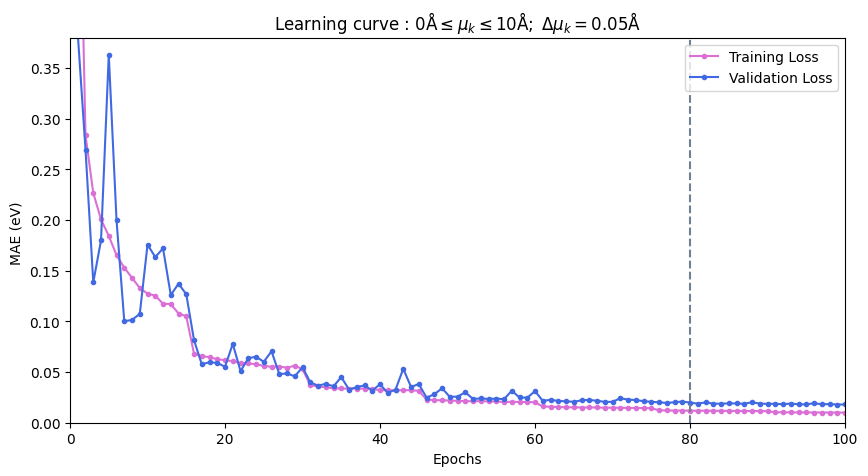

In [1]:
import matplotlib.pyplot as plt
import numpy as np

U0_train_mae_epoch = np.loadtxt('U0_train_mae_epoch.txt')
U0_val_mae_epoch = np.loadtxt('U0_val_mae_epoch.txt')


# Calculate the absolute differences between training and validation loss


epochs = np.arange(1,151)
fig, ax = plt.subplots(figsize=(10, 5))  

ax.plot(epochs, U0_train_mae_epoch, 'o-',color='orchid', label='Training Loss', markersize=3)
ax.plot(epochs, U0_val_mae_epoch, 'o-',color='royalblue', label='Validation Loss', markersize=3)

ax.axvline(x=80, color='slategray', linestyle='--')  #label='Minimum difference epoch'
ax.set_xlim(0, 100)  # X-axis range from 0 to 6
ax.set_ylim(0, 0.38)  # Y-axis range from 0 to 0.7
#ax.set_title(r'$0\mathrm{\AA} \leq \mu_k \leq 10\mathrm{\AA} \; \text{every} \; 0.1\mathrm{\AA}$')
ax.set_title(r'Learning curve : $0\mathrm{\AA} \leq \mu_k \leq 10\mathrm{\AA} ;\; \mathrm{\Delta} \mu_k = 0.05\mathrm{\AA}$')
ax.legend(loc='upper right')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE (eV) ')

plt.savefig('LC_schnet.png',dpi=330, bbox_inches='tight', format='png')
plt.show()

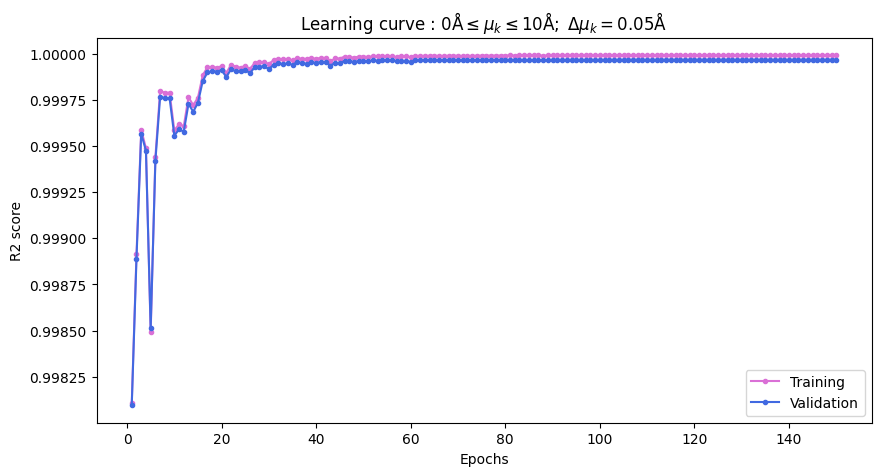

In [2]:
from matplotlib.ticker import FuncFormatter

U0_train_r2_epoch = np.loadtxt('U0_train_r2_epoch.txt')
U0_val_r2_epoch = np.loadtxt('U0_val_r2_epoch.txt')

epochs = np.arange(1,151)
fig, ax = plt.subplots(figsize=(10, 5))  

ax.plot(epochs, U0_train_r2_epoch, 'o-',color='orchid', label='Training', markersize=3)
ax.plot(epochs, U0_val_r2_epoch, 'o-',color='royalblue', label='Validation', markersize=3)
# Round y-ticks to 1 decimal place

#ax.axvline(x=80, color='slategray', linestyle='--')  #label='Minimum difference epoch'
#ax.set_xlim(0, 100)  # X-axis range from 0 to 6
#ax.set_ylim(0, 0.6)  # Y-axis range from 0 to 0.7
ax.set_title(r'Learning curve : $0\mathrm{\AA} \leq \mu_k \leq 10\mathrm{\AA} ;\; \mathrm{\Delta} \mu_k = 0.05\mathrm{\AA}$')
ax.legend(loc='lower right')
ax.set_xlabel('Epochs')
ax.set_ylabel('R2 score')


plt.show()

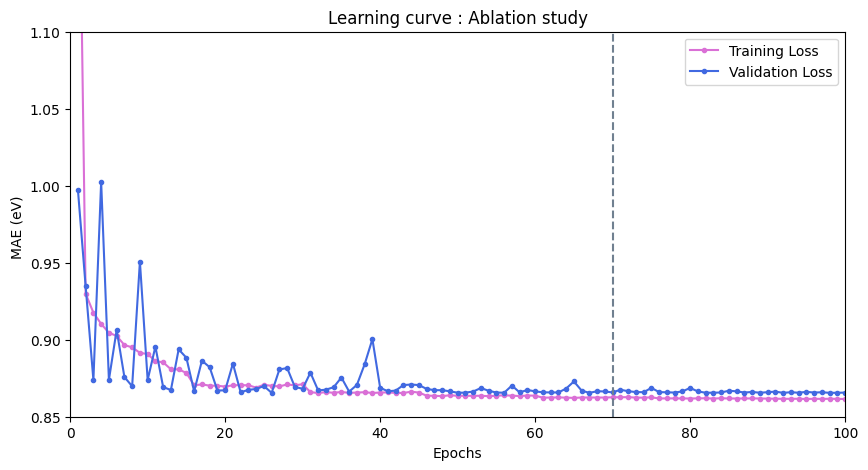

In [3]:
import matplotlib.pyplot as plt

U0_train_mae_epoch = np.loadtxt('U0_ablation1_train_mae_epoch.txt')
U0_val_mae_epoch = np.loadtxt('U0_ablation1_val_mae_epoch.txt')


# Calculate the absolute differences between training and validation loss
loss_diff = np.abs(U0_train_mae_epoch - U0_val_mae_epoch)

# Find the epoch with the smallest difference
min_diff_index = np.argmin(loss_diff)
best_epoch = epochs[min_diff_index]

epochs = np.arange(1,151)
fig, ax = plt.subplots(figsize=(10, 5))  

ax.plot(epochs, U0_train_mae_epoch, 'o-',color='orchid', label='Training Loss', markersize=3)
ax.plot(epochs, U0_val_mae_epoch, 'o-',color='royalblue', label='Validation Loss', markersize=3)

ax.axvline(x=70, color='slategray', linestyle='--')  #label='Minimum difference epoch'
ax.set_xlim(0, 100)  # X-axis range from 0 to 6
ax.set_ylim(0.85, 1.1)  # Y-axis range from 0 to 0.7
#ax.set_title(r'$0\mathrm{\AA} \leq \mu_k \leq 10\mathrm{\AA} \; \text{every} \; 0.1\mathrm{\AA}$')
ax.set_title(r'Learning curve : Ablation study')
ax.legend(loc='upper right')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE (eV) ')
plt.savefig('LC_ablation.png',dpi=330, bbox_inches='tight', format='png')

plt.show()

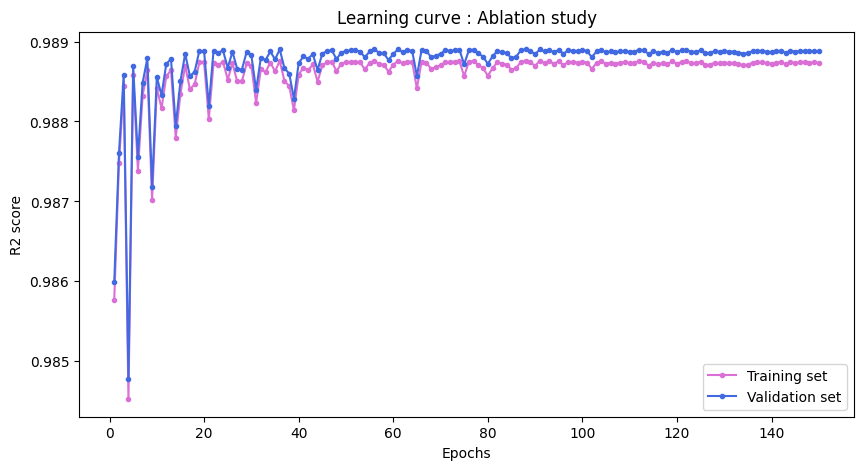

In [4]:
from matplotlib.ticker import FuncFormatter

U0_train_r2_epoch = np.loadtxt('U0_ablation1_train_r2_epoch.txt')
U0_val_r2_epoch = np.loadtxt('U0_ablation1_val_r2_epoch.txt')

epochs = np.arange(1,151)
fig, ax = plt.subplots(figsize=(10, 5))  

ax.plot(epochs, U0_train_r2_epoch, 'o-',color='orchid', label='Training set', markersize=3)
ax.plot(epochs, U0_val_r2_epoch, 'o-',color='royalblue', label='Validation set', markersize=3)
# Round y-ticks to 1 decimal place

#ax.axvline(x=80, color='slategray', linestyle='--')  #label='Minimum difference epoch'
#ax.set_xlim(0, 100)  # X-axis range from 0 to 6
#ax.set_ylim(0, 0.6)  # Y-axis range from 0 to 0.7
ax.set_title(r'Learning curve : Ablation study')
ax.legend(loc='lower right')
ax.set_xlabel('Epochs')
ax.set_ylabel('R2 score')


plt.show()

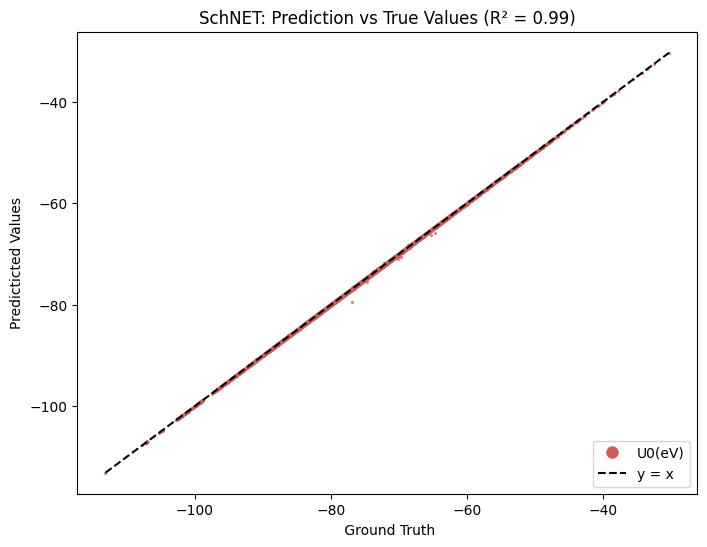

In [5]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


U0_true = np.load('U0_heldout_true.txt.npy').reshape(-1, 1)  # resphae converts the 1d array of shape (n,) to (n,1)

U0_pred = np.load('U0_heldout_pred.txt.npy').reshape(-1, 1)

min_value = np.min(U0_true)
max_value = np.max(U0_true)
last_value = U0_true[-1]
r2 = r2_score(U0_true, U0_pred)
# Define how many equally spaced points you want (for example, 100 points)
num_points = 100

# Create an array of equally spaced points between min and max
equally_spaced_points = np.linspace(min_value, max_value, num_points)
fig, axs = plt.subplots(figsize=(8, 6))

axs.scatter(U0_true,U0_pred, alpha=0.6, s=2, color = 'indianred',label='U0(eV)')
axs.plot(equally_spaced_points, equally_spaced_points, 'k--',label='y = x')

custom_scatter = Line2D([0], [0], marker='o', color='w', markerfacecolor='indianred', markersize=10, label='U0(eV)')

# Add the custom scatter legend and other elements
axs.set_title(f'SchNET: Prediction vs True Values (R² = 0.99)')
axs.legend(handles=[custom_scatter, axs.lines[0]], loc='lower right')

axs.set_xlabel(' Ground Truth')
axs.set_ylabel('Predicticted Values')

plt.savefig('scatter_schnet.png',dpi=330, bbox_inches='tight', format='png')



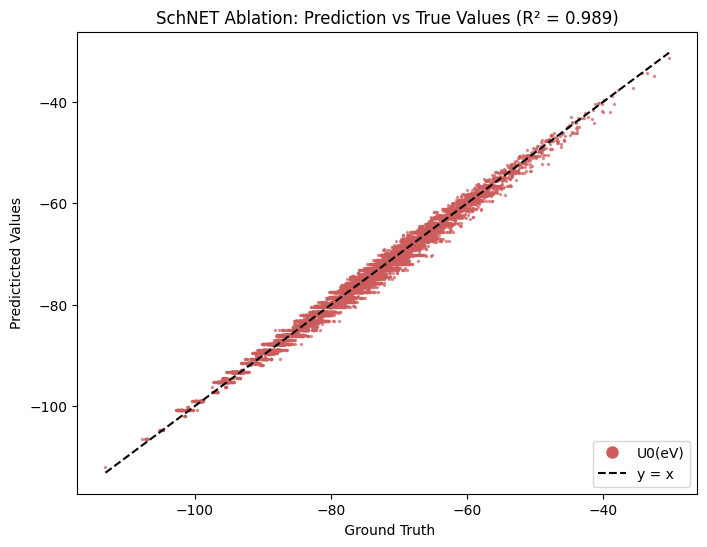

In [6]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import seaborn as sns


U0_true = np.loadtxt('U0_abltion1_heldout_true.txt').reshape(-1, 1)  # resphae converts the 1d array of shape (n,) to (n,1)
U0_pred = np.loadtxt('U0_ablation1_heldout_pred.txt').reshape(-1, 1)
min_value = np.min(U0_true)
max_value = np.max(U0_true)
last_value = U0_true[-1]
r2 = r2_score(U0_true, U0_pred)
# Define how many equally spaced points you want (for example, 100 points)
num_points = 100

# Create an array of equally spaced points between min and max
equally_spaced_points = np.linspace(min_value, max_value, num_points)
fig, axs = plt.subplots(figsize=(8, 6))

axs.scatter(U0_true,U0_pred, alpha=0.6, s=2, color = 'indianred',label='U0(eV)')
axs.plot(equally_spaced_points, equally_spaced_points, 'k--',label='y = x')
custom_scatter = Line2D([0], [0], marker='o', color='w', markerfacecolor='indianred', markersize=10, label='U0(eV)')

# Add the custom scatter legend and other elements
axs.set_title(f'SchNET Ablation: Prediction vs True Values (R² = {r2:.3f})')
axs.legend(handles=[custom_scatter, axs.lines[0]], loc='lower right')

axs.set_xlabel(' Ground Truth')
axs.set_ylabel('Predicticted Values')
plt.savefig('LC_ablation.png',dpi=330, bbox_inches='tight', format='png')